In [ ]:
# This notebook has everything you need to create datasets/dataloaders, create models, hyperparameter tune with optuna 
# train a model and evaluate it

In [2]:
#using DeepActiNet for acc feature extraction and a GRU \
modelType = "ActiNetGRU"

In [3]:
modelTypedict = {"ManualGRU": ["Manual", "GRU"], "ManualLSTM": ["Manual", "LSTM"], "ActiNetGRU": ["ActiNet", "GRU"], "ActiNetLSTM": ["ActiNet", "LSTM"]}
acc_preprocess = modelTypedict[modelType][0]
RNN_type = modelTypedict[modelType][1]

In [1]:
import os
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchmetrics.classification import MulticlassCohenKappa
from IPython.display import clear_output
import optuna
import pytorch_lightning as pl
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, cohen_kappa_score, roc_auc_score, confusion_matrix
import seaborn as sns
from collections import Counter
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers.wandb import WandbLogger
import wandb
from x_transformers import ContinuousTransformerWrapper, Encoder
torch.set_float32_matmul_precision('medium')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from wearables import Wearables

/ext3/miniforge3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Set up Datasets

In [4]:
data_dir = '/scratch/npr264/BioDeepL/dreamt/physionet.org/files/dreamt/2.0.0/data_64Hz'

In [5]:
participant_info_df = pd.read_csv('/scratch/npr264/BioDeepL/dreamt/physionet.org/files/dreamt/2.0.0/participant_info.csv')
subjects_all = participant_info_df['SID']

subjects_all_shuffled = participant_info_df['SID'].sample(frac=1, random_state=42).reset_index(drop=True)
subjects_train = subjects_all_shuffled[:int(len(subjects_all_shuffled)*0.8)]
subjects_val = subjects_all_shuffled[int(len(subjects_all_shuffled)*0.8):int(len(subjects_all_shuffled)*0.9)]
subjects_test = subjects_all_shuffled[int(len(subjects_all_shuffled)*0.9):]
print(f"number of subjects in train: {len(subjects_train)}")
print(f"number of subjects in val: {len(subjects_val)}")
print(f"number of subjects in test: {len(subjects_test)}")

number of subjects in train: 80
number of subjects in val: 10
number of subjects in test: 10


In [ ]:
non_acc_freq = 0.2
acc_freq = 32
chunk_duration = 6000 # chunk duration in seconds
chunk_stride = 3000
train_dataset_mixed = Wearables(subjects_list=subjects_train,
                                 data_dir=data_dir,
                                 chunk_duration=chunk_duration,
                                 chunk_stride=chunk_stride,
                                 downsample_freq=non_acc_freq,
                                 acc_freq=acc_freq,
                                 debug=False)
print(f"Total samples in train dataset: {len(train_dataset_mixed)}")
val_dataset_mixed = Wearables(subjects_list=subjects_val,
                                 data_dir=data_dir,
                                 chunk_duration=chunk_duration,
                                 chunk_stride=chunk_stride,
                                 downsample_freq=non_acc_freq, 
                                 acc_freq=acc_freq,
                                 debug=False)
print(f"Total samples in val dataset: {len(val_dataset_mixed)}")
test_dataset_mixed = Wearables(subjects_list=subjects_test,
                                 data_dir=data_dir,
                                 chunk_duration=chunk_duration,
                                 chunk_stride=chunk_stride,
                                 downsample_freq=non_acc_freq,
                                 acc_freq=acc_freq,
                                 debug=False)
print(f"Total samples in test dataset: {len(test_dataset_mixed)}")

In [17]:
#OPTIONAL, save datasets as they take a long time to create
torch.save(train_dataset_mixed, f'/home/npr264/DeepLearning/project/cleaned/datasets/trainset_{chunk_duration}s.pt')
torch.save(val_dataset_mixed, f'/home/npr264/DeepLearning/project/cleaned/datasets/valset_{chunk_duration}s.pt')
torch.save(test_dataset_mixed, f'/home/npr264/DeepLearning/project/cleaned/datasets/testset_{chunk_duration}s.pt')

### Loading in and class weights

In [ ]:
chunk_duration = 6000
train_dataset_mixed = torch.load(f'/home/npr264/DeepLearning/project/cleaned/datasets/trainset_{chunk_duration}s.pt')
val_dataset_mixed = torch.load(f'/home/npr264/DeepLearning/project/cleaned/datasets/valset_{chunk_duration}s.pt')

In [7]:
# get class weights for weighted loss
all_labels = []
for batch in DataLoader(train_dataset_mixed, batch_size=1):
    labels = batch[2].numpy()
    all_labels.extend(labels.flatten())
all_labels = np.array(all_labels)
valid_labels = all_labels[all_labels != -1]
classes = np.arange(4)
class_counts = Counter(valid_labels)
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=valid_labels
)
print(f"Class counts: {class_counts}")
print(f"Class weights: {class_weights}")

Class counts: Counter({np.int64(1): 155342, np.int64(0): 53092, np.int64(3): 24240, np.int64(2): 9372})
Class weights: [1.13974798 0.38953728 6.45662612 2.49634901]


In [8]:
weight_tensor = torch.tensor(class_weights, dtype=torch.float32)

### Model Definitions

#### Acc Models

In [9]:
#"Manual" model
def extract_features(acc, window_size=160):
    # acc: [batch_size, seq_len, 3]
    batch_size, seq_len, dims = acc.shape
    assert seq_len % window_size == 0, "seq_len must be divisible by window_size"

    # Reshape: [batch_size, seq_len // window_size, window_size, 3]
    acc = acc.view(batch_size, seq_len // window_size, window_size, dims)

    # Compute features along the window dimension (dim=2)
    mean = acc.mean(dim=2)
    abs_mean = acc.abs().mean(dim=2)
    max_val = acc.max(dim=2).values
    min_val = acc.min(dim=2).values
    range_val = max_val - min_val
    var = acc.var(dim=2, unbiased=False)
    rms = torch.sqrt((acc ** 2).mean(dim=2))
    iqr = torch.quantile(acc, 0.75, dim=2) - torch.quantile(acc, 0.25, dim=2)
    q25 = torch.quantile(acc, 0.25, dim=2)
    q50 = torch.quantile(acc, 0.50, dim=2)
    q75 = torch.quantile(acc, 0.75, dim=2)

    # Concatenate all features along the last dimension
    features = torch.cat([
        mean, abs_mean, max_val, min_val, range_val, var, rms, iqr, q25, q50, q75
    ], dim=-1)  # shape: [batch_size, seq_len // 160, 33]

    return features

In [10]:
class DeepACTINeT(nn.Module):
    def __init__(self, cnn_output_channels, dropout=0.25):
        super(DeepACTINeT, self).__init__()
        # Define the layers as per the structure provided
        self.conv1 = nn.Conv1d(in_channels=3, out_channels=16, kernel_size=512, stride=2)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=256, stride=2)
        self.conv3 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=256, stride=2)
        self.conv4 = nn.Conv1d(in_channels=16, out_channels=cnn_output_channels, kernel_size=32, stride=2)
        
        self.dropout = nn.Dropout(dropout)
        self.batch_norm1 = nn.BatchNorm1d(16)
        self.batch_norm2 = nn.BatchNorm1d(16)
        self.batch_norm3 = nn.BatchNorm1d(16)
        self.batch_norm4 = nn.BatchNorm1d(cnn_output_channels)
    
    def forward(self, x):
        assert not torch.isnan(x).any(), "NaN detected in CNN input"
        print(x.shape)
        x = x.permute(0,2, 1) #flip channels and num samples [batch, ch, num samples]

        initial_samples = x.shape[2]
        #you want to end up with one every 5 seconds 
        final_samples = initial_samples // (32*5)

        x = F.relu(self.conv1(x))
        #print(f"Input shape after conv1: {x.shape}")
        x = self.dropout(x)
        #print(f"Input shape after, dropout: {x.shape}")
        x = self.batch_norm1(x)
        #print(f"Input shape after conv1,dropout,batchnorm: {x.shape}")
        x = F.max_pool1d(x, kernel_size=2, stride = 2)
        #print(f"Input shape after maxpool: {x.shape}")
        
        x = F.relu(self.conv2(x))
        x = self.dropout(x)
        x = self.batch_norm2(x)
        #print(f"Input shape after conv2: {x.shape}")
        
        x = F.relu(self.conv3(x))
        x = self.dropout(x)
        x = self.batch_norm3(x)
        #print(f"Input shape after conv3: {x.shape}")
        
        x = F.max_pool1d(x, kernel_size=2, stride = 2)
        #print(f"Input shape after maxpool: {x.shape}")
        
        x = F.relu(self.conv4(x))
        x = self.dropout(x)
        x = self.batch_norm4(x)
        #print(f"before avg pooling shape: {x.shape}")

        x = F.adaptive_avg_pool1d(x, final_samples)
        #print(f"Final output shape: {x.shape}")
        
        return x

#### LSTM model 

In [11]:
#acc_preprocess = "ActiNet" or "Manual"
class SleepStager(pl.LightningModule):
    def __init__(self,
                non_acc_dim:         int,
                acc_preprocess = acc_preprocess,
                RNN_type = RNN_type,
                bidirectional = True,
                cnn_output_channels: int = 16,
                dropout_embed:   float = 0.25,
                dropout_rnn: float = 0.25,
                dropout_hidden2: float= 0.25,
                pre_rnn_embedding_size: int = 16,
                rnn_hidden_size:   int = 128,
                hidden_size2:       int = 64,
                num_sleep_stages:   int = 4,
                lr:                  float = 1e-3,
                weight_tensor:      torch.Tensor = None,
                debug:            bool = False):
        super().__init__()
        if acc_preprocess == "ActiNet":
            self.mode = "ActiNet"
            self.acc_processing = DeepACTINeT(cnn_output_channels)
            self.acc_channels = cnn_output_channels
        elif acc_preprocess == "Manual":
            self.mode = "Manual"
            self.acc_processing = extract_features
            self.acc_channels = 33
        else:
            raise ValueError("ActiNet or Manual are the only valid options")
        
        self.RNN_type = RNN_type
        self.non_acc_dim = non_acc_dim
        self.embeddingLayer = nn.Linear(self.non_acc_dim, pre_rnn_embedding_size)
        self.cnn_output_channels = cnn_output_channels

        #add non linearity to the bvp and temp before lstm 
        self.pre_rnn_embedding_size = pre_rnn_embedding_size

        self.rnn_hidden_size = rnn_hidden_size
        self.hidden_size2 = hidden_size2

        self.dropout_embed = nn.Dropout(p=dropout_embed)
        self.dropout_rnn = dropout_rnn
        self.dropout_hidden2 = nn.Dropout(p=dropout_hidden2)

        self.rnn_input_size = self.pre_rnn_embedding_size + self.acc_channels
        self.rnn_hidden_size = rnn_hidden_size

        if self.RNN_type == "GRU":
            rnn = nn.GRU
        elif self.RNN_type == "LSTM":
            rnn = nn.LSTM
        else:
            raise Exception("[Error] Unknown RnnType. Currently supported: GRU, LSTM")

        self.rnn = rnn(input_size=self.rnn_input_size,
                            hidden_size=self.rnn_hidden_size,
                            dropout = self.dropout_rnn,
                            num_layers = 2,
                            bias = True,
                            batch_first=False,
                            bidirectional = True)
       
        self.hidden2 = nn.Linear(rnn_hidden_size*2, hidden_size2)
        classifier_in = hidden_size2
        self.classifier = nn.Linear(classifier_in, num_sleep_stages)
    
        self.train_criterion = nn.CrossEntropyLoss(weight=weight_tensor, ignore_index=-1)
        self.val_criterion = nn.CrossEntropyLoss(weight=weight_tensor, ignore_index=-1)
        
        self.lr        = lr
        self.debug      = debug
        self.kappa = MulticlassCohenKappa(num_classes=num_sleep_stages)

    def forward(self, acc, non_acc):
        """
        non_acc: (batch, non_acc_length, non_acc_dim)
        acc:     (batch, acc_length)  or  (batch, acc_length, 1)
        returns:
          y_hat (output_length, batch, num_sleep_stages)
        """
        # ensure ACC has a channel dim
        if acc.dim() == 2:
            acc = acc.unsqueeze(-1)          # now (batch, T, 1)
        
        # 1) ACC → CNN → (batch, num_cnn_feats, cnn_output_length)
        acc_feats = self.acc_processing(acc)
        
        if self.debug:
            print(f"[DEBUG] ACC CNN output shape: {acc_feats.shape}") # (batch, num_cnn_feats, cnn_output_length)
            print(f"[DEBUG] NON_ACC input shape: {non_acc.shape}") # (batch, non_acc_length, non_acc_dim)
        
        #embed the non_acc data 
        emb_non_acc = self.embeddingLayer(non_acc)
        emb_non_acc = self.dropout_embed(emb_non_acc)
        #emb_non_acc = non_acc
        # 3) build LSTM input: (T', batch, feature_dim)
        if self.mode == "ActiNet":
            a = acc_feats.permute(2, 0, 1)     
        elif self.mode == "Manual":
            a = acc_feats.permute(1,0,2)
        b = emb_non_acc.permute(1, 0, 2)       

        if self.debug:
            print(f"[DEBUG] ACC CNN reshaped shape: {a.shape}") 
            print(f"[DEBUG] NON_ACC reshaped shape: {b.shape}")
       
        rnn_in = torch.cat([a, b], dim = 2)    # (lstm_seq_len, batch, C_cnn + D_nonacc)
        # without batch_first = true, LSTM input shape is (seq_len, batch_size, features)


        if self.debug:
            print(f"[DEBUG] RNN input shape: {rnn_in.shape}")
            print(f"[DEBUG] RNN hidden size: {self.rnn_hidden_size}")
    
        output,_ = self.rnn(rnn_in)
        output = self.hidden2(output)
        output = self.dropout_hidden2(output)
        if self.debug:
            print(f"[DEBUG] hidden2 shape: {output.shape}")
        y_hat = self.classifier(output)     # (lstm_seq_len, batch, num_sleep_stages)
        if self.debug:
            print(f"[DEBUG] Classifier output shape: {y_hat.shape}")
        return y_hat
            
    def training_step(self, batch, batch_idx):
        non_acc, acc, labels = batch
        '''
        non_acc: (batch, non_acc_length, non_acc_dim)
        acc:     (batch, acc_length)  or  (batch, acc_length, 1)
        labels:  (batch, non_acc_length)
        '''
        y_hat = self(acc, non_acc)            # (lstm_seq_len, batch, num_sleep_stages)
        y_hat = y_hat.permute(1, 0, 2)        # (batch, lstm_seq_len, num_sleep_stages)
    
        # flatten
        batch_size, output_length, num_sleep_stages = y_hat.shape
        y_hat_flat = y_hat.reshape(batch_size * output_length, num_sleep_stages)
        labels_flat  = labels.reshape(batch_size * output_length)
        
        # calculate loss
        loss = self.train_criterion(y_hat_flat, labels_flat)
    
        self.log('train_loss', loss, prog_bar=True, on_step=True, on_epoch=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        non_acc, acc, labels = batch
            
        '''
        non_acc: (batch, non_acc_length, non_acc_dim)
        acc:     (batch, acc_length)  or  (batch, acc_length, 1)
        labels:  (batch, non_acc_length)
        '''
        y_hat = self(acc, non_acc)            # (lstm_seq_len, batch, num_sleep_stages)
        y_hat = y_hat.permute(1, 0, 2)        # (batch, lstm_seq_len, num_sleep_stages)
    
        # flatten
        batch_size, output_length, num_sleep_stages = y_hat.shape
        y_hat_flat = y_hat.reshape(batch_size * output_length, num_sleep_stages)
        labels_flat  = labels.reshape(batch_size * output_length)
        
        # calculate loss
        loss = self.val_criterion(y_hat_flat, labels_flat)
    
        # calculate accuracy
        predictions = torch.argmax(y_hat_flat, dim=1)
        mask = labels_flat != -1
        masked_preds = predictions[mask]
        masked_labels = labels_flat[mask]
        if masked_labels.numel() > 0:
            acc = (masked_preds == masked_labels).float().mean().item()
        else:
            acc = 0.0
    
        # calculate cohen's kappa
        mask = labels_flat != -1
        y_valid = labels_flat[mask]
        preds_valid = predictions[mask]
        if y_valid.numel() > 0:
            ckappa = self.kappa.update(preds_valid, y_valid)
        else:
            ckappa = torch.tensor(0.0, device=self.device)

        # log metrics
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc",  acc,  prog_bar=True)
        
        return {"val_loss": loss, "val_acc": acc}
        
    def on_validation_epoch_end(self):
        k = self.kappa.compute()
        self.log("val_cohen_kappa", torch.nan_to_num(k,0.0), prog_bar=True)
        self.kappa.reset()
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.3, patience=3, verbose=True, min_lr=1e-6
        )
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_loss',  # must match your validation metric
                'interval': 'epoch',
                'frequency': 1
            }
        }


### Optuna

In [ ]:
accelerator = "gpu" if torch.cuda.is_available() else "cpu"
def objective(trial, acc_preprocess, RNN_type, modelType):
    acc_preprocess = acc_preprocess
    RNN_type = RNN_type
    
    # Dropouts
    dropout_embed = trial.suggest_float('dropout_embed', 0.1, 0.55)
    dropout_rnn = trial.suggest_float('dropout_rnn', 0.1, 0.55)
    dropout_hidden2 = trial.suggest_float('dropout_hidden2', 0.1, 0.55)
    
    #label_smoothing = trial.suggest_float("label_smoothing", 0.0, 0.1)
    #Sizes
    pre_rnn_size = trial.suggest_categorical("pre_rnn_embedding_size", [4, 8, 16, 32, 64])
    rnn_hidden_size = trial.suggest_categorical("rnn_hidden_size", [32, 64, 128, 256, 512, 1024])
    hidden_size2 = trial.suggest_categorical("hidden_size2", [4, 8, 16, 32, 64])

    #other
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
    batch_size = trial.suggest_categorical("batch_size", [2,4, 8, 16,32,64,128])

    #bidirectional = trial.suggest_categorical("bidirectional", [True, False])
    #Conditional logic for acc_preprocess-specific parameters
    if acc_preprocess == "ActiNet":
        cnn_output_channels = trial.suggest_categorical("cnn_output_channels", [8, 16, 32, 64, 128])
        cnn_name_piece = f"_cnn{cnn_output_channels}"
    else:
        cnn_output_channels = None  # Not relevant for "Manual"
        cnn_name_piece = ""
    
    size_piece = f"prernn{pre_rnn_size}_rnn{rnn_hidden_size}_hidden{hidden_size2}"
    other_piece = f"lr{learning_rate}_batchsize{batch_size}"
    dropout_piece = f"dropoutembed{dropout_embed}_dropoutRNN{dropout_rnn}_dropouthidden2{dropout_hidden2}"
    name = size_piece+other_piece+dropout_piece+cnn_name_piece
    
    wandb_logger = WandbLogger(name, project = f'{modelType}2')
    #wandb.define_metric("best_val_loss", summary="min")
    checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath=f'/scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/{trial.number}/',
    filename='best-checkpoint',
    save_top_k=1,
    mode='min'
    )
    early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=4,
    verbose=True,
    mode='min'
    )
    trainer = pl.Trainer(
    max_epochs=20,
    devices=1,
    accelerator=accelerator,
    logger=wandb_logger,
    callbacks=[checkpoint_callback, early_stop_callback],
    log_every_n_steps=2,
    )
    model = SleepStager(non_acc_dim = 5,
                        acc_preprocess = acc_preprocess,
                        RNN_type = RNN_type,
                        dropout_embed = dropout_embed,
                        dropout_rnn = dropout_rnn,
                        dropout_hidden2 = dropout_hidden2,
                        pre_rnn_embedding_size= pre_rnn_size,
                        rnn_hidden_size= rnn_hidden_size,
                        hidden_size2= hidden_size2,
                        lr = learning_rate,
                        cnn_output_channels = cnn_output_channels,
                        weight_tensor=weight_tensor.to(device),
                    debug= False)
    # train_dataset_optuna, val_dataset_optuna = get_datasets(segment_len, segment_len/2)
    train_loader = DataLoader(train_dataset_mixed, batch_size=batch_size, shuffle=True, num_workers = 8)
    val_loader = DataLoader(val_dataset_mixed, batch_size=batch_size, shuffle=False, num_workers = 8)
    trainer.fit(model, train_loader, val_loader)
    

    #we will pull the best model, even if it overtrained a little, so we need to go pull that best model to understand its performance
    best_model_path = checkpoint_callback.best_model_path
    print(f"Best model path: {best_model_path}")
    
    # Load the model
    best_model = SleepStager.load_from_checkpoint(best_model_path,non_acc_dim = 5,
                            acc_preprocess = acc_preprocess,
                            RNN_type = RNN_type,
                            dropout_embed = dropout_embed,
                            dropout_rnn = dropout_rnn,
                            dropout_hidden2 = dropout_hidden2,
                            pre_rnn_embedding_size= pre_rnn_size,
                            rnn_hidden_size= rnn_hidden_size,
                            hidden_size2= hidden_size2,
                            lr = learning_rate,
                            cnn_output_channels = cnn_output_channels,
                            weight_tensor=weight_tensor.to(device),
                        debug= False)
    # Evaluate the best model
    trainer_best = pl.Trainer(devices=1, accelerator=accelerator)
    val_result = trainer_best.validate(best_model, val_loader, verbose=False)
    val_loss = val_result[0]["val_loss"]
    #log needed things
    wandb_logger.experiment.config.update(trial.params)
    wandb_logger.experiment.config.update({"trial_number": trial.number})
    wandb_logger.experiment.log({"best_val_loss": val_loss})
    wandb.finish()

    return val_loss

study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, acc_preprocess, RNN_type, modelType), n_trials=500)
best_trial = study.best_trial
print("Best trial:")
print(f"  Value: {best_trial.value}")
print("  Params:")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

[I 2025-04-29 22:20:52,208] A new study created in memory with name: no-name-ef042727-1ead-4a9b-a904-ed3a098cf4b1
/state/partition1/job-59918280/ipykernel_99061/2410889102.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/0 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | acc_processing  | DeepACTINeT          | 172 K  | train
1 | embeddingLayer  | Linear               | 48     | train
2 | dropout_embed   | Dropout              | 0      | train
3 | dropout_hidden2 | Dropout              | 0      | train
4 | rnn             | GRU                  | 115 K  | train
5 | hidden2         | Linear               | 2.1 K  | train
6 | classifier      | Linear               | 68     | train
7 | 

Epoch 0: 100%|██████████| 51/51 [00:03<00:00, 16.14it/s, v_num=aomv, train_loss_step=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/7 [00:00<?, ?it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 1/7 [00:00<00:00, 43.18it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 2/7 [00:00<00:00, 40.08it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 3/7 [00:00<00:00, 40.09it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 4/7 [00:00<00:00, 39.08it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  71%|███████▏  | 5/7 [00:00<00:00, 39.33it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  86%|████████▌ | 6/7 [00:00<00:00, 39.47it/s]torch.Size([4, 192000, 3])

Epoch 0: 100%|██████████| 51/51 [00:03<00:00, 13.01it/s, v_num=aomv, train_loss_step=1.380, val_loss=1.340, val_acc=0.311, val_cohen_kappa=0.0653, train_loss_epoch=1.380]

Metric val_loss improved. New best score: 1.338


Epoch 1: 100%|██████████| 51/51 [00:03<00:00, 13.51it/s, v_num=aomv, train_loss_step=1.450, val_loss=1.340, val_acc=0.311, val_cohen_kappa=0.0653, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/7 [00:00<?, ?it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 1/7 [00:00<00:00, 41.77it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 2/7 [00:00<00:00, 41.58it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 3/7 [00:00<00:00, 40.34it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 4/7 [00:00<00:00, 40.33it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  71%|███████▏  | 5/7 [00:00<00:00, 39.72it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  86%|████████▌ | 6/7 [00:00<00:00, 39.07it/s]torch.Size([4, 192000, 3])

Epoch 1: 100%|██████████| 51/51 [00:04<00:00, 11.12it/s, v_num=aomv, train_loss_step=1.450, val_loss=1.29

Metric val_loss improved by 0.053 >= min_delta = 0.0. New best score: 1.285


Epoch 2: 100%|██████████| 51/51 [00:03<00:00, 13.75it/s, v_num=aomv, train_loss_step=1.450, val_loss=1.290, val_acc=0.265, val_cohen_kappa=0.116, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/7 [00:00<?, ?it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 1/7 [00:00<00:00, 44.29it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 2/7 [00:00<00:00, 37.05it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 3/7 [00:00<00:00, 37.46it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 4/7 [00:00<00:00, 37.58it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  71%|███████▏  | 5/7 [00:00<00:00, 37.60it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  86%|████████▌ | 6/7 [00:00<00:00, 37.67it/s]torch.Size([4, 192000, 3])

Epoch 3: 100%|██████████| 51/51 [00:03<00:00, 13.81it/s, v_num=aomv, train_loss_step=1.240, val_loss=1.310

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 1.262


Epoch 4: 100%|██████████| 51/51 [00:03<00:00, 13.77it/s, v_num=aomv, train_loss_step=1.360, val_loss=1.260, val_acc=0.304, val_cohen_kappa=0.117, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/7 [00:00<?, ?it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 1/7 [00:00<00:00, 40.01it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 2/7 [00:00<00:00, 40.02it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 3/7 [00:00<00:00, 37.94it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 4/7 [00:00<00:00, 38.44it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  71%|███████▏  | 5/7 [00:00<00:00, 38.97it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  86%|████████▌ | 6/7 [00:00<00:00, 38.78it/s]torch.Size([4, 192000, 3])

Epoch 4: 100%|██████████| 51/51 [00:04<00:00, 11.26it/s, v_num=aomv, train_loss_step=1.360, val_loss=1.260

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.261


Epoch 5: 100%|██████████| 51/51 [00:03<00:00, 13.37it/s, v_num=aomv, train_loss_step=1.330, val_loss=1.260, val_acc=0.246, val_cohen_kappa=0.093, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/7 [00:00<?, ?it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 1/7 [00:00<00:00, 41.54it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 2/7 [00:00<00:00, 40.69it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 3/7 [00:00<00:00, 39.71it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 4/7 [00:00<00:00, 39.24it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  71%|███████▏  | 5/7 [00:00<00:00, 38.53it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  86%|████████▌ | 6/7 [00:00<00:00, 37.93it/s]torch.Size([4, 192000, 3])

Epoch 6: 100%|██████████| 51/51 [00:03<00:00, 13.44it/s, v_num=aomv, train_loss_step=1.320, val_loss=1.260

Metric val_loss improved by 0.040 >= min_delta = 0.0. New best score: 1.221


Epoch 7: 100%|██████████| 51/51 [00:03<00:00, 13.46it/s, v_num=aomv, train_loss_step=1.360, val_loss=1.220, val_acc=0.303, val_cohen_kappa=0.115, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/7 [00:00<?, ?it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 1/7 [00:00<00:00, 39.88it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 2/7 [00:00<00:00, 37.85it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 3/7 [00:00<00:00, 38.53it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 4/7 [00:00<00:00, 38.98it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  71%|███████▏  | 5/7 [00:00<00:00, 39.20it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  86%|████████▌ | 6/7 [00:00<00:00, 39.01it/s]torch.Size([4, 192000, 3])

Epoch 8: 100%|██████████| 51/51 [00:03<00:00, 13.41it/s, v_num=aomv, train_loss_step=1.790, val_loss=1.250

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 1.214


Epoch 10: 100%|██████████| 51/51 [00:03<00:00, 13.41it/s, v_num=aomv, train_loss_step=1.360, val_loss=1.210, val_acc=0.310, val_cohen_kappa=0.137, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/7 [00:00<?, ?it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 1/7 [00:00<00:00, 44.23it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 2/7 [00:00<00:00, 42.53it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 3/7 [00:00<00:00, 41.67it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 4/7 [00:00<00:00, 39.73it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  71%|███████▏  | 5/7 [00:00<00:00, 39.83it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  86%|████████▌ | 6/7 [00:00<00:00, 39.13it/s]torch.Size([4, 192000, 3])

Epoch 11: 100%|██████████| 51/51 [00:03<00:00, 13.79it/s, v_num=aomv, train_loss_step=0.817, val_loss=1.2

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 1.196


Epoch 12: 100%|██████████| 51/51 [00:03<00:00, 13.66it/s, v_num=aomv, train_loss_step=1.190, val_loss=1.200, val_acc=0.302, val_cohen_kappa=0.126, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/7 [00:00<?, ?it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 1/7 [00:00<00:00, 45.49it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 2/7 [00:00<00:00, 40.28it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 3/7 [00:00<00:00, 40.42it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 4/7 [00:00<00:00, 40.43it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  71%|███████▏  | 5/7 [00:00<00:00, 40.39it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  86%|████████▌ | 6/7 [00:00<00:00, 40.37it/s]torch.Size([4, 192000, 3])

Epoch 13: 100%|██████████| 51/51 [00:03<00:00, 13.76it/s, v_num=aomv, train_loss_step=1.390, val_loss=1.2

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 1.179


Epoch 15: 100%|██████████| 51/51 [00:03<00:00, 13.41it/s, v_num=aomv, train_loss_step=1.140, val_loss=1.180, val_acc=0.330, val_cohen_kappa=0.139, train_loss_epoch=1.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/7 [00:00<?, ?it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 1/7 [00:00<00:00, 43.60it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 2/7 [00:00<00:00, 39.92it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 3/7 [00:00<00:00, 36.28it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 4/7 [00:00<00:00, 37.10it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  71%|███████▏  | 5/7 [00:00<00:00, 37.72it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  86%|████████▌ | 6/7 [00:00<00:00, 36.38it/s]torch.Size([4, 192000, 3])

Epoch 15: 100%|██████████| 51/51 [00:04<00:00, 10.98it/s, v_num=aomv, train_loss_step=1.140, val_loss=1.1

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 1.163


Epoch 16: 100%|██████████| 51/51 [00:03<00:00, 13.46it/s, v_num=aomv, train_loss_step=1.120, val_loss=1.160, val_acc=0.345, val_cohen_kappa=0.165, train_loss_epoch=1.200]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/7 [00:00<?, ?it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 1/7 [00:00<00:00, 39.75it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 2/7 [00:00<00:00, 35.90it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 3/7 [00:00<00:00, 35.44it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 4/7 [00:00<00:00, 36.44it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  71%|███████▏  | 5/7 [00:00<00:00, 36.03it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  86%|████████▌ | 6/7 [00:00<00:00, 36.65it/s]torch.Size([4, 192000, 3])

Epoch 17: 100%|██████████| 51/51 [00:03<00:00, 13.80it/s, v_num=aomv, train_loss_step=1.140, val_loss=1.1

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.163. Signaling Trainer to stop.
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 51/51 [00:04<00:00, 11.38it/s, v_num=aomv, train_loss_step=1.290, val_loss=1.240, val_acc=0.294, val_cohen_kappa=0.121, train_loss_epoch=1.150]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/0/best-checkpoint-v21.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 37.57it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


[I 2025-04-29 22:22:26,972] Trial 0 finished with value: 1.1631513833999634 and parameters: {'dropout_embed': 0.5207760924001471, 'dropout_rnn': 0.40364410694043584, 'dropout_hidden2': 0.33929514970610747, 'pre_rnn_embedding_size': 8, 'rnn_hidden_size': 64, 'hidden_size2': 16, 'learning_rate': 0.0005836151521480681, 'batch_size': 4, 'cnn_output_channels': 32}. Best is trial 0 with value: 1.1631513833999634.
/state/partition1/job-59918280/ipykernel_99061/2410889102.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | acc_processing  | DeepACTINeT          | 221 K  | train
1 | embeddingLayer  | Linear               | 384    | train
2 | dropout_embed   | Dropout              | 0      | train
3 | dropout_hidden2 | Dropout              | 0      | train
4 | rnn             | GRU                  | 543 K  | train
5 | hidden2         | Linear               | 4.1 K  | train
6 | classifier      | Linear               | 68     | train
7 | 

Epoch 0: 100%|██████████| 26/26 [00:02<00:00,  9.17it/s, v_num=tt43, train_loss_step=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/4 [00:00<?, ?it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  25%|██▌       | 1/4 [00:00<00:00, 25.39it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  50%|█████     | 2/4 [00:00<00:00, 23.66it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  75%|███████▌  | 3/4 [00:00<00:00, 23.14it/s]torch.Size([4, 192000, 3])

Epoch 0: 100%|██████████| 26/26 [00:03<00:00,  7.24it/s, v_num=tt43, train_loss_step=1.350, val_loss=1.260, val_acc=0.262, val_cohen_kappa=0.106, train_loss_epoch=1.380]

Metric val_loss improved. New best score: 1.265


Epoch 1: 100%|██████████| 26/26 [00:03<00:00,  7.53it/s, v_num=tt43, train_loss_step=1.390, val_loss=1.260, val_acc=0.262, val_cohen_kappa=0.106, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/4 [00:00<?, ?it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  25%|██▌       | 1/4 [00:00<00:00, 24.41it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  50%|█████     | 2/4 [00:00<00:00, 20.79it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  75%|███████▌  | 3/4 [00:00<00:00, 20.30it/s]torch.Size([4, 192000, 3])

Epoch 2: 100%|██████████| 26/26 [00:03<00:00,  7.50it/s, v_num=tt43, train_loss_step=1.520, val_loss=1.330, val_acc=0.400, val_cohen_kappa=0.150, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/4 [00:00<?, ?it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  25%|██▌       | 1/4 [00:00<00:00, 25.25it/s]torch.Size([8, 192000, 3

Metric val_loss improved by 0.062 >= min_delta = 0.0. New best score: 1.203


Epoch 4: 100%|██████████| 26/26 [00:03<00:00,  7.75it/s, v_num=tt43, train_loss_step=1.030, val_loss=1.200, val_acc=0.334, val_cohen_kappa=0.148, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/4 [00:00<?, ?it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  25%|██▌       | 1/4 [00:00<00:00, 25.45it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  50%|█████     | 2/4 [00:00<00:00, 23.78it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  75%|███████▌  | 3/4 [00:00<00:00, 23.19it/s]torch.Size([4, 192000, 3])

Epoch 5: 100%|██████████| 26/26 [00:03<00:00,  7.64it/s, v_num=tt43, train_loss_step=1.350, val_loss=1.270, val_acc=0.345, val_cohen_kappa=0.153, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/4 [00:00<?, ?it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  25%|██▌       | 1/4 [00:00<00:00, 23.69it/s]torch.Size([8, 192000, 3

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.203. Signaling Trainer to stop.


Epoch 7: 100%|██████████| 26/26 [00:04<00:00,  6.26it/s, v_num=tt43, train_loss_step=1.270, val_loss=1.210, val_acc=0.326, val_cohen_kappa=0.157, train_loss_epoch=1.160]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/1/best-checkpoint-v16.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 24.76it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


[I 2025-04-29 22:23:04,162] Trial 1 finished with value: 1.2026375532150269 and parameters: {'dropout_embed': 0.5019894585354414, 'dropout_rnn': 0.15735301530240847, 'dropout_hidden2': 0.12934190189586692, 'pre_rnn_embedding_size': 64, 'rnn_hidden_size': 128, 'hidden_size2': 16, 'learning_rate': 0.0015647499251944784, 'batch_size': 8, 'cnn_output_channels': 128}. Best is trial 0 with value: 1.1631513833999634.
/state/partition1/job-59918280/ipykernel_99061/2410889102.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | acc_processing  | DeepACTINeT          | 159 K  | train
1 | embeddingLayer  | Linear               | 384    | train
2 | dropout_embed   | Dropout              | 0      | train
3 | dropout_hidden2 | Dropout              | 0      | train
4 | rnn             | GRU                  | 451 K  | train
5 | hidden2         | Linear               | 2.1 K  | train
6 | classifier      | Linear               | 36     | train
7 | 

Epoch 0: 100%|██████████| 7/7 [00:02<00:00,  2.79it/s, v_num=dydg, train_loss_step=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 0: 100%|██████████| 7/7 [00:03<00:00,  2.20it/s, v_num=dydg, train_loss_step=1.380, val_loss=1.350, val_acc=0.180, val_cohen_kappa=0.0309, train_loss_epoch=1.350]

Metric val_loss improved. New best score: 1.349


Epoch 1: 100%|██████████| 7/7 [00:03<00:00,  2.26it/s, v_num=dydg, train_loss_step=1.340, val_loss=1.350, val_acc=0.180, val_cohen_kappa=0.0309, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 1: 100%|██████████| 7/7 [00:03<00:00,  1.80it/s, v_num=dydg, train_loss_step=1.340, val_loss=1.260, val_acc=0.314, val_cohen_kappa=0.105, train_loss_epoch=1.300] 

Metric val_loss improved by 0.091 >= min_delta = 0.0. New best score: 1.258


Epoch 2: 100%|██████████| 7/7 [00:03<00:00,  2.25it/s, v_num=dydg, train_loss_step=1.260, val_loss=1.260, val_acc=0.314, val_cohen_kappa=0.105, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 3: 100%|██████████| 7/7 [00:03<00:00,  2.26it/s, v_num=dydg, train_loss_step=1.270, val_loss=1.330, val_acc=0.264, val_cohen_kappa=0.0822, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 4: 100%|██████████| 7/7 [00:03<00:00,  2.28it/s, v_num=dydg, train_loss_step=1.540, val_loss=1.280, val_acc=0.194, val_cohen_kappa=0.0792, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 4: 100%|██████████| 7/7 [00:03<00:00,  1.83it/s, v_num=dydg, train_loss_step=

Metric val_loss improved by 0.065 >= min_delta = 0.0. New best score: 1.193


Epoch 5: 100%|██████████| 7/7 [00:03<00:00,  2.28it/s, v_num=dydg, train_loss_step=1.270, val_loss=1.190, val_acc=0.245, val_cohen_kappa=0.120, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 6: 100%|██████████| 7/7 [00:03<00:00,  2.26it/s, v_num=dydg, train_loss_step=1.150, val_loss=1.250, val_acc=0.316, val_cohen_kappa=0.130, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 7: 100%|██████████| 7/7 [00:03<00:00,  2.24it/s, v_num=dydg, train_loss_step=1.350, val_loss=1.210, val_acc=0.245, val_cohen_kappa=0.123, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 7: 100%|██████████| 7/7 [00:03<00:00,  1.78it/s, v_num=dydg, train_loss_step=1.

Metric val_loss improved by 0.031 >= min_delta = 0.0. New best score: 1.162


Epoch 8: 100%|██████████| 7/7 [00:03<00:00,  2.27it/s, v_num=dydg, train_loss_step=1.310, val_loss=1.160, val_acc=0.273, val_cohen_kappa=0.126, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 9: 100%|██████████| 7/7 [00:03<00:00,  2.25it/s, v_num=dydg, train_loss_step=1.120, val_loss=1.200, val_acc=0.252, val_cohen_kappa=0.131, train_loss_epoch=1.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 9: 100%|██████████| 7/7 [00:03<00:00,  1.81it/s, v_num=dydg, train_loss_step=1.120, val_loss=1.130, val_acc=0.277, val_cohen_kappa=0.139, train_loss_epoch=1.200]

Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 1.134


Epoch 10: 100%|██████████| 7/7 [00:03<00:00,  2.24it/s, v_num=dydg, train_loss_step=1.170, val_loss=1.130, val_acc=0.277, val_cohen_kappa=0.139, train_loss_epoch=1.200]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 11: 100%|██████████| 7/7 [00:03<00:00,  2.31it/s, v_num=dydg, train_loss_step=1.120, val_loss=1.140, val_acc=0.270, val_cohen_kappa=0.137, train_loss_epoch=1.180]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 12: 100%|██████████| 7/7 [00:03<00:00,  2.24it/s, v_num=dydg, train_loss_step=1.140, val_loss=1.190, val_acc=0.276, val_cohen_kappa=0.146, train_loss_epoch=1.150]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 12: 100%|██████████| 7/7 [00:03<00:00,  1.78it/s, v_num=dydg, train_loss_ste

Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 1.108


Epoch 13: 100%|██████████| 7/7 [00:03<00:00,  2.26it/s, v_num=dydg, train_loss_step=0.919, val_loss=1.110, val_acc=0.333, val_cohen_kappa=0.178, train_loss_epoch=1.140]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 13: 100%|██████████| 7/7 [00:03<00:00,  1.79it/s, v_num=dydg, train_loss_step=0.919, val_loss=1.100, val_acc=0.315, val_cohen_kappa=0.168, train_loss_epoch=1.110]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.103


Epoch 14: 100%|██████████| 7/7 [00:03<00:00,  2.23it/s, v_num=dydg, train_loss_step=1.180, val_loss=1.100, val_acc=0.315, val_cohen_kappa=0.168, train_loss_epoch=1.110]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 15: 100%|██████████| 7/7 [00:03<00:00,  2.29it/s, v_num=dydg, train_loss_step=0.971, val_loss=1.140, val_acc=0.297, val_cohen_kappa=0.158, train_loss_epoch=1.090]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 16: 100%|██████████| 7/7 [00:03<00:00,  2.23it/s, v_num=dydg, train_loss_step=1.190, val_loss=1.120, val_acc=0.356, val_cohen_kappa=0.178, train_loss_epoch=1.080]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 17: 100%|██████████| 7/7 [00:03<00:00,  2.26it/s, v_num=dydg, train_loss_ste

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.103. Signaling Trainer to stop.


Epoch 17: 100%|██████████| 7/7 [00:03<00:00,  1.83it/s, v_num=dydg, train_loss_step=1.040, val_loss=1.170, val_acc=0.392, val_cohen_kappa=0.202, train_loss_epoch=1.010]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/2/best-checkpoint-v16.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.01it/s]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


[I 2025-04-29 22:24:17,236] Trial 2 finished with value: 1.102818489074707 and parameters: {'dropout_embed': 0.29031769505955396, 'dropout_rnn': 0.37976158555010175, 'dropout_hidden2': 0.33559834251816323, 'pre_rnn_embedding_size': 64, 'rnn_hidden_size': 128, 'hidden_size2': 8, 'learning_rate': 0.0014411711199553848, 'batch_size': 32, 'cnn_output_channels': 8}. Best is trial 2 with value: 1.102818489074707.
/state/partition1/job-59918280/ipykernel_99061/2410889102.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | acc_processing  | DeepACTINeT          | 221 K  | train
1 | embeddingLayer  | Linear               | 24     | train
2 | dropout_embed   | Dropout              | 0      | train
3 | dropout_hidden2 | Dropout              | 0      | train
4 | rnn             | GRU                  | 26.0 M | train
5 | hidden2         | Linear               | 8.2 K  | train
6 | classifier      | Linear               | 20     | train
7 | 

Epoch 0: 100%|██████████| 2/2 [00:07<00:00,  0.28it/s, v_num=j2yd, train_loss_step=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 0: 100%|██████████| 2/2 [00:08<00:00,  0.25it/s, v_num=j2yd, train_loss_step=1.400, val_loss=1.420, val_acc=0.112, val_cohen_kappa=0.000, train_loss_epoch=1.430]

Metric val_loss improved. New best score: 1.422


Epoch 1: 100%|██████████| 2/2 [00:07<00:00,  0.27it/s, v_num=j2yd, train_loss_step=1.420, val_loss=1.420, val_acc=0.112, val_cohen_kappa=0.000, train_loss_epoch=1.430]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 1: 100%|██████████| 2/2 [00:08<00:00,  0.23it/s, v_num=j2yd, train_loss_step=1.420, val_loss=1.420, val_acc=0.112, val_cohen_kappa=0.000, train_loss_epoch=1.410]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.418


Epoch 2: 100%|██████████| 2/2 [00:07<00:00,  0.27it/s, v_num=j2yd, train_loss_step=1.390, val_loss=1.420, val_acc=0.112, val_cohen_kappa=0.000, train_loss_epoch=1.410]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 2: 100%|██████████| 2/2 [00:08<00:00,  0.23it/s, v_num=j2yd, train_loss_step=1.390, val_loss=1.410, val_acc=0.112, val_cohen_kappa=0.000, train_loss_epoch=1.400]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.414


Epoch 3: 100%|██████████| 2/2 [00:07<00:00,  0.27it/s, v_num=j2yd, train_loss_step=1.400, val_loss=1.410, val_acc=0.112, val_cohen_kappa=0.000, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 3: 100%|██████████| 2/2 [00:08<00:00,  0.23it/s, v_num=j2yd, train_loss_step=1.400, val_loss=1.410, val_acc=0.112, val_cohen_kappa=0.000, train_loss_epoch=1.400]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.408


Epoch 4: 100%|██████████| 2/2 [00:07<00:00,  0.27it/s, v_num=j2yd, train_loss_step=1.370, val_loss=1.410, val_acc=0.112, val_cohen_kappa=0.000, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 4: 100%|██████████| 2/2 [00:08<00:00,  0.23it/s, v_num=j2yd, train_loss_step=1.370, val_loss=1.400, val_acc=0.112, val_cohen_kappa=0.000, train_loss_epoch=1.390]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.402


Epoch 5: 100%|██████████| 2/2 [00:07<00:00,  0.27it/s, v_num=j2yd, train_loss_step=1.380, val_loss=1.400, val_acc=0.112, val_cohen_kappa=0.000, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 5: 100%|██████████| 2/2 [00:08<00:00,  0.23it/s, v_num=j2yd, train_loss_step=1.380, val_loss=1.400, val_acc=0.112, val_cohen_kappa=0.000333, train_loss_epoch=1.380]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.396


Epoch 6: 100%|██████████| 2/2 [00:07<00:00,  0.27it/s, v_num=j2yd, train_loss_step=1.360, val_loss=1.400, val_acc=0.112, val_cohen_kappa=0.000333, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 6: 100%|██████████| 2/2 [00:08<00:00,  0.23it/s, v_num=j2yd, train_loss_step=1.360, val_loss=1.390, val_acc=0.115, val_cohen_kappa=0.00266, train_loss_epoch=1.370] 

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.389


Epoch 7: 100%|██████████| 2/2 [00:07<00:00,  0.27it/s, v_num=j2yd, train_loss_step=1.350, val_loss=1.390, val_acc=0.115, val_cohen_kappa=0.00266, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 7: 100%|██████████| 2/2 [00:08<00:00,  0.23it/s, v_num=j2yd, train_loss_step=1.350, val_loss=1.380, val_acc=0.134, val_cohen_kappa=0.0218, train_loss_epoch=1.360] 

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.383


Epoch 8: 100%|██████████| 2/2 [00:07<00:00,  0.27it/s, v_num=j2yd, train_loss_step=1.340, val_loss=1.380, val_acc=0.134, val_cohen_kappa=0.0218, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 8: 100%|██████████| 2/2 [00:08<00:00,  0.23it/s, v_num=j2yd, train_loss_step=1.340, val_loss=1.380, val_acc=0.166, val_cohen_kappa=0.0494, train_loss_epoch=1.360]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.377


Epoch 9: 100%|██████████| 2/2 [00:07<00:00,  0.27it/s, v_num=j2yd, train_loss_step=1.350, val_loss=1.380, val_acc=0.166, val_cohen_kappa=0.0494, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 9: 100%|██████████| 2/2 [00:08<00:00,  0.23it/s, v_num=j2yd, train_loss_step=1.350, val_loss=1.370, val_acc=0.189, val_cohen_kappa=0.0695, train_loss_epoch=1.350]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.370


Epoch 10: 100%|██████████| 2/2 [00:07<00:00,  0.27it/s, v_num=j2yd, train_loss_step=1.360, val_loss=1.370, val_acc=0.189, val_cohen_kappa=0.0695, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 10: 100%|██████████| 2/2 [00:08<00:00,  0.23it/s, v_num=j2yd, train_loss_step=1.360, val_loss=1.360, val_acc=0.203, val_cohen_kappa=0.0811, train_loss_epoch=1.340]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.364


Epoch 11: 100%|██████████| 2/2 [00:07<00:00,  0.27it/s, v_num=j2yd, train_loss_step=1.320, val_loss=1.360, val_acc=0.203, val_cohen_kappa=0.0811, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 11: 100%|██████████| 2/2 [00:08<00:00,  0.23it/s, v_num=j2yd, train_loss_step=1.320, val_loss=1.360, val_acc=0.200, val_cohen_kappa=0.0799, train_loss_epoch=1.340]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.359


Epoch 12: 100%|██████████| 2/2 [00:07<00:00,  0.27it/s, v_num=j2yd, train_loss_step=1.340, val_loss=1.360, val_acc=0.200, val_cohen_kappa=0.0799, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 12: 100%|██████████| 2/2 [00:08<00:00,  0.24it/s, v_num=j2yd, train_loss_step=1.340, val_loss=1.350, val_acc=0.191, val_cohen_kappa=0.0749, train_loss_epoch=1.330]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.355


Epoch 13: 100%|██████████| 2/2 [00:07<00:00,  0.27it/s, v_num=j2yd, train_loss_step=1.320, val_loss=1.350, val_acc=0.191, val_cohen_kappa=0.0749, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 13: 100%|██████████| 2/2 [00:08<00:00,  0.23it/s, v_num=j2yd, train_loss_step=1.320, val_loss=1.350, val_acc=0.181, val_cohen_kappa=0.0701, train_loss_epoch=1.330]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.349


Epoch 14: 100%|██████████| 2/2 [00:07<00:00,  0.27it/s, v_num=j2yd, train_loss_step=1.310, val_loss=1.350, val_acc=0.181, val_cohen_kappa=0.0701, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 14: 100%|██████████| 2/2 [00:08<00:00,  0.23it/s, v_num=j2yd, train_loss_step=1.310, val_loss=1.340, val_acc=0.185, val_cohen_kappa=0.0755, train_loss_epoch=1.320]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.344


Epoch 15: 100%|██████████| 2/2 [00:07<00:00,  0.27it/s, v_num=j2yd, train_loss_step=1.320, val_loss=1.340, val_acc=0.185, val_cohen_kappa=0.0755, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 16: 100%|██████████| 2/2 [00:07<00:00,  0.27it/s, v_num=j2yd, train_loss_step=1.300, val_loss=1.350, val_acc=0.195, val_cohen_kappa=0.0819, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 17: 100%|██████████| 2/2 [00:07<00:00,  0.27it/s, v_num=j2yd, train_loss_step=1.300, val_loss=1.340, val_acc=0.196, val_cohen_kappa=0.0794, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 17: 100%|██████████| 2/2 [00:08<00:00,  0.23it/s, v_num=j2yd, train_loss_

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.344


Epoch 18: 100%|██████████| 2/2 [00:07<00:00,  0.27it/s, v_num=j2yd, train_loss_step=1.320, val_loss=1.340, val_acc=0.202, val_cohen_kappa=0.0817, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 19: 100%|██████████| 2/2 [00:07<00:00,  0.27it/s, v_num=j2yd, train_loss_step=1.310, val_loss=1.340, val_acc=0.203, val_cohen_kappa=0.0804, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 19: 100%|██████████| 2/2 [00:08<00:00,  0.24it/s, v_num=j2yd, train_loss_step=1.310, val_loss=1.330, val_acc=0.216, val_cohen_kappa=0.0927, train_loss_epoch=1.300]

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 1.333
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 2/2 [00:09<00:00,  0.22it/s, v_num=j2yd, train_loss_step=1.310, val_loss=1.330, val_acc=0.216, val_cohen_kappa=0.0927, train_loss_epoch=1.300]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/3/best-checkpoint-v16.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.52it/s]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


[I 2025-04-29 22:27:25,461] Trial 3 finished with value: 1.3334165811538696 and parameters: {'dropout_embed': 0.2706307589679686, 'dropout_rnn': 0.24338315172212568, 'dropout_hidden2': 0.14612710294861342, 'pre_rnn_embedding_size': 4, 'rnn_hidden_size': 1024, 'hidden_size2': 4, 'learning_rate': 3.26790849988103e-05, 'batch_size': 128, 'cnn_output_channels': 128}. Best is trial 2 with value: 1.102818489074707.
/state/partition1/job-59918280/ipykernel_99061/2410889102.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | acc_processing  | DeepACTINeT          | 221 K  | train
1 | embeddingLayer  | Linear               | 384    | train
2 | dropout_embed   | Dropout              | 0      | train
3 | dropout_hidden2 | Dropout              | 0      | train
4 | rnn             | GRU                  | 543 K  | train
5 | hidden2         | Linear               | 8.2 K  | train
6 | classifier      | Linear               | 132    | train
7 | 

Epoch 0: 100%|██████████| 101/101 [00:04<00:00, 24.41it/s, v_num=7y9q, train_loss_step=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 53.44it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:00, 51.90it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 48.51it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 49.77it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 50.67it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 51.16it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 49.40it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 8/14 [00:00<00:00, 49.50it/s]torch

Metric val_loss improved. New best score: 1.328


Epoch 1: 100%|██████████| 101/101 [00:04<00:00, 21.10it/s, v_num=7y9q, train_loss_step=1.300, val_loss=1.330, val_acc=0.328, val_cohen_kappa=0.107, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 53.47it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:00, 50.83it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 46.78it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 46.35it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 47.70it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 48.59it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 46.48it/s]torch.Size([2, 192000, 3])

Metric val_loss improved by 0.064 >= min_delta = 0.0. New best score: 1.264


Epoch 2: 100%|██████████| 101/101 [00:04<00:00, 21.03it/s, v_num=7y9q, train_loss_step=1.450, val_loss=1.260, val_acc=0.359, val_cohen_kappa=0.161, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 53.54it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:00, 52.28it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 52.55it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 52.73it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 51.17it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 51.49it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 51.01it/s]torch.Size([2, 192000, 3])

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 1.242


Epoch 6: 100%|██████████| 101/101 [00:04<00:00, 21.23it/s, v_num=7y9q, train_loss_step=1.070, val_loss=1.240, val_acc=0.366, val_cohen_kappa=0.129, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 52.67it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:00, 43.50it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 46.38it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 46.39it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 47.64it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 48.46it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 49.15it/s]torch.Size([2, 192000, 3])

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.242. Signaling Trainer to stop.


Epoch 9: 100%|██████████| 101/101 [00:05<00:00, 17.64it/s, v_num=7y9q, train_loss_step=1.090, val_loss=1.320, val_acc=0.269, val_cohen_kappa=0.0515, train_loss_epoch=1.100]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/4/best-checkpoint-v16.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 14/14 [00:00<00:00, 55.26it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


[I 2025-04-29 22:28:26,258] Trial 4 finished with value: 1.241791009902954 and parameters: {'dropout_embed': 0.31683419574173627, 'dropout_rnn': 0.28921332109632336, 'dropout_hidden2': 0.5353295009842465, 'pre_rnn_embedding_size': 64, 'rnn_hidden_size': 128, 'hidden_size2': 32, 'learning_rate': 0.0018899416450030072, 'batch_size': 2, 'cnn_output_channels': 128}. Best is trial 2 with value: 1.102818489074707.
/state/partition1/job-59918280/ipykernel_99061/2410889102.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/5 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | acc_processing  | DeepACTINeT          | 164 K  | train
1 | embeddingLayer  | Linear               | 384    | train
2 | dropout_embed   | Dropout              | 0      | train
3 | dropout_hidden2 | Dropout              | 0      | train
4 | rnn             | GRU                  | 1.7 M  | train
5 | hidden2         | Linear               | 8.2 K  | train
6 | classifier      | Linear               | 68     | train
7 | 

Epoch 0: 100%|██████████| 2/2 [00:03<00:00,  0.66it/s, v_num=hebp, train_loss_step=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 0: 100%|██████████| 2/2 [00:03<00:00,  0.51it/s, v_num=hebp, train_loss_step=1.390, val_loss=1.360, val_acc=0.190, val_cohen_kappa=0.0416, train_loss_epoch=1.400]

Metric val_loss improved. New best score: 1.363


Epoch 1: 100%|██████████| 2/2 [00:03<00:00,  0.55it/s, v_num=hebp, train_loss_step=1.390, val_loss=1.360, val_acc=0.190, val_cohen_kappa=0.0416, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 1: 100%|██████████| 2/2 [00:04<00:00,  0.45it/s, v_num=hebp, train_loss_step=1.390, val_loss=1.360, val_acc=0.189, val_cohen_kappa=0.0565, train_loss_epoch=1.390]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.359


Epoch 2: 100%|██████████| 2/2 [00:03<00:00,  0.55it/s, v_num=hebp, train_loss_step=1.390, val_loss=1.360, val_acc=0.189, val_cohen_kappa=0.0565, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 2: 100%|██████████| 2/2 [00:04<00:00,  0.44it/s, v_num=hebp, train_loss_step=1.390, val_loss=1.350, val_acc=0.194, val_cohen_kappa=0.0764, train_loss_epoch=1.390]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.354


Epoch 3: 100%|██████████| 2/2 [00:03<00:00,  0.55it/s, v_num=hebp, train_loss_step=1.380, val_loss=1.350, val_acc=0.194, val_cohen_kappa=0.0764, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 3: 100%|██████████| 2/2 [00:04<00:00,  0.45it/s, v_num=hebp, train_loss_step=1.380, val_loss=1.350, val_acc=0.189, val_cohen_kappa=0.082, train_loss_epoch=1.380] 

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.349


Epoch 4: 100%|██████████| 2/2 [00:03<00:00,  0.56it/s, v_num=hebp, train_loss_step=1.370, val_loss=1.350, val_acc=0.189, val_cohen_kappa=0.082, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 4: 100%|██████████| 2/2 [00:04<00:00,  0.46it/s, v_num=hebp, train_loss_step=1.370, val_loss=1.340, val_acc=0.184, val_cohen_kappa=0.080, train_loss_epoch=1.370]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.345


Epoch 5: 100%|██████████| 2/2 [00:03<00:00,  0.55it/s, v_num=hebp, train_loss_step=1.360, val_loss=1.340, val_acc=0.184, val_cohen_kappa=0.080, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 5: 100%|██████████| 2/2 [00:04<00:00,  0.45it/s, v_num=hebp, train_loss_step=1.360, val_loss=1.340, val_acc=0.185, val_cohen_kappa=0.0811, train_loss_epoch=1.370]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.340


Epoch 6: 100%|██████████| 2/2 [00:03<00:00,  0.56it/s, v_num=hebp, train_loss_step=1.370, val_loss=1.340, val_acc=0.185, val_cohen_kappa=0.0811, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 6: 100%|██████████| 2/2 [00:04<00:00,  0.45it/s, v_num=hebp, train_loss_step=1.370, val_loss=1.340, val_acc=0.181, val_cohen_kappa=0.079, train_loss_epoch=1.360] 

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.336


Epoch 7: 100%|██████████| 2/2 [00:03<00:00,  0.55it/s, v_num=hebp, train_loss_step=1.360, val_loss=1.340, val_acc=0.181, val_cohen_kappa=0.079, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 7: 100%|██████████| 2/2 [00:04<00:00,  0.45it/s, v_num=hebp, train_loss_step=1.360, val_loss=1.330, val_acc=0.179, val_cohen_kappa=0.0778, train_loss_epoch=1.360]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.332


Epoch 8: 100%|██████████| 2/2 [00:03<00:00,  0.56it/s, v_num=hebp, train_loss_step=1.370, val_loss=1.330, val_acc=0.179, val_cohen_kappa=0.0778, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 8: 100%|██████████| 2/2 [00:04<00:00,  0.45it/s, v_num=hebp, train_loss_step=1.370, val_loss=1.330, val_acc=0.178, val_cohen_kappa=0.0763, train_loss_epoch=1.360]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.328


Epoch 9: 100%|██████████| 2/2 [00:03<00:00,  0.55it/s, v_num=hebp, train_loss_step=1.340, val_loss=1.330, val_acc=0.178, val_cohen_kappa=0.0763, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 9: 100%|██████████| 2/2 [00:04<00:00,  0.44it/s, v_num=hebp, train_loss_step=1.340, val_loss=1.320, val_acc=0.179, val_cohen_kappa=0.0772, train_loss_epoch=1.350]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.325


Epoch 10: 100%|██████████| 2/2 [00:03<00:00,  0.55it/s, v_num=hebp, train_loss_step=1.340, val_loss=1.320, val_acc=0.179, val_cohen_kappa=0.0772, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 10: 100%|██████████| 2/2 [00:04<00:00,  0.44it/s, v_num=hebp, train_loss_step=1.340, val_loss=1.320, val_acc=0.179, val_cohen_kappa=0.077, train_loss_epoch=1.350] 

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.321


Epoch 11: 100%|██████████| 2/2 [00:03<00:00,  0.55it/s, v_num=hebp, train_loss_step=1.340, val_loss=1.320, val_acc=0.179, val_cohen_kappa=0.077, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 11: 100%|██████████| 2/2 [00:04<00:00,  0.45it/s, v_num=hebp, train_loss_step=1.340, val_loss=1.320, val_acc=0.178, val_cohen_kappa=0.0756, train_loss_epoch=1.340]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.318


Epoch 12: 100%|██████████| 2/2 [00:03<00:00,  0.55it/s, v_num=hebp, train_loss_step=1.340, val_loss=1.320, val_acc=0.178, val_cohen_kappa=0.0756, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 12: 100%|██████████| 2/2 [00:04<00:00,  0.45it/s, v_num=hebp, train_loss_step=1.340, val_loss=1.310, val_acc=0.179, val_cohen_kappa=0.0751, train_loss_epoch=1.340]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.315


Epoch 13: 100%|██████████| 2/2 [00:03<00:00,  0.55it/s, v_num=hebp, train_loss_step=1.340, val_loss=1.310, val_acc=0.179, val_cohen_kappa=0.0751, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 13: 100%|██████████| 2/2 [00:04<00:00,  0.44it/s, v_num=hebp, train_loss_step=1.340, val_loss=1.310, val_acc=0.179, val_cohen_kappa=0.075, train_loss_epoch=1.330] 

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.312


Epoch 14: 100%|██████████| 2/2 [00:03<00:00,  0.56it/s, v_num=hebp, train_loss_step=1.320, val_loss=1.310, val_acc=0.179, val_cohen_kappa=0.075, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 14: 100%|██████████| 2/2 [00:04<00:00,  0.45it/s, v_num=hebp, train_loss_step=1.320, val_loss=1.310, val_acc=0.176, val_cohen_kappa=0.0699, train_loss_epoch=1.330]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.309


Epoch 15: 100%|██████████| 2/2 [00:03<00:00,  0.56it/s, v_num=hebp, train_loss_step=1.330, val_loss=1.310, val_acc=0.176, val_cohen_kappa=0.0699, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 15: 100%|██████████| 2/2 [00:04<00:00,  0.45it/s, v_num=hebp, train_loss_step=1.330, val_loss=1.310, val_acc=0.170, val_cohen_kappa=0.0622, train_loss_epoch=1.320]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.308


Epoch 16: 100%|██████████| 2/2 [00:03<00:00,  0.55it/s, v_num=hebp, train_loss_step=1.320, val_loss=1.310, val_acc=0.170, val_cohen_kappa=0.0622, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 16: 100%|██████████| 2/2 [00:04<00:00,  0.45it/s, v_num=hebp, train_loss_step=1.320, val_loss=1.310, val_acc=0.170, val_cohen_kappa=0.0616, train_loss_epoch=1.320]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.306


Epoch 17: 100%|██████████| 2/2 [00:03<00:00,  0.54it/s, v_num=hebp, train_loss_step=1.330, val_loss=1.310, val_acc=0.170, val_cohen_kappa=0.0616, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 17: 100%|██████████| 2/2 [00:04<00:00,  0.44it/s, v_num=hebp, train_loss_step=1.330, val_loss=1.300, val_acc=0.172, val_cohen_kappa=0.064, train_loss_epoch=1.320] 

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.305


Epoch 18: 100%|██████████| 2/2 [00:03<00:00,  0.55it/s, v_num=hebp, train_loss_step=1.310, val_loss=1.300, val_acc=0.172, val_cohen_kappa=0.064, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 18: 100%|██████████| 2/2 [00:04<00:00,  0.44it/s, v_num=hebp, train_loss_step=1.310, val_loss=1.300, val_acc=0.175, val_cohen_kappa=0.0671, train_loss_epoch=1.310]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.303


Epoch 19: 100%|██████████| 2/2 [00:03<00:00,  0.55it/s, v_num=hebp, train_loss_step=1.300, val_loss=1.300, val_acc=0.175, val_cohen_kappa=0.0671, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 19: 100%|██████████| 2/2 [00:04<00:00,  0.45it/s, v_num=hebp, train_loss_step=1.300, val_loss=1.300, val_acc=0.175, val_cohen_kappa=0.0665, train_loss_epoch=1.310]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.302
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 2/2 [00:04<00:00,  0.44it/s, v_num=hebp, train_loss_step=1.300, val_loss=1.300, val_acc=0.175, val_cohen_kappa=0.0665, train_loss_epoch=1.310]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/5/best-checkpoint-v16.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.06it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


[I 2025-04-29 22:30:01,205] Trial 5 finished with value: 1.3015111684799194 and parameters: {'dropout_embed': 0.10565648530976421, 'dropout_rnn': 0.23369207321650767, 'dropout_hidden2': 0.24103352207186143, 'pre_rnn_embedding_size': 64, 'rnn_hidden_size': 256, 'hidden_size2': 16, 'learning_rate': 2.6406397961706053e-05, 'batch_size': 128, 'cnn_output_channels': 16}. Best is trial 2 with value: 1.102818489074707.
/state/partition1/job-59918280/ipykernel_99061/2410889102.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/6 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | acc_processing  | DeepACTINeT          | 159 K  | train
1 | embeddingLayer  | Linear               | 24     | train
2 | dropout_embed   | Dropout              | 0      | train
3 | dropout_hidden2 | Dropout              | 0      | train
4 | rnn             | GRU                  | 27.6 K | train
5 | hidden2         | Linear               | 260    | train
6 | classifier      | Linear               | 20     | train
7 | 

Epoch 0: 100%|██████████| 26/26 [00:02<00:00,  9.94it/s, v_num=sjrz, train_loss_step=1.430]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/4 [00:00<?, ?it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  25%|██▌       | 1/4 [00:00<00:00, 25.72it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  50%|█████     | 2/4 [00:00<00:00, 24.55it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  75%|███████▌  | 3/4 [00:00<00:00, 24.24it/s]torch.Size([4, 192000, 3])

Epoch 0: 100%|██████████| 26/26 [00:03<00:00,  7.58it/s, v_num=sjrz, train_loss_step=1.430, val_loss=1.380, val_acc=0.590, val_cohen_kappa=0.155, train_loss_epoch=1.410]

Metric val_loss improved. New best score: 1.376


Epoch 1: 100%|██████████| 26/26 [00:03<00:00,  7.87it/s, v_num=sjrz, train_loss_step=1.270, val_loss=1.380, val_acc=0.590, val_cohen_kappa=0.155, train_loss_epoch=1.410]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/4 [00:00<?, ?it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  25%|██▌       | 1/4 [00:00<00:00, 26.03it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  50%|█████     | 2/4 [00:00<00:00, 22.76it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  75%|███████▌  | 3/4 [00:00<00:00, 22.32it/s]torch.Size([4, 192000, 3])

Epoch 1: 100%|██████████| 26/26 [00:04<00:00,  6.38it/s, v_num=sjrz, train_loss_step=1.270, val_loss=1.350, val_acc=0.526, val_cohen_kappa=0.154, train_loss_epoch=1.370]

Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 1.349


Epoch 2: 100%|██████████| 26/26 [00:03<00:00,  8.06it/s, v_num=sjrz, train_loss_step=1.320, val_loss=1.350, val_acc=0.526, val_cohen_kappa=0.154, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/4 [00:00<?, ?it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  25%|██▌       | 1/4 [00:00<00:00, 27.42it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  50%|█████     | 2/4 [00:00<00:00, 25.73it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  75%|███████▌  | 3/4 [00:00<00:00, 25.25it/s]torch.Size([4, 192000, 3])

Epoch 2: 100%|██████████| 26/26 [00:04<00:00,  6.37it/s, v_num=sjrz, train_loss_step=1.320, val_loss=1.310, val_acc=0.487, val_cohen_kappa=0.114, train_loss_epoch=1.350]

Metric val_loss improved by 0.035 >= min_delta = 0.0. New best score: 1.314


Epoch 3: 100%|██████████| 26/26 [00:03<00:00,  8.06it/s, v_num=sjrz, train_loss_step=1.310, val_loss=1.310, val_acc=0.487, val_cohen_kappa=0.114, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/4 [00:00<?, ?it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  25%|██▌       | 1/4 [00:00<00:00, 26.35it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  50%|█████     | 2/4 [00:00<00:00, 25.42it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  75%|███████▌  | 3/4 [00:00<00:00, 24.82it/s]torch.Size([4, 192000, 3])

Epoch 3: 100%|██████████| 26/26 [00:04<00:00,  6.43it/s, v_num=sjrz, train_loss_step=1.310, val_loss=1.300, val_acc=0.404, val_cohen_kappa=0.105, train_loss_epoch=1.330]

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 1.303


Epoch 4: 100%|██████████| 26/26 [00:03<00:00,  7.90it/s, v_num=sjrz, train_loss_step=1.230, val_loss=1.300, val_acc=0.404, val_cohen_kappa=0.105, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/4 [00:00<?, ?it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  25%|██▌       | 1/4 [00:00<00:00, 28.62it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  50%|█████     | 2/4 [00:00<00:00, 24.63it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  75%|███████▌  | 3/4 [00:00<00:00, 24.21it/s]torch.Size([4, 192000, 3])

Epoch 5: 100%|██████████| 26/26 [00:03<00:00,  7.96it/s, v_num=sjrz, train_loss_step=1.260, val_loss=1.310, val_acc=0.287, val_cohen_kappa=0.0791, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/4 [00:00<?, ?it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  25%|██▌       | 1/4 [00:00<00:00, 27.50it/s]torch.Size([8, 192000, 

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.297


Epoch 7: 100%|██████████| 26/26 [00:03<00:00,  7.95it/s, v_num=sjrz, train_loss_step=1.190, val_loss=1.300, val_acc=0.324, val_cohen_kappa=0.100, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/4 [00:00<?, ?it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  25%|██▌       | 1/4 [00:00<00:00, 27.67it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  50%|█████     | 2/4 [00:00<00:00, 24.11it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  75%|███████▌  | 3/4 [00:00<00:00, 23.82it/s]torch.Size([4, 192000, 3])

Epoch 8: 100%|██████████| 26/26 [00:03<00:00,  8.03it/s, v_num=sjrz, train_loss_step=1.420, val_loss=1.300, val_acc=0.322, val_cohen_kappa=0.106, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/4 [00:00<?, ?it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  25%|██▌       | 1/4 [00:00<00:00, 26.14it/s]torch.Size([8, 192000, 3

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 1.278


Epoch 9: 100%|██████████| 26/26 [00:03<00:00,  7.89it/s, v_num=sjrz, train_loss_step=1.370, val_loss=1.280, val_acc=0.317, val_cohen_kappa=0.0998, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/4 [00:00<?, ?it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  25%|██▌       | 1/4 [00:00<00:00, 27.12it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  50%|█████     | 2/4 [00:00<00:00, 25.60it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  75%|███████▌  | 3/4 [00:00<00:00, 25.17it/s]torch.Size([4, 192000, 3])

Epoch 9: 100%|██████████| 26/26 [00:04<00:00,  6.32it/s, v_num=sjrz, train_loss_step=1.370, val_loss=1.260, val_acc=0.338, val_cohen_kappa=0.137, train_loss_epoch=1.270] 

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 1.263


Epoch 10: 100%|██████████| 26/26 [00:03<00:00,  8.02it/s, v_num=sjrz, train_loss_step=1.320, val_loss=1.260, val_acc=0.338, val_cohen_kappa=0.137, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/4 [00:00<?, ?it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  25%|██▌       | 1/4 [00:00<00:00, 28.51it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  50%|█████     | 2/4 [00:00<00:00, 24.47it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  75%|███████▌  | 3/4 [00:00<00:00, 24.45it/s]torch.Size([4, 192000, 3])

Epoch 11: 100%|██████████| 26/26 [00:03<00:00,  8.00it/s, v_num=sjrz, train_loss_step=1.010, val_loss=1.290, val_acc=0.311, val_cohen_kappa=0.106, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/4 [00:00<?, ?it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  25%|██▌       | 1/4 [00:00<00:00, 26.11it/s]torch.Size([8, 192000,

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.263. Signaling Trainer to stop.


Epoch 13: 100%|██████████| 26/26 [00:04<00:00,  6.29it/s, v_num=sjrz, train_loss_step=1.070, val_loss=1.320, val_acc=0.336, val_cohen_kappa=0.126, train_loss_epoch=1.250]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/6/best-checkpoint-v16.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 23.35it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


[I 2025-04-29 22:31:01,808] Trial 6 finished with value: 1.2629785537719727 and parameters: {'dropout_embed': 0.11365676254600712, 'dropout_rnn': 0.2226604623543601, 'dropout_hidden2': 0.14241238683988497, 'pre_rnn_embedding_size': 4, 'rnn_hidden_size': 32, 'hidden_size2': 4, 'learning_rate': 0.0007207816241641596, 'batch_size': 8, 'cnn_output_channels': 8}. Best is trial 2 with value: 1.102818489074707.
/state/partition1/job-59918280/ipykernel_99061/2410889102.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/7 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | acc_processing  | DeepACTINeT          | 172 K  | train
1 | embeddingLayer  | Linear               | 192    | train
2 | dropout_embed   | Dropout              | 0      | train
3 | dropout_hidden2 | Dropout              | 0      | train
4 | rnn             | GRU                  | 37.6 K | train
5 | hidden2         | Linear               | 2.1 K  | train
6 | classifier      | Linear               | 132    | train
7 | 

Epoch 0: 100%|██████████| 2/2 [00:02<00:00,  0.74it/s, v_num=87ck, train_loss_step=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 0: 100%|██████████| 2/2 [00:03<00:00,  0.58it/s, v_num=87ck, train_loss_step=1.390, val_loss=1.410, val_acc=0.236, val_cohen_kappa=0.0205, train_loss_epoch=1.390]

Metric val_loss improved. New best score: 1.406


Epoch 1: 100%|██████████| 2/2 [00:03<00:00,  0.62it/s, v_num=87ck, train_loss_step=1.370, val_loss=1.410, val_acc=0.236, val_cohen_kappa=0.0205, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 1: 100%|██████████| 2/2 [00:04<00:00,  0.49it/s, v_num=87ck, train_loss_step=1.370, val_loss=1.390, val_acc=0.283, val_cohen_kappa=0.0615, train_loss_epoch=1.370]

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 1.389


Epoch 2: 100%|██████████| 2/2 [00:03<00:00,  0.63it/s, v_num=87ck, train_loss_step=1.360, val_loss=1.390, val_acc=0.283, val_cohen_kappa=0.0615, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 2: 100%|██████████| 2/2 [00:04<00:00,  0.50it/s, v_num=87ck, train_loss_step=1.360, val_loss=1.370, val_acc=0.247, val_cohen_kappa=0.0546, train_loss_epoch=1.360]

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 1.370


Epoch 3: 100%|██████████| 2/2 [00:03<00:00,  0.62it/s, v_num=87ck, train_loss_step=1.340, val_loss=1.370, val_acc=0.247, val_cohen_kappa=0.0546, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 3: 100%|██████████| 2/2 [00:04<00:00,  0.50it/s, v_num=87ck, train_loss_step=1.340, val_loss=1.350, val_acc=0.230, val_cohen_kappa=0.0506, train_loss_epoch=1.350]

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 1.348


Epoch 4: 100%|██████████| 2/2 [00:03<00:00,  0.62it/s, v_num=87ck, train_loss_step=1.340, val_loss=1.350, val_acc=0.230, val_cohen_kappa=0.0506, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 4: 100%|██████████| 2/2 [00:04<00:00,  0.50it/s, v_num=87ck, train_loss_step=1.340, val_loss=1.340, val_acc=0.232, val_cohen_kappa=0.0545, train_loss_epoch=1.330]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.344


Epoch 5: 100%|██████████| 2/2 [00:03<00:00,  0.63it/s, v_num=87ck, train_loss_step=1.330, val_loss=1.340, val_acc=0.232, val_cohen_kappa=0.0545, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 5: 100%|██████████| 2/2 [00:04<00:00,  0.50it/s, v_num=87ck, train_loss_step=1.330, val_loss=1.330, val_acc=0.257, val_cohen_kappa=0.0704, train_loss_epoch=1.330]

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 1.329


Epoch 6: 100%|██████████| 2/2 [00:03<00:00,  0.62it/s, v_num=87ck, train_loss_step=1.320, val_loss=1.330, val_acc=0.257, val_cohen_kappa=0.0704, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 6: 100%|██████████| 2/2 [00:03<00:00,  0.50it/s, v_num=87ck, train_loss_step=1.320, val_loss=1.310, val_acc=0.284, val_cohen_kappa=0.101, train_loss_epoch=1.320] 

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 1.308


Epoch 7: 100%|██████████| 2/2 [00:03<00:00,  0.62it/s, v_num=87ck, train_loss_step=1.310, val_loss=1.310, val_acc=0.284, val_cohen_kappa=0.101, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 7: 100%|██████████| 2/2 [00:04<00:00,  0.49it/s, v_num=87ck, train_loss_step=1.310, val_loss=1.300, val_acc=0.284, val_cohen_kappa=0.104, train_loss_epoch=1.300]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.304


Epoch 8: 100%|██████████| 2/2 [00:03<00:00,  0.62it/s, v_num=87ck, train_loss_step=1.290, val_loss=1.300, val_acc=0.284, val_cohen_kappa=0.104, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 9: 100%|██████████| 2/2 [00:03<00:00,  0.63it/s, v_num=87ck, train_loss_step=1.300, val_loss=1.320, val_acc=0.289, val_cohen_kappa=0.0988, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 10: 100%|██████████| 2/2 [00:03<00:00,  0.61it/s, v_num=87ck, train_loss_step=1.310, val_loss=1.330, val_acc=0.288, val_cohen_kappa=0.0978, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 11: 100%|██████████| 2/2 [00:03<00:00,  0.63it/s, v_num=87ck, train_loss_ste

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.304. Signaling Trainer to stop.


Epoch 11: 100%|██████████| 2/2 [00:03<00:00,  0.50it/s, v_num=87ck, train_loss_step=1.270, val_loss=1.360, val_acc=0.282, val_cohen_kappa=0.0985, train_loss_epoch=1.260]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/7/best-checkpoint-v16.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.42it/s]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


[I 2025-04-29 22:31:53,166] Trial 7 finished with value: 1.3041127920150757 and parameters: {'dropout_embed': 0.10331791969339689, 'dropout_rnn': 0.22822310939393087, 'dropout_hidden2': 0.4942529421883479, 'pre_rnn_embedding_size': 32, 'rnn_hidden_size': 32, 'hidden_size2': 32, 'learning_rate': 0.0005246224083246874, 'batch_size': 128, 'cnn_output_channels': 32}. Best is trial 2 with value: 1.102818489074707.
/state/partition1/job-59918280/ipykernel_99061/2410889102.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/8 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | acc_processing  | DeepACTINeT          | 221 K  | train
1 | embeddingLayer  | Linear               | 192    | train
2 | dropout_embed   | Dropout              | 0      | train
3 | dropout_hidden2 | Dropout              | 0      | train
4 | rnn             | GRU                  | 26.2 M | train
5 | hidden2         | Linear               | 65.6 K | train
6 | classifier      | Linear               | 132    | train
7 | 

Epoch 0: 100%|██████████| 51/51 [00:19<00:00,  2.60it/s, v_num=pnl5, train_loss_step=1.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/7 [00:00<?, ?it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 1/7 [00:00<00:01,  5.95it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 2/7 [00:00<00:00,  5.91it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 3/7 [00:00<00:00,  5.85it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 4/7 [00:00<00:00,  5.85it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  71%|███████▏  | 5/7 [00:00<00:00,  5.83it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  86%|████████▌ | 6/7 [00:01<00:00,  5.83it/s]torch.Size([4, 192000, 3])

Epoch 0: 100%|██████████| 51/51 [00:21<00:00,  2.38it/s, v_num=pnl5, train_loss_step=1.220, val_loss=1.310, val_acc=0.331, val_cohen_kappa=0.116, train_loss_epoch=1.370]

Metric val_loss improved. New best score: 1.310


Epoch 1: 100%|██████████| 51/51 [00:20<00:00,  2.51it/s, v_num=pnl5, train_loss_step=1.380, val_loss=1.310, val_acc=0.331, val_cohen_kappa=0.116, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/7 [00:00<?, ?it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 1/7 [00:00<00:01,  5.87it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 2/7 [00:00<00:00,  5.84it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 3/7 [00:00<00:00,  5.80it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 4/7 [00:00<00:00,  5.81it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  71%|███████▏  | 5/7 [00:00<00:00,  5.82it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  86%|████████▌ | 6/7 [00:01<00:00,  5.83it/s]torch.Size([4, 192000, 3])

Epoch 2: 100%|██████████| 51/51 [00:20<00:00,  2.51it/s, v_num=pnl5, train_loss_step=1.380, val_loss=1.350

Metric val_loss improved by 0.030 >= min_delta = 0.0. New best score: 1.280


Epoch 3: 100%|██████████| 51/51 [00:20<00:00,  2.51it/s, v_num=pnl5, train_loss_step=1.470, val_loss=1.280, val_acc=0.234, val_cohen_kappa=0.0861, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/7 [00:00<?, ?it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 1/7 [00:00<00:01,  5.96it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 2/7 [00:00<00:00,  5.91it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 3/7 [00:00<00:00,  5.84it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 4/7 [00:00<00:00,  5.78it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  71%|███████▏  | 5/7 [00:00<00:00,  5.77it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  86%|████████▌ | 6/7 [00:01<00:00,  5.79it/s]torch.Size([4, 192000, 3])

Epoch 4: 100%|██████████| 51/51 [00:20<00:00,  2.51it/s, v_num=pnl5, train_loss_step=1.270, val_loss=1.35

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 1.273


Epoch 6: 100%|██████████| 51/51 [00:20<00:00,  2.50it/s, v_num=pnl5, train_loss_step=0.985, val_loss=1.270, val_acc=0.283, val_cohen_kappa=0.118, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/7 [00:00<?, ?it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 1/7 [00:00<00:01,  5.88it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 2/7 [00:00<00:00,  5.84it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 3/7 [00:00<00:00,  5.79it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 4/7 [00:00<00:00,  5.78it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  71%|███████▏  | 5/7 [00:00<00:00,  5.79it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  86%|████████▌ | 6/7 [00:01<00:00,  5.80it/s]torch.Size([4, 192000, 3])

Epoch 6: 100%|██████████| 51/51 [00:22<00:00,  2.29it/s, v_num=pnl5, train_loss_step=0.985, val_loss=1.250

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 1.254


Epoch 7: 100%|██████████| 51/51 [00:20<00:00,  2.50it/s, v_num=pnl5, train_loss_step=1.560, val_loss=1.250, val_acc=0.366, val_cohen_kappa=0.168, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/7 [00:00<?, ?it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 1/7 [00:00<00:01,  5.90it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 2/7 [00:00<00:00,  5.71it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 3/7 [00:00<00:00,  5.72it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 4/7 [00:00<00:00,  5.75it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  71%|███████▏  | 5/7 [00:00<00:00,  5.77it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  86%|████████▌ | 6/7 [00:01<00:00,  5.78it/s]torch.Size([4, 192000, 3])

Epoch 7: 100%|██████████| 51/51 [00:22<00:00,  2.29it/s, v_num=pnl5, train_loss_step=1.560, val_loss=1.250

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.250


Epoch 8: 100%|██████████| 51/51 [00:20<00:00,  2.49it/s, v_num=pnl5, train_loss_step=1.130, val_loss=1.250, val_acc=0.382, val_cohen_kappa=0.175, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/7 [00:00<?, ?it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 1/7 [00:00<00:01,  5.93it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 2/7 [00:00<00:00,  5.83it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 3/7 [00:00<00:00,  5.84it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 4/7 [00:00<00:00,  5.77it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  71%|███████▏  | 5/7 [00:00<00:00,  5.77it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  86%|████████▌ | 6/7 [00:01<00:00,  5.79it/s]torch.Size([4, 192000, 3])

Epoch 8: 100%|██████████| 51/51 [00:22<00:00,  2.29it/s, v_num=pnl5, train_loss_step=1.130, val_loss=1.220

Metric val_loss improved by 0.031 >= min_delta = 0.0. New best score: 1.219


Epoch 9: 100%|██████████| 51/51 [00:20<00:00,  2.52it/s, v_num=pnl5, train_loss_step=1.150, val_loss=1.220, val_acc=0.268, val_cohen_kappa=0.138, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/7 [00:00<?, ?it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 1/7 [00:00<00:01,  5.93it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 2/7 [00:00<00:00,  5.87it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 3/7 [00:00<00:00,  5.85it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 4/7 [00:00<00:00,  5.83it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  71%|███████▏  | 5/7 [00:00<00:00,  5.80it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  86%|████████▌ | 6/7 [00:01<00:00,  5.81it/s]torch.Size([4, 192000, 3])

Epoch 9: 100%|██████████| 51/51 [00:22<00:00,  2.30it/s, v_num=pnl5, train_loss_step=1.150, val_loss=1.200

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 1.199


Epoch 10: 100%|██████████| 51/51 [00:20<00:00,  2.51it/s, v_num=pnl5, train_loss_step=1.380, val_loss=1.200, val_acc=0.344, val_cohen_kappa=0.168, train_loss_epoch=1.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/7 [00:00<?, ?it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 1/7 [00:00<00:01,  5.91it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 2/7 [00:00<00:00,  5.86it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 3/7 [00:00<00:00,  5.81it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 4/7 [00:00<00:00,  5.79it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  71%|███████▏  | 5/7 [00:00<00:00,  5.78it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  86%|████████▌ | 6/7 [00:01<00:00,  5.78it/s]torch.Size([4, 192000, 3])

Epoch 11: 100%|██████████| 51/51 [00:20<00:00,  2.51it/s, v_num=pnl5, train_loss_step=1.040, val_loss=1.2

Metric val_loss improved by 0.080 >= min_delta = 0.0. New best score: 1.120


Epoch 12: 100%|██████████| 51/51 [00:20<00:00,  2.50it/s, v_num=pnl5, train_loss_step=1.120, val_loss=1.120, val_acc=0.377, val_cohen_kappa=0.212, train_loss_epoch=1.180]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/7 [00:00<?, ?it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 1/7 [00:00<00:01,  5.94it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 2/7 [00:00<00:00,  5.88it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 3/7 [00:00<00:00,  5.85it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 4/7 [00:00<00:00,  5.85it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  71%|███████▏  | 5/7 [00:00<00:00,  5.84it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  86%|████████▌ | 6/7 [00:01<00:00,  5.83it/s]torch.Size([4, 192000, 3])

Epoch 13: 100%|██████████| 51/51 [00:20<00:00,  2.50it/s, v_num=pnl5, train_loss_step=1.110, val_loss=1.1

Metric val_loss improved by 0.038 >= min_delta = 0.0. New best score: 1.082


Epoch 14: 100%|██████████| 51/51 [00:20<00:00,  2.50it/s, v_num=pnl5, train_loss_step=1.160, val_loss=1.080, val_acc=0.394, val_cohen_kappa=0.225, train_loss_epoch=1.170]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/7 [00:00<?, ?it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 1/7 [00:00<00:01,  5.94it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 2/7 [00:00<00:00,  5.87it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 3/7 [00:00<00:00,  5.83it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 4/7 [00:00<00:00,  5.85it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  71%|███████▏  | 5/7 [00:00<00:00,  5.84it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  86%|████████▌ | 6/7 [00:01<00:00,  5.84it/s]torch.Size([4, 192000, 3])

Epoch 15: 100%|██████████| 51/51 [00:20<00:00,  2.51it/s, v_num=pnl5, train_loss_step=0.888, val_loss=1.1

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.082. Signaling Trainer to stop.


Epoch 17: 100%|██████████| 51/51 [00:22<00:00,  2.30it/s, v_num=pnl5, train_loss_step=1.170, val_loss=1.280, val_acc=0.518, val_cohen_kappa=0.233, train_loss_epoch=1.080]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/8/best-checkpoint-v16.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 7/7 [00:01<00:00,  5.80it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


[I 2025-04-29 22:38:45,384] Trial 8 finished with value: 1.0820395946502686 and parameters: {'dropout_embed': 0.288326303323829, 'dropout_rnn': 0.1527197406427185, 'dropout_hidden2': 0.46238531662772453, 'pre_rnn_embedding_size': 32, 'rnn_hidden_size': 1024, 'hidden_size2': 32, 'learning_rate': 0.00023948607405436612, 'batch_size': 4, 'cnn_output_channels': 128}. Best is trial 8 with value: 1.0820395946502686.
/state/partition1/job-59918280/ipykernel_99061/2410889102.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/9 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | acc_processing  | DeepACTINeT          | 159 K  | train
1 | embeddingLayer  | Linear               | 96     | train
2 | dropout_embed   | Dropout              | 0      | train
3 | dropout_hidden2 | Dropout              | 0      | train
4 | rnn             | GRU                  | 30.0 K | train
5 | hidden2         | Linear               | 260    | train
6 | classifier      | Linear               | 20     | train
7 | 

Epoch 0: 100%|██████████| 101/101 [00:03<00:00, 28.52it/s, v_num=o6vx, train_loss_step=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 68.09it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:00, 68.31it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 57.02it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 58.54it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 59.48it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 58.69it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 59.60it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 8/14 [00:00<00:00, 58.93it/s]torch

Metric val_loss improved. New best score: 1.289


Epoch 1: 100%|██████████| 101/101 [00:04<00:00, 23.80it/s, v_num=o6vx, train_loss_step=1.420, val_loss=1.290, val_acc=0.467, val_cohen_kappa=0.200, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 61.89it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:00, 61.52it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 60.36it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 55.18it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 56.79it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 56.09it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 57.09it/s]torch.Size([2, 192000, 3])

Metric val_loss improved by 0.048 >= min_delta = 0.0. New best score: 1.242


Epoch 3: 100%|██████████| 101/101 [00:04<00:00, 23.80it/s, v_num=o6vx, train_loss_step=1.170, val_loss=1.240, val_acc=0.285, val_cohen_kappa=0.119, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 63.08it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:00, 60.53it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 59.56it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 59.21it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 53.92it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 52.79it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 54.07it/s]torch.Size([2, 192000, 3])

Metric val_loss improved by 0.033 >= min_delta = 0.0. New best score: 1.209


Epoch 4: 100%|██████████| 101/101 [00:04<00:00, 23.58it/s, v_num=o6vx, train_loss_step=1.280, val_loss=1.210, val_acc=0.273, val_cohen_kappa=0.141, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 60.04it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:00, 62.81it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 60.24it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 61.06it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 61.93it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 62.35it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 61.08it/s]torch.Size([2, 192000, 3])

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 1.199


Epoch 7: 100%|██████████| 101/101 [00:04<00:00, 23.86it/s, v_num=o6vx, train_loss_step=1.240, val_loss=1.200, val_acc=0.379, val_cohen_kappa=0.176, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 64.28it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:00, 62.23it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 60.62it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 58.60it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 59.60it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 59.30it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 56.40it/s]torch.Size([2, 192000, 3])

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 1.183


Epoch 9: 100%|██████████| 101/101 [00:04<00:00, 23.96it/s, v_num=o6vx, train_loss_step=1.280, val_loss=1.180, val_acc=0.354, val_cohen_kappa=0.173, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 64.13it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:00, 50.89it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 54.71it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 56.60it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 57.76it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 59.00it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 57.91it/s]torch.Size([2, 192000, 3])

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 1.175


Epoch 11: 100%|██████████| 101/101 [00:04<00:00, 23.95it/s, v_num=o6vx, train_loss_step=1.130, val_loss=1.180, val_acc=0.332, val_cohen_kappa=0.168, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 59.24it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:00, 61.20it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 58.06it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 59.09it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 60.00it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 60.52it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 60.17it/s]torch.Size([2, 192000, 3]

Metric val_loss improved by 0.032 >= min_delta = 0.0. New best score: 1.143


Epoch 12: 100%|██████████| 101/101 [00:04<00:00, 23.74it/s, v_num=o6vx, train_loss_step=1.410, val_loss=1.140, val_acc=0.335, val_cohen_kappa=0.174, train_loss_epoch=1.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 61.62it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:00, 53.55it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 56.47it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 57.99it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 59.11it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 57.97it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 58.64it/s]torch.Size([2, 192000, 3]

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 1.119


Epoch 15: 100%|██████████| 101/101 [00:04<00:00, 23.78it/s, v_num=o6vx, train_loss_step=1.320, val_loss=1.120, val_acc=0.338, val_cohen_kappa=0.186, train_loss_epoch=1.160]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 61.76it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:00, 59.52it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 61.02it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 61.72it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 60.80it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 60.25it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 59.80it/s]torch.Size([2, 192000, 3]

Metric val_loss improved by 0.048 >= min_delta = 0.0. New best score: 1.072


Epoch 19: 100%|██████████| 101/101 [00:04<00:00, 23.68it/s, v_num=o6vx, train_loss_step=1.140, val_loss=1.070, val_acc=0.393, val_cohen_kappa=0.219, train_loss_epoch=1.100]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 58.31it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:00, 61.97it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 60.57it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 57.06it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 56.94it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 57.94it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 57.36it/s]torch.Size([2, 192000, 3]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 101/101 [00:05<00:00, 19.18it/s, v_num=o6vx, train_loss_step=1.140, val_loss=1.080, val_acc=0.413, val_cohen_kappa=0.212, train_loss_epoch=1.080]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/9/best-checkpoint-v16.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 14/14 [00:00<00:00, 65.69it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


[I 2025-04-29 22:40:33,162] Trial 9 finished with value: 1.0718129873275757 and parameters: {'dropout_embed': 0.22505602825225463, 'dropout_rnn': 0.2508228615596859, 'dropout_hidden2': 0.5386859571345727, 'pre_rnn_embedding_size': 16, 'rnn_hidden_size': 32, 'hidden_size2': 4, 'learning_rate': 0.0017783415640926564, 'batch_size': 2, 'cnn_output_channels': 8}. Best is trial 9 with value: 1.0718129873275757.
/state/partition1/job-59918280/ipykernel_99061/2410889102.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/10 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | acc_processing  | DeepACTINeT          | 188 K  | train
1 | embeddingLayer  | Linear               | 96     | train
2 | dropout_embed   | Dropout              | 0      | train
3 | dropout_hidden2 | Dropout              | 0      | train
4 | rnn             | GRU                  | 6.5 M  | train
5 | hidden2         | Linear               | 65.6 K | train
6 | classifier      | Linear               | 260    | train
7 |

Epoch 0: 100%|██████████| 101/101 [00:12<00:00,  7.98it/s, v_num=2fvq, train_loss_step=nan.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 21.45it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:00, 20.79it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 20.45it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 20.29it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 20.62it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 20.61it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 20.75it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 8/14 [00:00<00:00, 20.70it/s]torch

Monitored metric val_loss = nan is not finite. Previous best value was inf. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 101/101 [00:14<00:00,  7.10it/s, v_num=2fvq, train_loss_step=nan.0, val_loss=nan.0, val_acc=0.208, val_cohen_kappa=0.000, train_loss_epoch=nan.0]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/10/best-checkpoint-v16.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 14/14 [00:00<00:00, 21.86it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


[W 2025-04-29 22:40:51,703] Trial 10 failed with parameters: {'dropout_embed': 0.41514016428436495, 'dropout_rnn': 0.5478668868870751, 'dropout_hidden2': 0.41455452899052336, 'pre_rnn_embedding_size': 16, 'rnn_hidden_size': 512, 'hidden_size2': 64, 'learning_rate': 0.008417331974715609, 'batch_size': 2, 'cnn_output_channels': 64} because of the following error: The value nan is not acceptable.
[W 2025-04-29 22:40:51,704] Trial 10 failed with value nan.
/state/partition1/job-59918280/ipykernel_99061/2410889102.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/11 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | acc_processing  | DeepACTINeT          | 188 K  | train
1 | embeddingLayer  | Linear               | 96     | train
2 | dropout_embed   | Dropout              | 0      | train
3 | dropout_hidden2 | Dropout              | 0      | train
4 | rnn             | GRU                  | 6.5 M  | train
5 | hidden2         | Linear               | 65.6 K | train
6 | classifier      | Linear               | 260    | train
7 |

Epoch 0: 100%|██████████| 101/101 [00:12<00:00,  8.02it/s, v_num=f22o, train_loss_step=nan.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 22.05it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:00, 21.61it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 21.38it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 20.34it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 20.53it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 20.72it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 20.69it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 8/14 [00:00<00:00, 20.60it/s]torch

Monitored metric val_loss = nan is not finite. Previous best value was inf. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 101/101 [00:14<00:00,  7.07it/s, v_num=f22o, train_loss_step=nan.0, val_loss=nan.0, val_acc=0.208, val_cohen_kappa=0.000, train_loss_epoch=nan.0]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/11/best-checkpoint-v15.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 14/14 [00:00<00:00, 22.36it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


[W 2025-04-29 22:41:10,761] Trial 11 failed with parameters: {'dropout_embed': 0.41376419147457266, 'dropout_rnn': 0.5066491416240465, 'dropout_hidden2': 0.4180221271459497, 'pre_rnn_embedding_size': 16, 'rnn_hidden_size': 512, 'hidden_size2': 64, 'learning_rate': 0.009827683792357914, 'batch_size': 2, 'cnn_output_channels': 64} because of the following error: The value nan is not acceptable.
[W 2025-04-29 22:41:10,762] Trial 11 failed with value nan.
/state/partition1/job-59918280/ipykernel_99061/2410889102.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/12 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | acc_processing  | DeepACTINeT          | 188 K  | train
1 | embeddingLayer  | Linear               | 96     | train
2 | dropout_embed   | Dropout              | 0      | train
3 | dropout_hidden2 | Dropout              | 0      | train
4 | rnn             | GRU                  | 6.5 M  | train
5 | hidden2         | Linear               | 65.6 K | train
6 | classifier      | Linear               | 260    | train
7 |

Epoch 0: 100%|██████████| 101/101 [00:12<00:00,  7.99it/s, v_num=3zvk, train_loss_step=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 21.81it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:00, 20.98it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 20.71it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 20.90it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 20.84it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 20.94it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 20.55it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 8/14 [00:00<00:00, 20.57it/s]torch

Metric val_loss improved. New best score: 1.552


Epoch 1: 100%|██████████| 101/101 [00:13<00:00,  7.60it/s, v_num=3zvk, train_loss_step=1.400, val_loss=1.550, val_acc=0.429, val_cohen_kappa=-0.0431, train_loss_epoch=2.060]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 21.66it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:00, 20.43it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 20.81it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 20.76it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 20.68it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 20.52it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 20.60it/s]torch.Size([2, 192000, 3

Metric val_loss improved by 0.127 >= min_delta = 0.0. New best score: 1.425


Epoch 2: 100%|██████████| 101/101 [00:13<00:00,  7.58it/s, v_num=3zvk, train_loss_step=2.420, val_loss=1.420, val_acc=0.586, val_cohen_kappa=0.00873, train_loss_epoch=1.480]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 20.69it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:00, 20.93it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 20.86it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 20.54it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 20.48it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 20.34it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 20.51it/s]torch.Size([2, 192000, 3

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.425. Signaling Trainer to stop.


Epoch 5: 100%|██████████| 101/101 [00:14<00:00,  6.91it/s, v_num=3zvk, train_loss_step=2.070, val_loss=1.680, val_acc=0.205, val_cohen_kappa=-0.035, train_loss_epoch=2.180]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/12/best-checkpoint-v15.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 14/14 [00:00<00:00, 22.00it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


[I 2025-04-29 22:42:43,207] Trial 12 finished with value: 1.4248660802841187 and parameters: {'dropout_embed': 0.19750176790072466, 'dropout_rnn': 0.5368147710100717, 'dropout_hidden2': 0.42907495536439466, 'pre_rnn_embedding_size': 16, 'rnn_hidden_size': 512, 'hidden_size2': 64, 'learning_rate': 0.009497597478949581, 'batch_size': 2, 'cnn_output_channels': 64}. Best is trial 9 with value: 1.0718129873275757.
/state/partition1/job-59918280/ipykernel_99061/2410889102.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/13 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | acc_processing  | DeepACTINeT          | 159 K  | train
1 | embeddingLayer  | Linear               | 96     | train
2 | dropout_embed   | Dropout              | 0      | train
3 | dropout_hidden2 | Dropout              | 0      | train
4 | rnn             | GRU                  | 25.3 M | train
5 | hidden2         | Linear               | 8.2 K  | train
6 | classifier      | Linear               | 20     | train
7 |

Epoch 0: 100%|██████████| 13/13 [00:09<00:00,  1.37it/s, v_num=on7u, train_loss_step=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]torch.Size([16, 192000, 3])

Validation DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  3.40it/s]torch.Size([12, 192000, 3])

Epoch 0: 100%|██████████| 13/13 [00:10<00:00,  1.21it/s, v_num=on7u, train_loss_step=1.300, val_loss=1.370, val_acc=0.179, val_cohen_kappa=-0.0125, train_loss_epoch=1.400]

Metric val_loss improved. New best score: 1.370


Epoch 1: 100%|██████████| 13/13 [00:10<00:00,  1.28it/s, v_num=on7u, train_loss_step=1.360, val_loss=1.370, val_acc=0.179, val_cohen_kappa=-0.0125, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]torch.Size([16, 192000, 3])

Validation DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  3.38it/s]torch.Size([12, 192000, 3])

Epoch 1: 100%|██████████| 13/13 [00:11<00:00,  1.13it/s, v_num=on7u, train_loss_step=1.360, val_loss=1.330, val_acc=0.220, val_cohen_kappa=0.0436, train_loss_epoch=1.360] 

Metric val_loss improved by 0.039 >= min_delta = 0.0. New best score: 1.331


Epoch 2: 100%|██████████| 13/13 [00:10<00:00,  1.28it/s, v_num=on7u, train_loss_step=1.270, val_loss=1.330, val_acc=0.220, val_cohen_kappa=0.0436, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]torch.Size([16, 192000, 3])

Validation DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  3.40it/s]torch.Size([12, 192000, 3])

Epoch 2: 100%|██████████| 13/13 [00:11<00:00,  1.14it/s, v_num=on7u, train_loss_step=1.270, val_loss=1.270, val_acc=0.215, val_cohen_kappa=0.0583, train_loss_epoch=1.340]

Metric val_loss improved by 0.061 >= min_delta = 0.0. New best score: 1.270


Epoch 3: 100%|██████████| 13/13 [00:10<00:00,  1.28it/s, v_num=on7u, train_loss_step=1.320, val_loss=1.270, val_acc=0.215, val_cohen_kappa=0.0583, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]torch.Size([16, 192000, 3])

Validation DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  3.36it/s]torch.Size([12, 192000, 3])

Epoch 4: 100%|██████████| 13/13 [00:10<00:00,  1.28it/s, v_num=on7u, train_loss_step=1.420, val_loss=1.340, val_acc=0.211, val_cohen_kappa=0.0359, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]torch.Size([16, 192000, 3])

Validation DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  3.37it/s]torch.Size([12, 192000, 3])

Epoch 5: 100%|██████████| 13/13 [00:10<00:00,  1.28it/s, v_num=on7u, train_loss_step=1.410, val_loss=1.370, val_acc=0.221, val_cohen_kappa=0.055, train_loss_epoch=1.330]
Validation: |   

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.270. Signaling Trainer to stop.


Epoch 6: 100%|██████████| 13/13 [00:11<00:00,  1.15it/s, v_num=on7u, train_loss_step=1.370, val_loss=1.320, val_acc=0.245, val_cohen_kappa=0.0682, train_loss_epoch=1.310]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/13/best-checkpoint-v15.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  3.49it/s]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


[I 2025-04-29 22:44:10,068] Trial 13 finished with value: 1.2700227499008179 and parameters: {'dropout_embed': 0.4138803212742088, 'dropout_rnn': 0.10469326802433268, 'dropout_hidden2': 0.4474711621202557, 'pre_rnn_embedding_size': 16, 'rnn_hidden_size': 1024, 'hidden_size2': 4, 'learning_rate': 8.695893649300747e-05, 'batch_size': 16, 'cnn_output_channels': 8}. Best is trial 9 with value: 1.0718129873275757.
/state/partition1/job-59918280/ipykernel_99061/2410889102.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/14 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | acc_processing  | DeepACTINeT          | 188 K  | train
1 | embeddingLayer  | Linear               | 192    | train
2 | dropout_embed   | Dropout              | 0      | train
3 | dropout_hidden2 | Dropout              | 0      | train
4 | rnn             | GRU                  | 25.8 M | train
5 | hidden2         | Linear               | 65.6 K | train
6 | classifier      | Linear               | 132    | train
7 |

Epoch 0: 100%|██████████| 4/4 [00:07<00:00,  0.56it/s, v_num=pm65, train_loss_step=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 0: 100%|██████████| 4/4 [00:08<00:00,  0.48it/s, v_num=pm65, train_loss_step=1.360, val_loss=1.370, val_acc=0.239, val_cohen_kappa=0.0598, train_loss_epoch=1.380]

Metric val_loss improved. New best score: 1.365


Epoch 1: 100%|██████████| 4/4 [00:07<00:00,  0.52it/s, v_num=pm65, train_loss_step=1.350, val_loss=1.370, val_acc=0.239, val_cohen_kappa=0.0598, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 1: 100%|██████████| 4/4 [00:08<00:00,  0.45it/s, v_num=pm65, train_loss_step=1.350, val_loss=1.330, val_acc=0.376, val_cohen_kappa=0.123, train_loss_epoch=1.310] 

Metric val_loss improved by 0.036 >= min_delta = 0.0. New best score: 1.329


Epoch 2: 100%|██████████| 4/4 [00:07<00:00,  0.52it/s, v_num=pm65, train_loss_step=1.290, val_loss=1.330, val_acc=0.376, val_cohen_kappa=0.123, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 2: 100%|██████████| 4/4 [00:08<00:00,  0.46it/s, v_num=pm65, train_loss_step=1.290, val_loss=1.320, val_acc=0.324, val_cohen_kappa=0.0932, train_loss_epoch=1.280]

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 1.318


Epoch 3: 100%|██████████| 4/4 [00:07<00:00,  0.52it/s, v_num=pm65, train_loss_step=1.280, val_loss=1.320, val_acc=0.324, val_cohen_kappa=0.0932, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 3: 100%|██████████| 4/4 [00:08<00:00,  0.46it/s, v_num=pm65, train_loss_step=1.280, val_loss=1.270, val_acc=0.336, val_cohen_kappa=0.118, train_loss_epoch=1.270] 

Metric val_loss improved by 0.048 >= min_delta = 0.0. New best score: 1.271


Epoch 4: 100%|██████████| 4/4 [00:07<00:00,  0.52it/s, v_num=pm65, train_loss_step=1.270, val_loss=1.270, val_acc=0.336, val_cohen_kappa=0.118, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 4: 100%|██████████| 4/4 [00:08<00:00,  0.45it/s, v_num=pm65, train_loss_step=1.270, val_loss=1.260, val_acc=0.346, val_cohen_kappa=0.127, train_loss_epoch=1.250]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 1.259


Epoch 5: 100%|██████████| 4/4 [00:07<00:00,  0.52it/s, v_num=pm65, train_loss_step=1.180, val_loss=1.260, val_acc=0.346, val_cohen_kappa=0.127, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 5: 100%|██████████| 4/4 [00:08<00:00,  0.45it/s, v_num=pm65, train_loss_step=1.180, val_loss=1.260, val_acc=0.383, val_cohen_kappa=0.136, train_loss_epoch=1.260]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.258


Epoch 6: 100%|██████████| 4/4 [00:07<00:00,  0.53it/s, v_num=pm65, train_loss_step=1.290, val_loss=1.260, val_acc=0.383, val_cohen_kappa=0.136, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 6: 100%|██████████| 4/4 [00:08<00:00,  0.46it/s, v_num=pm65, train_loss_step=1.290, val_loss=1.240, val_acc=0.398, val_cohen_kappa=0.158, train_loss_epoch=1.240]

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 1.245


Epoch 7: 100%|██████████| 4/4 [00:07<00:00,  0.52it/s, v_num=pm65, train_loss_step=1.220, val_loss=1.240, val_acc=0.398, val_cohen_kappa=0.158, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 8: 100%|██████████| 4/4 [00:07<00:00,  0.52it/s, v_num=pm65, train_loss_step=1.260, val_loss=1.280, val_acc=0.347, val_cohen_kappa=0.128, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 9: 100%|██████████| 4/4 [00:07<00:00,  0.52it/s, v_num=pm65, train_loss_step=1.250, val_loss=1.330, val_acc=0.326, val_cohen_kappa=0.121, train_loss_epoch=1.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 10: 100%|██████████| 4/4 [00:07<00:00,  0.51it/s, v_num=pm65, train_loss_step=1

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.245. Signaling Trainer to stop.


Epoch 10: 100%|██████████| 4/4 [00:08<00:00,  0.45it/s, v_num=pm65, train_loss_step=1.280, val_loss=1.340, val_acc=0.376, val_cohen_kappa=0.149, train_loss_epoch=1.210]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/14/best-checkpoint-v14.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.52it/s]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


[I 2025-04-29 22:45:56,881] Trial 14 finished with value: 1.2448337078094482 and parameters: {'dropout_embed': 0.1998364601920819, 'dropout_rnn': 0.1442020736390471, 'dropout_hidden2': 0.41229826799770397, 'pre_rnn_embedding_size': 32, 'rnn_hidden_size': 1024, 'hidden_size2': 32, 'learning_rate': 0.00013707867428540936, 'batch_size': 64, 'cnn_output_channels': 64}. Best is trial 9 with value: 1.0718129873275757.
/state/partition1/job-59918280/ipykernel_99061/2410889102.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/15 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | acc_processing  | DeepACTINeT          | 164 K  | train
1 | embeddingLayer  | Linear               | 96     | train
2 | dropout_embed   | Dropout              | 0      | train
3 | dropout_hidden2 | Dropout              | 0      | train
4 | rnn             | GRU                  | 31.5 K | train
5 | hidden2         | Linear               | 4.2 K  | train
6 | classifier      | Linear               | 260    | train
7 |

Epoch 0: 100%|██████████| 51/51 [00:03<00:00, 16.67it/s, v_num=zhll, train_loss_step=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/7 [00:00<?, ?it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 1/7 [00:00<00:00, 46.19it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 2/7 [00:00<00:00, 40.76it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 3/7 [00:00<00:00, 41.01it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 4/7 [00:00<00:00, 39.30it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  71%|███████▏  | 5/7 [00:00<00:00, 39.62it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  86%|████████▌ | 6/7 [00:00<00:00, 39.93it/s]torch.Size([4, 192000, 3])

Epoch 0: 100%|██████████| 51/51 [00:03<00:00, 12.89it/s, v_num=zhll, train_loss_step=1.250, val_loss=1.430, val_acc=0.497, val_cohen_kappa=0.154, train_loss_epoch=1.360]

Metric val_loss improved. New best score: 1.435


Epoch 1: 100%|██████████| 51/51 [00:03<00:00, 13.79it/s, v_num=zhll, train_loss_step=1.390, val_loss=1.430, val_acc=0.497, val_cohen_kappa=0.154, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/7 [00:00<?, ?it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 1/7 [00:00<00:00, 43.71it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 2/7 [00:00<00:00, 38.77it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 3/7 [00:00<00:00, 38.76it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 4/7 [00:00<00:00, 38.86it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  71%|███████▏  | 5/7 [00:00<00:00, 39.35it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  86%|████████▌ | 6/7 [00:00<00:00, 38.94it/s]torch.Size([4, 192000, 3])

Epoch 1: 100%|██████████| 51/51 [00:04<00:00, 10.87it/s, v_num=zhll, train_loss_step=1.390, val_loss=1.300

Metric val_loss improved by 0.136 >= min_delta = 0.0. New best score: 1.298


Epoch 2: 100%|██████████| 51/51 [00:03<00:00, 13.02it/s, v_num=zhll, train_loss_step=1.170, val_loss=1.300, val_acc=0.384, val_cohen_kappa=0.140, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/7 [00:00<?, ?it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 1/7 [00:00<00:00, 45.58it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 2/7 [00:00<00:00, 39.74it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 3/7 [00:00<00:00, 39.48it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 4/7 [00:00<00:00, 38.84it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  71%|███████▏  | 5/7 [00:00<00:00, 39.33it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  86%|████████▌ | 6/7 [00:00<00:00, 39.35it/s]torch.Size([4, 192000, 3])

Epoch 2: 100%|██████████| 51/51 [00:04<00:00, 10.47it/s, v_num=zhll, train_loss_step=1.170, val_loss=1.270

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 1.275


Epoch 3: 100%|██████████| 51/51 [00:03<00:00, 13.66it/s, v_num=zhll, train_loss_step=1.490, val_loss=1.270, val_acc=0.269, val_cohen_kappa=0.109, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/7 [00:00<?, ?it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 1/7 [00:00<00:00, 44.96it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 2/7 [00:00<00:00, 41.88it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 3/7 [00:00<00:00, 40.78it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 4/7 [00:00<00:00, 40.34it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  71%|███████▏  | 5/7 [00:00<00:00, 40.07it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  86%|████████▌ | 6/7 [00:00<00:00, 39.93it/s]torch.Size([4, 192000, 3])

Epoch 3: 100%|██████████| 51/51 [00:04<00:00, 10.93it/s, v_num=zhll, train_loss_step=1.490, val_loss=1.250

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 1.253


Epoch 4: 100%|██████████| 51/51 [00:03<00:00, 13.44it/s, v_num=zhll, train_loss_step=1.100, val_loss=1.250, val_acc=0.290, val_cohen_kappa=0.123, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/7 [00:00<?, ?it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 1/7 [00:00<00:00, 39.79it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 2/7 [00:00<00:00, 40.34it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 3/7 [00:00<00:00, 39.69it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 4/7 [00:00<00:00, 40.08it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  71%|███████▏  | 5/7 [00:00<00:00, 40.27it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  86%|████████▌ | 6/7 [00:00<00:00, 40.45it/s]torch.Size([4, 192000, 3])

Epoch 4: 100%|██████████| 51/51 [00:04<00:00, 10.67it/s, v_num=zhll, train_loss_step=1.100, val_loss=1.230

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 1.232


Epoch 5: 100%|██████████| 51/51 [00:03<00:00, 13.77it/s, v_num=zhll, train_loss_step=1.520, val_loss=1.230, val_acc=0.290, val_cohen_kappa=0.130, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/7 [00:00<?, ?it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 1/7 [00:00<00:00, 45.14it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 2/7 [00:00<00:00, 42.17it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 3/7 [00:00<00:00, 40.75it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 4/7 [00:00<00:00, 39.19it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  71%|███████▏  | 5/7 [00:00<00:00, 39.61it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  86%|████████▌ | 6/7 [00:00<00:00, 39.89it/s]torch.Size([4, 192000, 3])

Epoch 5: 100%|██████████| 51/51 [00:04<00:00, 11.08it/s, v_num=zhll, train_loss_step=1.520, val_loss=1.210

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 1.210


Epoch 6: 100%|██████████| 51/51 [00:03<00:00, 13.71it/s, v_num=zhll, train_loss_step=1.420, val_loss=1.210, val_acc=0.262, val_cohen_kappa=0.134, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/7 [00:00<?, ?it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 1/7 [00:00<00:00, 42.90it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 2/7 [00:00<00:00, 36.73it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 3/7 [00:00<00:00, 38.20it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 4/7 [00:00<00:00, 38.32it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  71%|███████▏  | 5/7 [00:00<00:00, 38.83it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  86%|████████▌ | 6/7 [00:00<00:00, 39.35it/s]torch.Size([4, 192000, 3])

Epoch 7: 100%|██████████| 51/51 [00:03<00:00, 13.52it/s, v_num=zhll, train_loss_step=1.070, val_loss=1.390

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 1.197


Epoch 8: 100%|██████████| 51/51 [00:03<00:00, 13.74it/s, v_num=zhll, train_loss_step=1.520, val_loss=1.200, val_acc=0.322, val_cohen_kappa=0.172, train_loss_epoch=1.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/7 [00:00<?, ?it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 1/7 [00:00<00:00, 43.62it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 2/7 [00:00<00:00, 40.46it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 3/7 [00:00<00:00, 40.65it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 4/7 [00:00<00:00, 39.71it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  71%|███████▏  | 5/7 [00:00<00:00, 39.99it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  86%|████████▌ | 6/7 [00:00<00:00, 40.26it/s]torch.Size([4, 192000, 3])

Epoch 9: 100%|██████████| 51/51 [00:03<00:00, 13.55it/s, v_num=zhll, train_loss_step=1.270, val_loss=1.310

Metric val_loss improved by 0.044 >= min_delta = 0.0. New best score: 1.152


Epoch 10: 100%|██████████| 51/51 [00:03<00:00, 13.64it/s, v_num=zhll, train_loss_step=1.030, val_loss=1.150, val_acc=0.271, val_cohen_kappa=0.137, train_loss_epoch=1.170]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/7 [00:00<?, ?it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 1/7 [00:00<00:00, 39.92it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 2/7 [00:00<00:00, 35.76it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 3/7 [00:00<00:00, 36.08it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 4/7 [00:00<00:00, 36.76it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  71%|███████▏  | 5/7 [00:00<00:00, 37.20it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  86%|████████▌ | 6/7 [00:00<00:00, 37.99it/s]torch.Size([4, 192000, 3])

Epoch 10: 100%|██████████| 51/51 [00:04<00:00, 10.87it/s, v_num=zhll, train_loss_step=1.030, val_loss=1.1

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 1.141


Epoch 11: 100%|██████████| 51/51 [00:03<00:00, 13.07it/s, v_num=zhll, train_loss_step=1.110, val_loss=1.140, val_acc=0.371, val_cohen_kappa=0.195, train_loss_epoch=1.150]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/7 [00:00<?, ?it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 1/7 [00:00<00:00, 43.27it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 2/7 [00:00<00:00, 42.30it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 3/7 [00:00<00:00, 42.06it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 4/7 [00:00<00:00, 41.98it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  71%|███████▏  | 5/7 [00:00<00:00, 41.24it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  86%|████████▌ | 6/7 [00:00<00:00, 40.36it/s]torch.Size([4, 192000, 3])

Epoch 11: 100%|██████████| 51/51 [00:04<00:00, 10.51it/s, v_num=zhll, train_loss_step=1.110, val_loss=1.1

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 1.120


Epoch 12: 100%|██████████| 51/51 [00:03<00:00, 13.76it/s, v_num=zhll, train_loss_step=0.937, val_loss=1.120, val_acc=0.462, val_cohen_kappa=0.245, train_loss_epoch=1.150]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/7 [00:00<?, ?it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 1/7 [00:00<00:00, 44.08it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 2/7 [00:00<00:00, 42.77it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 3/7 [00:00<00:00, 41.23it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 4/7 [00:00<00:00, 41.31it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  71%|███████▏  | 5/7 [00:00<00:00, 41.41it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  86%|████████▌ | 6/7 [00:00<00:00, 40.57it/s]torch.Size([4, 192000, 3])

Epoch 13: 100%|██████████| 51/51 [00:03<00:00, 13.64it/s, v_num=zhll, train_loss_step=1.270, val_loss=1.3

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.120. Signaling Trainer to stop.


Epoch 15: 100%|██████████| 51/51 [00:04<00:00, 10.88it/s, v_num=zhll, train_loss_step=1.150, val_loss=1.270, val_acc=0.277, val_cohen_kappa=0.141, train_loss_epoch=1.040]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/15/best-checkpoint-v14.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 40.49it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


[I 2025-04-29 22:47:15,414] Trial 15 finished with value: 1.1196305751800537 and parameters: {'dropout_embed': 0.41261120123504164, 'dropout_rnn': 0.3286941137901938, 'dropout_hidden2': 0.544920503757315, 'pre_rnn_embedding_size': 16, 'rnn_hidden_size': 32, 'hidden_size2': 64, 'learning_rate': 0.0055131529706293715, 'batch_size': 4, 'cnn_output_channels': 16}. Best is trial 9 with value: 1.0718129873275757.
/state/partition1/job-59918280/ipykernel_99061/2410889102.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/16 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | acc_processing  | DeepACTINeT          | 159 K  | train
1 | embeddingLayer  | Linear               | 192    | train
2 | dropout_embed   | Dropout              | 0      | train
3 | dropout_hidden2 | Dropout              | 0      | train
4 | rnn             | GRU                  | 6.4 M  | train
5 | hidden2         | Linear               | 8.2 K  | train
6 | classifier      | Linear               | 36     | train
7 |

Epoch 0: 100%|██████████| 51/51 [00:08<00:00,  6.33it/s, v_num=qa5g, train_loss_step=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/7 [00:00<?, ?it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 1/7 [00:00<00:00, 16.45it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 2/7 [00:00<00:00, 16.42it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 3/7 [00:00<00:00, 15.98it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 4/7 [00:00<00:00, 15.99it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  71%|███████▏  | 5/7 [00:00<00:00, 16.00it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  86%|████████▌ | 6/7 [00:00<00:00, 16.00it/s]torch.Size([4, 192000, 3])

Epoch 0: 100%|██████████| 51/51 [00:09<00:00,  5.48it/s, v_num=qa5g, train_loss_step=1.260, val_loss=1.310, val_acc=0.317, val_cohen_kappa=0.103, train_loss_epoch=1.350]

Metric val_loss improved. New best score: 1.313


Epoch 1: 100%|██████████| 51/51 [00:08<00:00,  5.78it/s, v_num=qa5g, train_loss_step=1.390, val_loss=1.310, val_acc=0.317, val_cohen_kappa=0.103, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/7 [00:00<?, ?it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 1/7 [00:00<00:00, 16.58it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 2/7 [00:00<00:00, 16.08it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 3/7 [00:00<00:00, 16.04it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 4/7 [00:00<00:00, 16.04it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  71%|███████▏  | 5/7 [00:00<00:00, 16.10it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  86%|████████▌ | 6/7 [00:00<00:00, 16.08it/s]torch.Size([4, 192000, 3])

Epoch 1: 100%|██████████| 51/51 [00:10<00:00,  5.07it/s, v_num=qa5g, train_loss_step=1.390, val_loss=1.310

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.309


Epoch 2: 100%|██████████| 51/51 [00:08<00:00,  5.80it/s, v_num=qa5g, train_loss_step=1.280, val_loss=1.310, val_acc=0.347, val_cohen_kappa=0.118, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/7 [00:00<?, ?it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 1/7 [00:00<00:00, 16.97it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 2/7 [00:00<00:00, 16.70it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 3/7 [00:00<00:00, 16.63it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 4/7 [00:00<00:00, 16.60it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  71%|███████▏  | 5/7 [00:00<00:00, 16.38it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  86%|████████▌ | 6/7 [00:00<00:00, 16.39it/s]torch.Size([4, 192000, 3])

Epoch 3: 100%|██████████| 51/51 [00:08<00:00,  5.79it/s, v_num=qa5g, train_loss_step=1.200, val_loss=1.320

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.306


Epoch 4: 100%|██████████| 51/51 [00:08<00:00,  5.78it/s, v_num=qa5g, train_loss_step=1.600, val_loss=1.310, val_acc=0.279, val_cohen_kappa=0.0792, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/7 [00:00<?, ?it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 1/7 [00:00<00:00, 16.64it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 2/7 [00:00<00:00, 16.50it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 3/7 [00:00<00:00, 16.42it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 4/7 [00:00<00:00, 16.20it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  71%|███████▏  | 5/7 [00:00<00:00, 16.21it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  86%|████████▌ | 6/7 [00:00<00:00, 16.24it/s]torch.Size([4, 192000, 3])

Epoch 4: 100%|██████████| 51/51 [00:10<00:00,  5.09it/s, v_num=qa5g, train_loss_step=1.600, val_loss=1.30

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.301


Epoch 5: 100%|██████████| 51/51 [00:08<00:00,  5.79it/s, v_num=qa5g, train_loss_step=1.410, val_loss=1.300, val_acc=0.284, val_cohen_kappa=0.0971, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/7 [00:00<?, ?it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 1/7 [00:00<00:00, 16.67it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 2/7 [00:00<00:00, 16.48it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 3/7 [00:00<00:00, 15.77it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 4/7 [00:00<00:00, 15.91it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  71%|███████▏  | 5/7 [00:00<00:00, 15.97it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  86%|████████▌ | 6/7 [00:00<00:00, 16.03it/s]torch.Size([4, 192000, 3])

Epoch 6: 100%|██████████| 51/51 [00:08<00:00,  5.79it/s, v_num=qa5g, train_loss_step=1.210, val_loss=1.31

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 1.283


Epoch 7: 100%|██████████| 51/51 [00:08<00:00,  5.80it/s, v_num=qa5g, train_loss_step=1.290, val_loss=1.280, val_acc=0.309, val_cohen_kappa=0.115, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/7 [00:00<?, ?it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 1/7 [00:00<00:00, 16.19it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 2/7 [00:00<00:00, 16.27it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 3/7 [00:00<00:00, 15.83it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 4/7 [00:00<00:00, 15.93it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  71%|███████▏  | 5/7 [00:00<00:00, 15.94it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  86%|████████▌ | 6/7 [00:00<00:00, 15.79it/s]torch.Size([4, 192000, 3])

Epoch 7: 100%|██████████| 51/51 [00:10<00:00,  5.06it/s, v_num=qa5g, train_loss_step=1.290, val_loss=1.280

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.279


Epoch 8: 100%|██████████| 51/51 [00:08<00:00,  5.78it/s, v_num=qa5g, train_loss_step=1.170, val_loss=1.280, val_acc=0.321, val_cohen_kappa=0.125, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/7 [00:00<?, ?it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 1/7 [00:00<00:00, 16.19it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 2/7 [00:00<00:00, 15.73it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 3/7 [00:00<00:00, 15.40it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 4/7 [00:00<00:00, 15.61it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  71%|███████▏  | 5/7 [00:00<00:00, 15.74it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  86%|████████▌ | 6/7 [00:00<00:00, 15.76it/s]torch.Size([4, 192000, 3])

Epoch 9: 100%|██████████| 51/51 [00:08<00:00,  5.79it/s, v_num=qa5g, train_loss_step=1.220, val_loss=1.290

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.277


Epoch 10: 100%|██████████| 51/51 [00:08<00:00,  5.76it/s, v_num=qa5g, train_loss_step=1.160, val_loss=1.280, val_acc=0.325, val_cohen_kappa=0.137, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/7 [00:00<?, ?it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 1/7 [00:00<00:00, 16.89it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 2/7 [00:00<00:00, 15.73it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 3/7 [00:00<00:00, 15.93it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 4/7 [00:00<00:00, 15.95it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  71%|███████▏  | 5/7 [00:00<00:00, 15.94it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  86%|████████▌ | 6/7 [00:00<00:00, 15.94it/s]torch.Size([4, 192000, 3])

Epoch 10: 100%|██████████| 51/51 [00:10<00:00,  5.10it/s, v_num=qa5g, train_loss_step=1.160, val_loss=1.2

Metric val_loss improved by 0.055 >= min_delta = 0.0. New best score: 1.222


Epoch 11: 100%|██████████| 51/51 [00:08<00:00,  5.77it/s, v_num=qa5g, train_loss_step=1.130, val_loss=1.220, val_acc=0.350, val_cohen_kappa=0.184, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/7 [00:00<?, ?it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 1/7 [00:00<00:00, 16.60it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 2/7 [00:00<00:00, 16.51it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 3/7 [00:00<00:00, 16.32it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 4/7 [00:00<00:00, 16.25it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  71%|███████▏  | 5/7 [00:00<00:00, 16.06it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  86%|████████▌ | 6/7 [00:00<00:00, 16.03it/s]torch.Size([4, 192000, 3])

Epoch 12: 100%|██████████| 51/51 [00:08<00:00,  5.81it/s, v_num=qa5g, train_loss_step=1.340, val_loss=1.2

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 1.207


Epoch 13: 100%|██████████| 51/51 [00:08<00:00,  5.80it/s, v_num=qa5g, train_loss_step=1.280, val_loss=1.210, val_acc=0.366, val_cohen_kappa=0.169, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/7 [00:00<?, ?it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 1/7 [00:00<00:00, 16.85it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 2/7 [00:00<00:00, 16.54it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 3/7 [00:00<00:00, 16.47it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 4/7 [00:00<00:00, 16.14it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  71%|███████▏  | 5/7 [00:00<00:00, 16.18it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  86%|████████▌ | 6/7 [00:00<00:00, 16.20it/s]torch.Size([4, 192000, 3])

Epoch 14: 100%|██████████| 51/51 [00:08<00:00,  5.83it/s, v_num=qa5g, train_loss_step=1.160, val_loss=1.2

Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 1.180


Epoch 17: 100%|██████████| 51/51 [00:08<00:00,  5.77it/s, v_num=qa5g, train_loss_step=1.030, val_loss=1.180, val_acc=0.394, val_cohen_kappa=0.177, train_loss_epoch=1.190]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/7 [00:00<?, ?it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 1/7 [00:00<00:00, 17.05it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 2/7 [00:00<00:00, 16.57it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 3/7 [00:00<00:00, 16.49it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 4/7 [00:00<00:00, 16.02it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  71%|███████▏  | 5/7 [00:00<00:00, 15.78it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  86%|████████▌ | 6/7 [00:00<00:00, 15.86it/s]torch.Size([4, 192000, 3])

Epoch 18: 100%|██████████| 51/51 [00:08<00:00,  5.74it/s, v_num=qa5g, train_loss_step=1.300, val_loss=1.2

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 51/51 [00:10<00:00,  5.08it/s, v_num=qa5g, train_loss_step=1.250, val_loss=1.200, val_acc=0.402, val_cohen_kappa=0.190, train_loss_epoch=1.160]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/16/best-checkpoint-v14.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 15.89it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


[I 2025-04-29 22:50:41,777] Trial 16 finished with value: 1.180206537246704 and parameters: {'dropout_embed': 0.2148531409584058, 'dropout_rnn': 0.16661864389286435, 'dropout_hidden2': 0.4798396746381617, 'pre_rnn_embedding_size': 32, 'rnn_hidden_size': 512, 'hidden_size2': 8, 'learning_rate': 0.00010618540115045538, 'batch_size': 4, 'cnn_output_channels': 8}. Best is trial 9 with value: 1.0718129873275757.
/state/partition1/job-59918280/ipykernel_99061/2410889102.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/17 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | acc_processing  | DeepACTINeT          | 221 K  | train
1 | embeddingLayer  | Linear               | 48     | train
2 | dropout_embed   | Dropout              | 0      | train
3 | dropout_hidden2 | Dropout              | 0      | train
4 | rnn             | GRU                  | 1.8 M  | train
5 | hidden2         | Linear               | 16.4 K | train
6 | classifier      | Linear               | 132    | train
7 |

Epoch 0: 100%|██████████| 101/101 [00:10<00:00,  9.55it/s, v_num=xcfy, train_loss_step=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 25.09it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:00, 25.12it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 24.77it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 25.38it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 25.77it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 26.07it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 26.00it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 8/14 [00:00<00:00, 26.06it/s]torch

Metric val_loss improved. New best score: 1.379


Epoch 1: 100%|██████████| 101/101 [00:11<00:00,  8.87it/s, v_num=xcfy, train_loss_step=1.260, val_loss=1.380, val_acc=0.293, val_cohen_kappa=0.0741, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 26.85it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:00, 26.71it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 26.42it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 24.98it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 25.35it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 24.88it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 25.20it/s]torch.Size([2, 192000, 3]

Metric val_loss improved by 0.033 >= min_delta = 0.0. New best score: 1.346


Epoch 2: 100%|██████████| 101/101 [00:14<00:00,  6.98it/s, v_num=xcfy, train_loss_step=1.190, val_loss=1.350, val_acc=0.320, val_cohen_kappa=0.0995, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 15.34it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:00, 13.12it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 12.26it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 12.00it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 12.10it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 12.01it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 12.00it/s]torch.Size([2, 192000, 3]

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 1.323


Epoch 3: 100%|██████████| 101/101 [00:18<00:00,  5.56it/s, v_num=xcfy, train_loss_step=1.270, val_loss=1.320, val_acc=0.421, val_cohen_kappa=0.136, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:01, 12.24it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:00, 12.17it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 12.05it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 12.00it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 12.34it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 12.36it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 12.29it/s]torch.Size([2, 192000, 3])

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.320


Epoch 4: 100%|██████████| 101/101 [00:17<00:00,  5.67it/s, v_num=xcfy, train_loss_step=1.300, val_loss=1.320, val_acc=0.368, val_cohen_kappa=0.110, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 14.79it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:00, 13.21it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 12.74it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 13.05it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 12.85it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 12.68it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 12.52it/s]torch.Size([2, 192000, 3])

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 1.303


Epoch 6: 100%|██████████| 101/101 [00:17<00:00,  5.73it/s, v_num=xcfy, train_loss_step=1.260, val_loss=1.300, val_acc=0.221, val_cohen_kappa=0.0546, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:01, 11.63it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:01, 11.16it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 11.41it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 11.54it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 12.58it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 12.41it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 12.25it/s]torch.Size([2, 192000, 3]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 1.295


Epoch 7: 100%|██████████| 101/101 [00:17<00:00,  5.70it/s, v_num=xcfy, train_loss_step=1.340, val_loss=1.290, val_acc=0.315, val_cohen_kappa=0.101, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 25.80it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:00, 23.77it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 24.73it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 23.64it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 19.65it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 18.08it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 16.00it/s]torch.Size([2, 192000, 3])

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.291


Epoch 8: 100%|██████████| 101/101 [00:17<00:00,  5.62it/s, v_num=xcfy, train_loss_step=1.200, val_loss=1.290, val_acc=0.255, val_cohen_kappa=0.085, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:01, 11.95it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:01, 11.79it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 14.18it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 11.61it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 11.79it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00,  9.78it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 10.73it/s]torch.Size([2, 192000, 3])

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 1.278


Epoch 9: 100%|██████████| 101/101 [00:18<00:00,  5.55it/s, v_num=xcfy, train_loss_step=1.100, val_loss=1.280, val_acc=0.313, val_cohen_kappa=0.112, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 17.94it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:00, 14.16it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 12.96it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 12.66it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 13.02it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 12.82it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 12.54it/s]torch.Size([2, 192000, 3])

Metric val_loss improved by 0.030 >= min_delta = 0.0. New best score: 1.248


Epoch 10: 100%|██████████| 101/101 [00:17<00:00,  5.65it/s, v_num=xcfy, train_loss_step=1.240, val_loss=1.250, val_acc=0.312, val_cohen_kappa=0.140, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:01, 12.61it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:00, 12.26it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 11.94it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 11.93it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 12.14it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 12.09it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 12.02it/s]torch.Size([2, 192000, 3]

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 1.231


Epoch 11: 100%|██████████| 101/101 [00:17<00:00,  5.63it/s, v_num=xcfy, train_loss_step=1.200, val_loss=1.230, val_acc=0.305, val_cohen_kappa=0.132, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:01, 12.19it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:01, 11.76it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 13.13it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 12.67it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 12.45it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 12.35it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 12.47it/s]torch.Size([2, 192000, 3]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 1.222


Epoch 12: 100%|██████████| 101/101 [00:17<00:00,  5.62it/s, v_num=xcfy, train_loss_step=1.260, val_loss=1.220, val_acc=0.299, val_cohen_kappa=0.125, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:01, 12.19it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:01, 11.88it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 11.86it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 11.78it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 12.11it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 11.99it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 11.99it/s]torch.Size([2, 192000, 3]

Metric val_loss improved by 0.036 >= min_delta = 0.0. New best score: 1.186


Epoch 15: 100%|██████████| 101/101 [00:17<00:00,  5.64it/s, v_num=xcfy, train_loss_step=0.887, val_loss=1.190, val_acc=0.375, val_cohen_kappa=0.185, train_loss_epoch=1.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:01, 11.70it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:01, 11.49it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 11.59it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 11.22it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 11.33it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 11.17it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 11.16it/s]torch.Size([2, 192000, 3]

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.186. Signaling Trainer to stop.


Epoch 18: 100%|██████████| 101/101 [00:20<00:00,  4.95it/s, v_num=xcfy, train_loss_step=1.310, val_loss=1.210, val_acc=0.488, val_cohen_kappa=0.209, train_loss_epoch=1.180]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/17/best-checkpoint-v13.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 14/14 [00:01<00:00, 13.07it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


[I 2025-04-29 22:56:47,592] Trial 17 finished with value: 1.185561180114746 and parameters: {'dropout_embed': 0.36554896268775905, 'dropout_rnn': 0.3162864755628976, 'dropout_hidden2': 0.38578439094061157, 'pre_rnn_embedding_size': 8, 'rnn_hidden_size': 256, 'hidden_size2': 32, 'learning_rate': 0.0002240947372743087, 'batch_size': 2, 'cnn_output_channels': 128}. Best is trial 9 with value: 1.0718129873275757.
/state/partition1/job-59918280/ipykernel_99061/2410889102.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/18 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | acc_processing  | DeepACTINeT          | 159 K  | train
1 | embeddingLayer  | Linear               | 96     | train
2 | dropout_embed   | Dropout              | 0      | train
3 | dropout_hidden2 | Dropout              | 0      | train
4 | rnn             | GRU                  | 109 K  | train
5 | hidden2         | Linear               | 516    | train
6 | classifier      | Linear               | 20     | train
7 |

Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.48it/s, v_num=gtru, train_loss_step=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 0: 100%|██████████| 4/4 [00:03<00:00,  1.04it/s, v_num=gtru, train_loss_step=1.370, val_loss=1.320, val_acc=0.289, val_cohen_kappa=0.0583, train_loss_epoch=1.400]

Metric val_loss improved. New best score: 1.315


Epoch 1: 100%|██████████| 4/4 [00:05<00:00,  0.72it/s, v_num=gtru, train_loss_step=1.220, val_loss=1.320, val_acc=0.289, val_cohen_kappa=0.0583, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 1: 100%|██████████| 4/4 [00:06<00:00,  0.60it/s, v_num=gtru, train_loss_step=1.220, val_loss=1.270, val_acc=0.313, val_cohen_kappa=0.0936, train_loss_epoch=1.350]

Metric val_loss improved by 0.050 >= min_delta = 0.0. New best score: 1.265


Epoch 2: 100%|██████████| 4/4 [00:04<00:00,  0.97it/s, v_num=gtru, train_loss_step=1.290, val_loss=1.270, val_acc=0.313, val_cohen_kappa=0.0936, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 2: 100%|██████████| 4/4 [00:05<00:00,  0.77it/s, v_num=gtru, train_loss_step=1.290, val_loss=1.260, val_acc=0.282, val_cohen_kappa=0.100, train_loss_epoch=1.330] 

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.262


Epoch 3: 100%|██████████| 4/4 [00:05<00:00,  0.72it/s, v_num=gtru, train_loss_step=1.270, val_loss=1.260, val_acc=0.282, val_cohen_kappa=0.100, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 4: 100%|██████████| 4/4 [00:05<00:00,  0.78it/s, v_num=gtru, train_loss_step=1.350, val_loss=1.300, val_acc=0.239, val_cohen_kappa=0.0754, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 5: 100%|██████████| 4/4 [00:05<00:00,  0.71it/s, v_num=gtru, train_loss_step=1.260, val_loss=1.280, val_acc=0.321, val_cohen_kappa=0.107, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 6: 100%|██████████| 4/4 [00:05<00:00,  0.80it/s, v_num=gtru, train_loss_step=1

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.262. Signaling Trainer to stop.


Epoch 6: 100%|██████████| 4/4 [00:06<00:00,  0.66it/s, v_num=gtru, train_loss_step=1.150, val_loss=1.280, val_acc=0.371, val_cohen_kappa=0.118, train_loss_epoch=1.290]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/18/best-checkpoint-v12.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.23it/s]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


[I 2025-04-29 22:57:34,015] Trial 18 finished with value: 1.2620999813079834 and parameters: {'dropout_embed': 0.25207038394210185, 'dropout_rnn': 0.10292963790249732, 'dropout_hidden2': 0.2405923750604013, 'pre_rnn_embedding_size': 16, 'rnn_hidden_size': 64, 'hidden_size2': 4, 'learning_rate': 0.004117866523446457, 'batch_size': 64, 'cnn_output_channels': 8}. Best is trial 9 with value: 1.0718129873275757.
/state/partition1/job-59918280/ipykernel_99061/2410889102.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/19 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | acc_processing  | DeepACTINeT          | 221 K  | train
1 | embeddingLayer  | Linear               | 192    | train
2 | dropout_embed   | Dropout              | 0      | train
3 | dropout_hidden2 | Dropout              | 0      | train
4 | rnn             | GRU                  | 56.1 K | train
5 | hidden2         | Linear               | 260    | train
6 | classifier      | Linear               | 20     | train
7 |

Epoch 0: 100%|██████████| 13/13 [00:04<00:00,  3.11it/s, v_num=pg4y, train_loss_step=1.450]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]torch.Size([16, 192000, 3])

Validation DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  6.92it/s]torch.Size([12, 192000, 3])

Epoch 0: 100%|██████████| 13/13 [00:05<00:00,  2.46it/s, v_num=pg4y, train_loss_step=1.450, val_loss=1.450, val_acc=0.449, val_cohen_kappa=-0.0644, train_loss_epoch=1.470]

Metric val_loss improved. New best score: 1.447


Epoch 1: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s, v_num=pg4y, train_loss_step=1.410, val_loss=1.450, val_acc=0.449, val_cohen_kappa=-0.0644, train_loss_epoch=1.470]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]torch.Size([16, 192000, 3])

Validation DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  8.24it/s]torch.Size([12, 192000, 3])

Epoch 1: 100%|██████████| 13/13 [00:06<00:00,  2.02it/s, v_num=pg4y, train_loss_step=1.410, val_loss=1.390, val_acc=0.554, val_cohen_kappa=0.075, train_loss_epoch=1.460]  

Metric val_loss improved by 0.059 >= min_delta = 0.0. New best score: 1.387


Epoch 2: 100%|██████████| 13/13 [00:06<00:00,  2.08it/s, v_num=pg4y, train_loss_step=1.320, val_loss=1.390, val_acc=0.554, val_cohen_kappa=0.075, train_loss_epoch=1.460]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]torch.Size([16, 192000, 3])

Validation DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  6.53it/s]torch.Size([12, 192000, 3])

Epoch 3: 100%|██████████| 13/13 [00:04<00:00,  2.81it/s, v_num=pg4y, train_loss_step=1.420, val_loss=1.400, val_acc=0.510, val_cohen_kappa=0.0294, train_loss_epoch=1.430]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]torch.Size([16, 192000, 3])

Validation DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  7.02it/s]torch.Size([12, 192000, 3])

Epoch 3: 100%|██████████| 13/13 [00:05<00:00,  2.20it/s, v_num=pg4y, train_loss_step=1.420, val_loss=1.370, val_acc=0.477, val_cohen_kappa=0.0512, train_loss_epoch=1.430]

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 1.366


Epoch 4: 100%|██████████| 13/13 [00:05<00:00,  2.24it/s, v_num=pg4y, train_loss_step=1.500, val_loss=1.370, val_acc=0.477, val_cohen_kappa=0.0512, train_loss_epoch=1.430]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]torch.Size([16, 192000, 3])

Validation DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  6.92it/s]torch.Size([12, 192000, 3])

Epoch 4: 100%|██████████| 13/13 [00:06<00:00,  1.88it/s, v_num=pg4y, train_loss_step=1.500, val_loss=1.340, val_acc=0.464, val_cohen_kappa=0.0579, train_loss_epoch=1.420]

Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 1.340


Epoch 5: 100%|██████████| 13/13 [00:05<00:00,  2.56it/s, v_num=pg4y, train_loss_step=1.420, val_loss=1.340, val_acc=0.464, val_cohen_kappa=0.0579, train_loss_epoch=1.420]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]torch.Size([16, 192000, 3])

Validation DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  7.47it/s]torch.Size([12, 192000, 3])

Epoch 6: 100%|██████████| 13/13 [00:05<00:00,  2.26it/s, v_num=pg4y, train_loss_step=1.370, val_loss=1.410, val_acc=0.496, val_cohen_kappa=-0.00599, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]torch.Size([16, 192000, 3])

Validation DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  8.38it/s]torch.Size([12, 192000, 3])

Epoch 6: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s, v_num=pg4y, train_loss_step=1.370, val_loss=1.320, val_acc=0.407, val_cohen_kappa=0.0494, train_loss_epoch=1.390]  

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 1.325


Epoch 7: 100%|██████████| 13/13 [00:05<00:00,  2.23it/s, v_num=pg4y, train_loss_step=1.370, val_loss=1.320, val_acc=0.407, val_cohen_kappa=0.0494, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]torch.Size([16, 192000, 3])

Validation DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  6.60it/s]torch.Size([12, 192000, 3])

Epoch 8: 100%|██████████| 13/13 [00:04<00:00,  2.61it/s, v_num=pg4y, train_loss_step=1.450, val_loss=1.330, val_acc=0.455, val_cohen_kappa=0.0377, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]torch.Size([16, 192000, 3])

Validation DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  7.71it/s]torch.Size([12, 192000, 3])

Epoch 9: 100%|██████████| 13/13 [00:05<00:00,  2.26it/s, v_num=pg4y, train_loss_step=1.370, val_loss=1.370, val_acc=0.464, val_cohen_kappa=0.0316, train_loss_epoch=1.370]
Validation: |  

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.325. Signaling Trainer to stop.


Epoch 10: 100%|██████████| 13/13 [00:05<00:00,  2.38it/s, v_num=pg4y, train_loss_step=1.440, val_loss=1.340, val_acc=0.471, val_cohen_kappa=0.041, train_loss_epoch=1.360]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/19/best-checkpoint-v12.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  7.80it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


[I 2025-04-29 22:58:49,782] Trial 19 finished with value: 1.3248473405838013 and parameters: {'dropout_embed': 0.3585418106557224, 'dropout_rnn': 0.4278930058214141, 'dropout_hidden2': 0.5003097323731195, 'pre_rnn_embedding_size': 32, 'rnn_hidden_size': 32, 'hidden_size2': 4, 'learning_rate': 0.00032008407866270444, 'batch_size': 16, 'cnn_output_channels': 128}. Best is trial 9 with value: 1.0718129873275757.
/state/partition1/job-59918280/ipykernel_99061/2410889102.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/20 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | acc_processing  | DeepACTINeT          | 164 K  | train
1 | embeddingLayer  | Linear               | 96     | train
2 | dropout_embed   | Dropout              | 0      | train
3 | dropout_hidden2 | Dropout              | 0      | train
4 | rnn             | GRU                  | 25.4 M | train
5 | hidden2         | Linear               | 65.6 K | train
6 | classifier      | Linear               | 132    | train
7 |

Epoch 0: 100%|██████████| 7/7 [00:13<00:00,  0.54it/s, v_num=114w, train_loss_step=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 0: 100%|██████████| 7/7 [00:14<00:00,  0.49it/s, v_num=114w, train_loss_step=1.380, val_loss=1.390, val_acc=0.376, val_cohen_kappa=0.0977, train_loss_epoch=1.380]

Metric val_loss improved. New best score: 1.392


Epoch 1: 100%|██████████| 7/7 [00:14<00:00,  0.49it/s, v_num=114w, train_loss_step=1.360, val_loss=1.390, val_acc=0.376, val_cohen_kappa=0.0977, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 1: 100%|██████████| 7/7 [00:16<00:00,  0.44it/s, v_num=114w, train_loss_step=1.360, val_loss=1.380, val_acc=0.433, val_cohen_kappa=0.133, train_loss_epoch=1.370] 

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 1.385


Epoch 2: 100%|██████████| 7/7 [00:14<00:00,  0.48it/s, v_num=114w, train_loss_step=1.360, val_loss=1.380, val_acc=0.433, val_cohen_kappa=0.133, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 2: 100%|██████████| 7/7 [00:16<00:00,  0.42it/s, v_num=114w, train_loss_step=1.360, val_loss=1.380, val_acc=0.407, val_cohen_kappa=0.120, train_loss_epoch=1.360]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 1.377


Epoch 3: 100%|██████████| 7/7 [00:09<00:00,  0.72it/s, v_num=114w, train_loss_step=1.380, val_loss=1.380, val_acc=0.407, val_cohen_kappa=0.120, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 3: 100%|██████████| 7/7 [00:11<00:00,  0.61it/s, v_num=114w, train_loss_step=1.380, val_loss=1.370, val_acc=0.337, val_cohen_kappa=0.0979, train_loss_epoch=1.350]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 1.365


Epoch 4: 100%|██████████| 7/7 [00:10<00:00,  0.65it/s, v_num=114w, train_loss_step=1.350, val_loss=1.370, val_acc=0.337, val_cohen_kappa=0.0979, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 4: 100%|██████████| 7/7 [00:11<00:00,  0.58it/s, v_num=114w, train_loss_step=1.350, val_loss=1.350, val_acc=0.287, val_cohen_kappa=0.0821, train_loss_epoch=1.330]

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 1.350


Epoch 5: 100%|██████████| 7/7 [00:10<00:00,  0.64it/s, v_num=114w, train_loss_step=1.350, val_loss=1.350, val_acc=0.287, val_cohen_kappa=0.0821, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 5: 100%|██████████| 7/7 [00:12<00:00,  0.56it/s, v_num=114w, train_loss_step=1.350, val_loss=1.340, val_acc=0.251, val_cohen_kappa=0.0673, train_loss_epoch=1.320]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.341


Epoch 6: 100%|██████████| 7/7 [00:12<00:00,  0.55it/s, v_num=114w, train_loss_step=1.350, val_loss=1.340, val_acc=0.251, val_cohen_kappa=0.0673, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 6: 100%|██████████| 7/7 [00:14<00:00,  0.48it/s, v_num=114w, train_loss_step=1.350, val_loss=1.330, val_acc=0.263, val_cohen_kappa=0.0769, train_loss_epoch=1.310]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 1.333


Epoch 7: 100%|██████████| 7/7 [00:13<00:00,  0.52it/s, v_num=114w, train_loss_step=1.290, val_loss=1.330, val_acc=0.263, val_cohen_kappa=0.0769, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 7: 100%|██████████| 7/7 [00:15<00:00,  0.45it/s, v_num=114w, train_loss_step=1.290, val_loss=1.320, val_acc=0.266, val_cohen_kappa=0.0949, train_loss_epoch=1.290]

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 1.318


Epoch 8: 100%|██████████| 7/7 [00:13<00:00,  0.53it/s, v_num=114w, train_loss_step=1.230, val_loss=1.320, val_acc=0.266, val_cohen_kappa=0.0949, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 8: 100%|██████████| 7/7 [00:14<00:00,  0.47it/s, v_num=114w, train_loss_step=1.230, val_loss=1.310, val_acc=0.244, val_cohen_kappa=0.0878, train_loss_epoch=1.280]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 1.310


Epoch 9: 100%|██████████| 7/7 [00:13<00:00,  0.51it/s, v_num=114w, train_loss_step=1.190, val_loss=1.310, val_acc=0.244, val_cohen_kappa=0.0878, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 10: 100%|██████████| 7/7 [00:09<00:00,  0.74it/s, v_num=114w, train_loss_step=1.320, val_loss=1.320, val_acc=0.223, val_cohen_kappa=0.0748, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 11: 100%|██████████| 7/7 [00:09<00:00,  0.71it/s, v_num=114w, train_loss_step=1.280, val_loss=1.320, val_acc=0.230, val_cohen_kappa=0.0836, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 12: 100%|██████████| 7/7 [00:09<00:00,  0.71it/s, v_num=114w, train_loss_s

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.310. Signaling Trainer to stop.


Epoch 12: 100%|██████████| 7/7 [00:11<00:00,  0.60it/s, v_num=114w, train_loss_step=1.250, val_loss=1.320, val_acc=0.258, val_cohen_kappa=0.0979, train_loss_epoch=1.240]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/20/best-checkpoint-v12.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


[I 2025-04-29 23:02:02,614] Trial 20 finished with value: 1.3102085590362549 and parameters: {'dropout_embed': 0.1551897767470603, 'dropout_rnn': 0.18658378014180396, 'dropout_hidden2': 0.3775678857725147, 'pre_rnn_embedding_size': 16, 'rnn_hidden_size': 1024, 'hidden_size2': 32, 'learning_rate': 1.6259883834161604e-05, 'batch_size': 32, 'cnn_output_channels': 16}. Best is trial 9 with value: 1.0718129873275757.
/state/partition1/job-59918280/ipykernel_99061/2410889102.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/21 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | acc_processing  | DeepACTINeT          | 172 K  | train
1 | embeddingLayer  | Linear               | 192    | train
2 | dropout_embed   | Dropout              | 0      | train
3 | dropout_hidden2 | Dropout              | 0      | train
4 | rnn             | GRU                  | 37.6 K | train
5 | hidden2         | Linear               | 520    | train
6 | classifier      | Linear               | 36     | train
7 |

Epoch 0: 100%|██████████| 101/101 [00:04<00:00, 22.51it/s, v_num=bw0q, train_loss_step=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 48.79it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:00, 43.94it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 32.06it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 35.64it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 34.46it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 35.18it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 32.59it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 8/14 [00:00<00:00, 30.85it/s]torch

Metric val_loss improved. New best score: 1.391


Epoch 1: 100%|██████████| 101/101 [00:06<00:00, 14.60it/s, v_num=bw0q, train_loss_step=1.410, val_loss=1.390, val_acc=0.140, val_cohen_kappa=0.0139, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 62.87it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:00, 30.69it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 25.89it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 24.26it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 26.60it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 28.96it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 26.97it/s]torch.Size([2, 192000, 3]

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 1.377


Epoch 2: 100%|██████████| 101/101 [00:06<00:00, 15.52it/s, v_num=bw0q, train_loss_step=1.360, val_loss=1.380, val_acc=0.185, val_cohen_kappa=0.0421, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 22.67it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:00, 31.86it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 38.16it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 42.38it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 36.81it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 33.62it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 35.80it/s]torch.Size([2, 192000, 3]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.372


Epoch 3: 100%|██████████| 101/101 [00:07<00:00, 13.92it/s, v_num=bw0q, train_loss_step=1.330, val_loss=1.370, val_acc=0.215, val_cohen_kappa=0.0635, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 20.48it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:00, 29.95it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 34.26it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 28.91it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 26.76it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 25.45it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 27.14it/s]torch.Size([2, 192000, 3]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.362


Epoch 4: 100%|██████████| 101/101 [00:05<00:00, 18.82it/s, v_num=bw0q, train_loss_step=1.290, val_loss=1.360, val_acc=0.252, val_cohen_kappa=0.0754, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 27.61it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:00, 23.41it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 22.04it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 21.62it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 21.41it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 23.46it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 22.82it/s]torch.Size([2, 192000, 3]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.361


Epoch 5: 100%|██████████| 101/101 [00:07<00:00, 13.32it/s, v_num=bw0q, train_loss_step=1.370, val_loss=1.360, val_acc=0.249, val_cohen_kappa=0.0683, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 64.22it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:00, 54.76it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 57.39it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 59.20it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 59.87it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 60.54it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 56.38it/s]torch.Size([2, 192000, 3]

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 1.346


Epoch 8: 100%|██████████| 101/101 [00:07<00:00, 13.96it/s, v_num=bw0q, train_loss_step=1.270, val_loss=1.350, val_acc=0.337, val_cohen_kappa=0.0997, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 21.41it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:00, 19.57it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 19.47it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 19.49it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 19.50it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 19.19it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 19.30it/s]torch.Size([2, 192000, 3]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.342


Epoch 12: 100%|██████████| 101/101 [00:06<00:00, 14.52it/s, v_num=bw0q, train_loss_step=1.350, val_loss=1.340, val_acc=0.345, val_cohen_kappa=0.110, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 19.63it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:00, 19.45it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 20.96it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 19.98it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 20.10it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 19.88it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 19.98it/s]torch.Size([2, 192000, 3]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.340


Epoch 13: 100%|██████████| 101/101 [00:07<00:00, 14.27it/s, v_num=bw0q, train_loss_step=1.260, val_loss=1.340, val_acc=0.361, val_cohen_kappa=0.112, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 60.57it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:00, 53.07it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 49.94it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 52.96it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 54.97it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 56.24it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 44.34it/s]torch.Size([2, 192000, 3]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 1.328


Epoch 15: 100%|██████████| 101/101 [00:07<00:00, 14.16it/s, v_num=bw0q, train_loss_step=1.360, val_loss=1.330, val_acc=0.367, val_cohen_kappa=0.120, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 63.53it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:00, 64.72it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 62.05it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 59.39it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 59.40it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 55.17it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 46.47it/s]torch.Size([2, 192000, 3]

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.328. Signaling Trainer to stop.


Epoch 18: 100%|██████████| 101/101 [00:08<00:00, 11.84it/s, v_num=bw0q, train_loss_step=1.320, val_loss=1.330, val_acc=0.356, val_cohen_kappa=0.127, train_loss_epoch=1.290]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/21/best-checkpoint-v12.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 14/14 [00:00<00:00, 41.41it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


[I 2025-04-29 23:04:47,124] Trial 21 finished with value: 1.3278939723968506 and parameters: {'dropout_embed': 0.23877266373162567, 'dropout_rnn': 0.2786308742284853, 'dropout_hidden2': 0.27218992246190926, 'pre_rnn_embedding_size': 32, 'rnn_hidden_size': 32, 'hidden_size2': 8, 'learning_rate': 5.4364666392957346e-05, 'batch_size': 2, 'cnn_output_channels': 32}. Best is trial 9 with value: 1.0718129873275757.
/state/partition1/job-59918280/ipykernel_99061/2410889102.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/22 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | acc_processing  | DeepACTINeT          | 188 K  | train
1 | embeddingLayer  | Linear               | 24     | train
2 | dropout_embed   | Dropout              | 0      | train
3 | dropout_hidden2 | Dropout              | 0      | train
4 | rnn             | GRU                  | 25.6 M | train
5 | hidden2         | Linear               | 131 K  | train
6 | classifier      | Linear               | 260    | train
7 |

Epoch 0: 100%|██████████| 51/51 [00:33<00:00,  1.54it/s, v_num=kn17, train_loss_step=1.190]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/7 [00:00<?, ?it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 1/7 [00:00<00:01,  5.94it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 2/7 [00:00<00:00,  5.86it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 3/7 [00:00<00:00,  5.07it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 4/7 [00:00<00:00,  4.66it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  71%|███████▏  | 5/7 [00:01<00:00,  4.42it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  86%|████████▌ | 6/7 [00:01<00:00,  4.34it/s]torch.Size([4, 192000, 3])

Epoch 0: 100%|██████████| 51/51 [00:35<00:00,  1.43it/s, v_num=kn17, train_loss_step=1.190, val_loss=1.510, val_acc=0.283, val_cohen_kappa=-0.072, train_loss_epoch=1.850]

Metric val_loss improved. New best score: 1.507


Epoch 1: 100%|██████████| 51/51 [00:36<00:00,  1.41it/s, v_num=kn17, train_loss_step=1.110, val_loss=1.510, val_acc=0.283, val_cohen_kappa=-0.072, train_loss_epoch=1.850]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/7 [00:00<?, ?it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 1/7 [00:00<00:02,  2.83it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 2/7 [00:00<00:01,  2.78it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 3/7 [00:01<00:01,  2.80it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 4/7 [00:01<00:01,  2.85it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  71%|███████▏  | 5/7 [00:01<00:00,  2.88it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  86%|████████▌ | 6/7 [00:02<00:00,  2.86it/s]torch.Size([4, 192000, 3])

Epoch 2: 100%|██████████| 51/51 [00:35<00:00,  1.42it/s, v_num=kn17, train_loss_step=1.360, val_loss=1.52

Metric val_loss improved by 0.111 >= min_delta = 0.0. New best score: 1.395


Epoch 3: 100%|██████████| 51/51 [00:36<00:00,  1.41it/s, v_num=kn17, train_loss_step=1.220, val_loss=1.400, val_acc=0.614, val_cohen_kappa=-3.48e-5, train_loss_epoch=1.440]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/7 [00:00<?, ?it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 1/7 [00:00<00:02,  2.95it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 2/7 [00:00<00:01,  2.94it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 3/7 [00:01<00:01,  2.89it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 4/7 [00:01<00:01,  2.86it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  71%|███████▏  | 5/7 [00:01<00:00,  2.85it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  86%|████████▌ | 6/7 [00:02<00:00,  2.88it/s]torch.Size([4, 192000, 3])

Epoch 4: 100%|██████████| 51/51 [00:35<00:00,  1.43it/s, v_num=kn17, train_loss_step=1.470, val_loss=1.

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.395. Signaling Trainer to stop.


Epoch 6: 100%|██████████| 51/51 [00:27<00:00,  1.88it/s, v_num=kn17, train_loss_step=1.120, val_loss=1.750, val_acc=0.536, val_cohen_kappa=0.00795, train_loss_epoch=1.440]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/22/best-checkpoint-v12.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 7/7 [00:01<00:00,  4.45it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


[I 2025-04-29 23:09:06,609] Trial 22 finished with value: 1.3953514099121094 and parameters: {'dropout_embed': 0.3422190909780373, 'dropout_rnn': 0.5060190713848038, 'dropout_hidden2': 0.4734702235265865, 'pre_rnn_embedding_size': 4, 'rnn_hidden_size': 1024, 'hidden_size2': 64, 'learning_rate': 0.0029279645495802406, 'batch_size': 4, 'cnn_output_channels': 64}. Best is trial 9 with value: 1.0718129873275757.
/state/partition1/job-59918280/ipykernel_99061/2410889102.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/23 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | acc_processing  | DeepACTINeT          | 159 K  | train
1 | embeddingLayer  | Linear               | 384    | train
2 | dropout_embed   | Dropout              | 0      | train
3 | dropout_hidden2 | Dropout              | 0      | train
4 | rnn             | GRU                  | 451 K  | train
5 | hidden2         | Linear               | 2.1 K  | train
6 | classifier      | Linear               | 36     | train
7 |

Epoch 0: 100%|██████████| 7/7 [00:02<00:00,  2.50it/s, v_num=w2c0, train_loss_step=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 0: 100%|██████████| 7/7 [00:03<00:00,  1.82it/s, v_num=w2c0, train_loss_step=1.240, val_loss=1.280, val_acc=0.176, val_cohen_kappa=0.0699, train_loss_epoch=1.370]

Metric val_loss improved. New best score: 1.280


Epoch 1: 100%|██████████| 7/7 [00:04<00:00,  1.43it/s, v_num=w2c0, train_loss_step=1.250, val_loss=1.280, val_acc=0.176, val_cohen_kappa=0.0699, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 1: 100%|██████████| 7/7 [00:06<00:00,  1.13it/s, v_num=w2c0, train_loss_step=1.250, val_loss=1.240, val_acc=0.218, val_cohen_kappa=0.0892, train_loss_epoch=1.310]

Metric val_loss improved by 0.041 >= min_delta = 0.0. New best score: 1.240


Epoch 2: 100%|██████████| 7/7 [00:03<00:00,  1.78it/s, v_num=w2c0, train_loss_step=1.340, val_loss=1.240, val_acc=0.218, val_cohen_kappa=0.0892, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 3: 100%|██████████| 7/7 [00:04<00:00,  1.56it/s, v_num=w2c0, train_loss_step=1.390, val_loss=1.260, val_acc=0.313, val_cohen_kappa=0.129, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 4: 100%|██████████| 7/7 [00:04<00:00,  1.68it/s, v_num=w2c0, train_loss_step=1.250, val_loss=1.240, val_acc=0.308, val_cohen_kappa=0.123, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 5: 100%|██████████| 7/7 [00:04<00:00,  1.54it/s, v_num=w2c0, train_loss_step=1

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.240. Signaling Trainer to stop.


Epoch 5: 100%|██████████| 7/7 [00:05<00:00,  1.18it/s, v_num=w2c0, train_loss_step=1.300, val_loss=1.320, val_acc=0.294, val_cohen_kappa=0.113, train_loss_epoch=1.260]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/23/best-checkpoint-v12.ckpt


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.33it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


[I 2025-04-29 23:09:44,817] Trial 23 finished with value: 1.2396093606948853 and parameters: {'dropout_embed': 0.27563461018569224, 'dropout_rnn': 0.38343053306783786, 'dropout_hidden2': 0.3112319722017027, 'pre_rnn_embedding_size': 64, 'rnn_hidden_size': 128, 'hidden_size2': 8, 'learning_rate': 0.0012604277145260617, 'batch_size': 32, 'cnn_output_channels': 8}. Best is trial 9 with value: 1.0718129873275757.
/state/partition1/job-59918280/ipykernel_99061/2410889102.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/24 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | acc_processing  | DeepACTINeT          | 159 K  | train
1 | embeddingLayer  | Linear               | 384    | train
2 | dropout_embed   | Dropout              | 0      | train
3 | dropout_hidden2 | Dropout              | 0      | train
4 | rnn             | GRU                  | 451 K  | train
5 | hidden2         | Linear               | 2.1 K  | train
6 | classifier      | Linear               | 36     | train
7 |

Epoch 0: 100%|██████████| 7/7 [00:03<00:00,  2.28it/s, v_num=rbc1, train_loss_step=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 0: 100%|██████████| 7/7 [00:04<00:00,  1.70it/s, v_num=rbc1, train_loss_step=1.370, val_loss=1.300, val_acc=0.264, val_cohen_kappa=0.0678, train_loss_epoch=1.370]

Metric val_loss improved. New best score: 1.297


Epoch 1: 100%|██████████| 7/7 [00:04<00:00,  1.52it/s, v_num=rbc1, train_loss_step=1.320, val_loss=1.300, val_acc=0.264, val_cohen_kappa=0.0678, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 1: 100%|██████████| 7/7 [00:05<00:00,  1.18it/s, v_num=rbc1, train_loss_step=1.320, val_loss=1.260, val_acc=0.202, val_cohen_kappa=0.095, train_loss_epoch=1.320] 

Metric val_loss improved by 0.035 >= min_delta = 0.0. New best score: 1.262


Epoch 2: 100%|██████████| 7/7 [00:04<00:00,  1.55it/s, v_num=rbc1, train_loss_step=1.180, val_loss=1.260, val_acc=0.202, val_cohen_kappa=0.095, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 3: 100%|██████████| 7/7 [00:03<00:00,  1.76it/s, v_num=rbc1, train_loss_step=1.370, val_loss=1.280, val_acc=0.199, val_cohen_kappa=0.0738, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 3: 100%|██████████| 7/7 [00:05<00:00,  1.37it/s, v_num=rbc1, train_loss_step=1.370, val_loss=1.260, val_acc=0.243, val_cohen_kappa=0.0938, train_loss_epoch=1.290]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.261


Epoch 4: 100%|██████████| 7/7 [00:04<00:00,  1.53it/s, v_num=rbc1, train_loss_step=1.270, val_loss=1.260, val_acc=0.243, val_cohen_kappa=0.0938, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 4: 100%|██████████| 7/7 [00:05<00:00,  1.21it/s, v_num=rbc1, train_loss_step=1.270, val_loss=1.260, val_acc=0.263, val_cohen_kappa=0.103, train_loss_epoch=1.290] 

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.260


Epoch 5: 100%|██████████| 7/7 [00:03<00:00,  2.02it/s, v_num=rbc1, train_loss_step=1.360, val_loss=1.260, val_acc=0.263, val_cohen_kappa=0.103, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 6: 100%|██████████| 7/7 [00:03<00:00,  2.06it/s, v_num=rbc1, train_loss_step=1.320, val_loss=1.330, val_acc=0.256, val_cohen_kappa=0.0962, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 7: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s, v_num=rbc1, train_loss_step=1.370, val_loss=1.340, val_acc=0.249, val_cohen_kappa=0.0842, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 8: 100%|██████████| 7/7 [00:03<00:00,  2.07it/s, v_num=rbc1, train_loss_step=

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.260. Signaling Trainer to stop.


Epoch 8: 100%|██████████| 7/7 [00:04<00:00,  1.64it/s, v_num=rbc1, train_loss_step=1.190, val_loss=1.280, val_acc=0.279, val_cohen_kappa=0.114, train_loss_epoch=1.260]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/24/best-checkpoint-v12.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.97it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


[I 2025-04-29 23:10:34,312] Trial 24 finished with value: 1.2602330446243286 and parameters: {'dropout_embed': 0.30977101567068593, 'dropout_rnn': 0.37296966851238705, 'dropout_hidden2': 0.5418456454011616, 'pre_rnn_embedding_size': 64, 'rnn_hidden_size': 128, 'hidden_size2': 8, 'learning_rate': 0.0008458733088466518, 'batch_size': 32, 'cnn_output_channels': 8}. Best is trial 9 with value: 1.0718129873275757.
/state/partition1/job-59918280/ipykernel_99061/2410889102.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/25 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | acc_processing  | DeepACTINeT          | 159 K  | train
1 | embeddingLayer  | Linear               | 48     | train
2 | dropout_embed   | Dropout              | 0      | train
3 | dropout_hidden2 | Dropout              | 0      | train
4 | rnn             | GRU                  | 408 K  | train
5 | hidden2         | Linear               | 2.1 K  | train
6 | classifier      | Linear               | 36     | train
7 |

Epoch 0: 100%|██████████| 7/7 [00:02<00:00,  2.81it/s, v_num=168x, train_loss_step=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 0: 100%|██████████| 7/7 [00:03<00:00,  2.04it/s, v_num=168x, train_loss_step=1.370, val_loss=1.360, val_acc=0.0671, val_cohen_kappa=0.000223, train_loss_epoch=1.410]

Metric val_loss improved. New best score: 1.356


Epoch 1: 100%|██████████| 7/7 [00:03<00:00,  2.13it/s, v_num=168x, train_loss_step=1.320, val_loss=1.360, val_acc=0.0671, val_cohen_kappa=0.000223, train_loss_epoch=1.410]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 1: 100%|██████████| 7/7 [00:04<00:00,  1.62it/s, v_num=168x, train_loss_step=1.320, val_loss=1.350, val_acc=0.113, val_cohen_kappa=0.00484, train_loss_epoch=1.390]  

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.351


Epoch 2: 100%|██████████| 7/7 [00:03<00:00,  2.08it/s, v_num=168x, train_loss_step=1.430, val_loss=1.350, val_acc=0.113, val_cohen_kappa=0.00484, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 2: 100%|██████████| 7/7 [00:04<00:00,  1.60it/s, v_num=168x, train_loss_step=1.430, val_loss=1.340, val_acc=0.278, val_cohen_kappa=0.0732, train_loss_epoch=1.370] 

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.345


Epoch 3: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s, v_num=168x, train_loss_step=1.310, val_loss=1.340, val_acc=0.278, val_cohen_kappa=0.0732, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 4: 100%|██████████| 7/7 [00:03<00:00,  2.07it/s, v_num=168x, train_loss_step=1.380, val_loss=1.360, val_acc=0.366, val_cohen_kappa=0.105, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 5: 100%|██████████| 7/7 [00:03<00:00,  2.10it/s, v_num=168x, train_loss_step=1.300, val_loss=1.360, val_acc=0.321, val_cohen_kappa=0.0934, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 6: 100%|██████████| 7/7 [00:03<00:00,  2.06it/s, v_num=168x, train_loss_step=

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.345. Signaling Trainer to stop.


Epoch 6: 100%|██████████| 7/7 [00:04<00:00,  1.57it/s, v_num=168x, train_loss_step=1.360, val_loss=1.350, val_acc=0.308, val_cohen_kappa=0.117, train_loss_epoch=1.310]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/25/best-checkpoint-v12.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.08it/s]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


[I 2025-04-29 23:11:08,125] Trial 25 finished with value: 1.3446089029312134 and parameters: {'dropout_embed': 0.16738594647985086, 'dropout_rnn': 0.4539776582453876, 'dropout_hidden2': 0.3480601736686438, 'pre_rnn_embedding_size': 8, 'rnn_hidden_size': 128, 'hidden_size2': 8, 'learning_rate': 0.00026990205630517697, 'batch_size': 32, 'cnn_output_channels': 8}. Best is trial 9 with value: 1.0718129873275757.
/state/partition1/job-59918280/ipykernel_99061/2410889102.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/26 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | acc_processing  | DeepACTINeT          | 159 K  | train
1 | embeddingLayer  | Linear               | 96     | train
2 | dropout_embed   | Dropout              | 0      | train
3 | dropout_hidden2 | Dropout              | 0      | train
4 | rnn             | GRU                  | 1.6 M  | train
5 | hidden2         | Linear               | 4.1 K  | train
6 | classifier      | Linear               | 36     | train
7 |

Epoch 0: 100%|██████████| 7/7 [00:03<00:00,  2.27it/s, v_num=fgth, train_loss_step=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 0: 100%|██████████| 7/7 [00:04<00:00,  1.71it/s, v_num=fgth, train_loss_step=1.320, val_loss=1.550, val_acc=0.0996, val_cohen_kappa=0.024, train_loss_epoch=1.380]

Metric val_loss improved. New best score: 1.552


Epoch 1: 100%|██████████| 7/7 [00:03<00:00,  1.81it/s, v_num=fgth, train_loss_step=1.360, val_loss=1.550, val_acc=0.0996, val_cohen_kappa=0.024, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 1: 100%|██████████| 7/7 [00:04<00:00,  1.43it/s, v_num=fgth, train_loss_step=1.360, val_loss=1.360, val_acc=0.399, val_cohen_kappa=0.0713, train_loss_epoch=1.320]

Metric val_loss improved by 0.191 >= min_delta = 0.0. New best score: 1.362


Epoch 2: 100%|██████████| 7/7 [00:03<00:00,  1.79it/s, v_num=fgth, train_loss_step=1.260, val_loss=1.360, val_acc=0.399, val_cohen_kappa=0.0713, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 2: 100%|██████████| 7/7 [00:04<00:00,  1.40it/s, v_num=fgth, train_loss_step=1.260, val_loss=1.300, val_acc=0.362, val_cohen_kappa=0.149, train_loss_epoch=1.330] 

Metric val_loss improved by 0.065 >= min_delta = 0.0. New best score: 1.297


Epoch 3: 100%|██████████| 7/7 [00:03<00:00,  1.85it/s, v_num=fgth, train_loss_step=1.270, val_loss=1.300, val_acc=0.362, val_cohen_kappa=0.149, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 3: 100%|██████████| 7/7 [00:04<00:00,  1.45it/s, v_num=fgth, train_loss_step=1.270, val_loss=1.240, val_acc=0.278, val_cohen_kappa=0.0965, train_loss_epoch=1.300]

Metric val_loss improved by 0.057 >= min_delta = 0.0. New best score: 1.240


Epoch 4: 100%|██████████| 7/7 [00:03<00:00,  1.77it/s, v_num=fgth, train_loss_step=1.320, val_loss=1.240, val_acc=0.278, val_cohen_kappa=0.0965, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 4: 100%|██████████| 7/7 [00:05<00:00,  1.39it/s, v_num=fgth, train_loss_step=1.320, val_loss=1.230, val_acc=0.407, val_cohen_kappa=0.203, train_loss_epoch=1.300] 

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.234


Epoch 5: 100%|██████████| 7/7 [00:03<00:00,  1.77it/s, v_num=fgth, train_loss_step=1.210, val_loss=1.230, val_acc=0.407, val_cohen_kappa=0.203, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 6: 100%|██████████| 7/7 [00:03<00:00,  1.77it/s, v_num=fgth, train_loss_step=1.200, val_loss=1.290, val_acc=0.267, val_cohen_kappa=0.118, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 6: 100%|██████████| 7/7 [00:04<00:00,  1.42it/s, v_num=fgth, train_loss_step=1.200, val_loss=1.190, val_acc=0.299, val_cohen_kappa=0.149, train_loss_epoch=1.250]

Metric val_loss improved by 0.044 >= min_delta = 0.0. New best score: 1.191


Epoch 7: 100%|██████████| 7/7 [00:03<00:00,  1.78it/s, v_num=fgth, train_loss_step=1.270, val_loss=1.190, val_acc=0.299, val_cohen_kappa=0.149, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 7: 100%|██████████| 7/7 [00:04<00:00,  1.41it/s, v_num=fgth, train_loss_step=1.270, val_loss=1.150, val_acc=0.310, val_cohen_kappa=0.142, train_loss_epoch=1.230]

Metric val_loss improved by 0.043 >= min_delta = 0.0. New best score: 1.148


Epoch 8: 100%|██████████| 7/7 [00:03<00:00,  1.76it/s, v_num=fgth, train_loss_step=1.160, val_loss=1.150, val_acc=0.310, val_cohen_kappa=0.142, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 9: 100%|██████████| 7/7 [00:03<00:00,  1.78it/s, v_num=fgth, train_loss_step=1.270, val_loss=1.150, val_acc=0.273, val_cohen_kappa=0.145, train_loss_epoch=1.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 9: 100%|██████████| 7/7 [00:04<00:00,  1.41it/s, v_num=fgth, train_loss_step=1.270, val_loss=1.130, val_acc=0.318, val_cohen_kappa=0.162, train_loss_epoch=1.180]

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 1.126


Epoch 10: 100%|██████████| 7/7 [00:03<00:00,  1.78it/s, v_num=fgth, train_loss_step=1.130, val_loss=1.130, val_acc=0.318, val_cohen_kappa=0.162, train_loss_epoch=1.180]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 11: 100%|██████████| 7/7 [00:03<00:00,  1.81it/s, v_num=fgth, train_loss_step=1.150, val_loss=1.150, val_acc=0.300, val_cohen_kappa=0.164, train_loss_epoch=1.150]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 12: 100%|██████████| 7/7 [00:03<00:00,  1.79it/s, v_num=fgth, train_loss_step=1.100, val_loss=1.190, val_acc=0.332, val_cohen_kappa=0.171, train_loss_epoch=1.170]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 12: 100%|██████████| 7/7 [00:05<00:00,  1.40it/s, v_num=fgth, train_loss_ste

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 1.104


Epoch 13: 100%|██████████| 7/7 [00:03<00:00,  1.77it/s, v_num=fgth, train_loss_step=1.110, val_loss=1.100, val_acc=0.409, val_cohen_kappa=0.230, train_loss_epoch=1.190]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 13: 100%|██████████| 7/7 [00:04<00:00,  1.41it/s, v_num=fgth, train_loss_step=1.110, val_loss=1.070, val_acc=0.317, val_cohen_kappa=0.173, train_loss_epoch=1.120]

Metric val_loss improved by 0.036 >= min_delta = 0.0. New best score: 1.068


Epoch 14: 100%|██████████| 7/7 [00:03<00:00,  1.80it/s, v_num=fgth, train_loss_step=1.190, val_loss=1.070, val_acc=0.317, val_cohen_kappa=0.173, train_loss_epoch=1.120]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 15: 100%|██████████| 7/7 [00:03<00:00,  1.78it/s, v_num=fgth, train_loss_step=1.170, val_loss=1.200, val_acc=0.362, val_cohen_kappa=0.176, train_loss_epoch=1.090]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 16: 100%|██████████| 7/7 [00:03<00:00,  1.87it/s, v_num=fgth, train_loss_step=1.270, val_loss=1.090, val_acc=0.303, val_cohen_kappa=0.165, train_loss_epoch=1.110]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 17: 100%|██████████| 7/7 [00:03<00:00,  1.78it/s, v_num=fgth, train_loss_ste

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.068. Signaling Trainer to stop.


Epoch 17: 100%|██████████| 7/7 [00:04<00:00,  1.40it/s, v_num=fgth, train_loss_step=0.953, val_loss=1.200, val_acc=0.349, val_cohen_kappa=0.179, train_loss_epoch=1.060]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/26/best-checkpoint-v12.ckpt
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.03it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


[I 2025-04-29 23:12:41,666] Trial 26 finished with value: 1.0680186748504639 and parameters: {'dropout_embed': 0.29746397222866555, 'dropout_rnn': 0.3360323536132484, 'dropout_hidden2': 0.4585518344510413, 'pre_rnn_embedding_size': 16, 'rnn_hidden_size': 256, 'hidden_size2': 8, 'learning_rate': 0.0031682486615397594, 'batch_size': 32, 'cnn_output_channels': 8}. Best is trial 26 with value: 1.0680186748504639.
/state/partition1/job-59918280/ipykernel_99061/2410889102.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/27 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | acc_processing  | DeepACTINeT          | 221 K  | train
1 | embeddingLayer  | Linear               | 96     | train
2 | dropout_embed   | Dropout              | 0      | train
3 | dropout_hidden2 | Dropout              | 0      | train
4 | rnn             | GRU                  | 1.8 M  | train
5 | hidden2         | Linear               | 16.4 K | train
6 | classifier      | Linear               | 132    | train
7 |

Epoch 0: 100%|██████████| 51/51 [00:06<00:00,  7.58it/s, v_num=bsd8, train_loss_step=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/7 [00:00<?, ?it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 1/7 [00:00<00:00, 23.66it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 2/7 [00:00<00:00, 23.15it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 3/7 [00:00<00:00, 22.89it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 4/7 [00:00<00:00, 22.80it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  71%|███████▏  | 5/7 [00:00<00:00, 22.72it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  86%|████████▌ | 6/7 [00:00<00:00, 22.58it/s]torch.Size([4, 192000, 3])

Epoch 0: 100%|██████████| 51/51 [00:07<00:00,  6.46it/s, v_num=bsd8, train_loss_step=1.230, val_loss=1.430, val_acc=0.0934, val_cohen_kappa=0.0132, train_loss_epoch=1.530]

Metric val_loss improved. New best score: 1.429


Epoch 1: 100%|██████████| 51/51 [00:07<00:00,  6.74it/s, v_num=bsd8, train_loss_step=1.380, val_loss=1.430, val_acc=0.0934, val_cohen_kappa=0.0132, train_loss_epoch=1.530]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/7 [00:00<?, ?it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 1/7 [00:00<00:00, 22.30it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 2/7 [00:00<00:00, 21.83it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 3/7 [00:00<00:00, 21.82it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 4/7 [00:00<00:00, 21.61it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  71%|███████▏  | 5/7 [00:00<00:00, 21.32it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  86%|████████▌ | 6/7 [00:00<00:00, 21.51it/s]torch.Size([4, 192000, 3])

Epoch 1: 100%|██████████| 51/51 [00:08<00:00,  5.80it/s, v_num=bsd8, train_loss_step=1.380, val_loss=1.4

Metric val_loss improved by 0.032 >= min_delta = 0.0. New best score: 1.397


Epoch 2: 100%|██████████| 51/51 [00:07<00:00,  6.69it/s, v_num=bsd8, train_loss_step=1.190, val_loss=1.400, val_acc=0.238, val_cohen_kappa=-0.0191, train_loss_epoch=1.420]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/7 [00:00<?, ?it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 1/7 [00:00<00:00, 23.61it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 2/7 [00:00<00:00, 23.18it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 3/7 [00:00<00:00, 22.91it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 4/7 [00:00<00:00, 22.63it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  71%|███████▏  | 5/7 [00:00<00:00, 22.62it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  86%|████████▌ | 6/7 [00:00<00:00, 22.60it/s]torch.Size([4, 192000, 3])

Epoch 3: 100%|██████████| 51/51 [00:07<00:00,  6.73it/s, v_num=bsd8, train_loss_step=1.450, val_loss=1.6

Metric val_loss improved by 0.086 >= min_delta = 0.0. New best score: 1.311


Epoch 6: 100%|██████████| 51/51 [00:07<00:00,  6.76it/s, v_num=bsd8, train_loss_step=1.590, val_loss=1.310, val_acc=0.157, val_cohen_kappa=0.0526, train_loss_epoch=1.430]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/7 [00:00<?, ?it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 1/7 [00:00<00:00, 21.99it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 2/7 [00:00<00:00, 21.72it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 3/7 [00:00<00:00, 21.86it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 4/7 [00:00<00:00, 21.96it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  71%|███████▏  | 5/7 [00:00<00:00, 21.71it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  86%|████████▌ | 6/7 [00:00<00:00, 21.49it/s]torch.Size([4, 192000, 3])

Epoch 7: 100%|██████████| 51/51 [00:07<00:00,  6.79it/s, v_num=bsd8, train_loss_step=1.370, val_loss=1.42

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.311. Signaling Trainer to stop.


Epoch 9: 100%|██████████| 51/51 [00:08<00:00,  5.89it/s, v_num=bsd8, train_loss_step=1.460, val_loss=1.570, val_acc=0.158, val_cohen_kappa=-0.00755, train_loss_epoch=1.430]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/27/best-checkpoint-v12.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 22.64it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


[I 2025-04-29 23:14:17,587] Trial 27 finished with value: 1.311059832572937 and parameters: {'dropout_embed': 0.39828822498635763, 'dropout_rnn': 0.33955693507418605, 'dropout_hidden2': 0.44701582221874914, 'pre_rnn_embedding_size': 16, 'rnn_hidden_size': 256, 'hidden_size2': 32, 'learning_rate': 0.009040228577082334, 'batch_size': 4, 'cnn_output_channels': 128}. Best is trial 26 with value: 1.0680186748504639.
/state/partition1/job-59918280/ipykernel_99061/2410889102.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/28 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | acc_processing  | DeepACTINeT          | 159 K  | train
1 | embeddingLayer  | Linear               | 96     | train
2 | dropout_embed   | Dropout              | 0      | train
3 | dropout_hidden2 | Dropout              | 0      | train
4 | rnn             | GRU                  | 1.6 M  | train
5 | hidden2         | Linear               | 2.1 K  | train
6 | classifier      | Linear               | 20     | train
7 |

Epoch 0: 100%|██████████| 101/101 [00:10<00:00,  9.53it/s, v_num=7vgw, train_loss_step=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 26.45it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:00, 26.92it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 27.25it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 25.79it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 26.16it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 26.46it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 25.56it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 8/14 [00:00<00:00, 25.71it/s]torch

Metric val_loss improved. New best score: 1.357


Epoch 1: 100%|██████████| 101/101 [00:11<00:00,  8.89it/s, v_num=7vgw, train_loss_step=1.560, val_loss=1.360, val_acc=0.484, val_cohen_kappa=0.0026, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 26.14it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:00, 26.90it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 23.48it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 23.17it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 23.99it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 24.30it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 24.78it/s]torch.Size([2, 192000, 3]

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 1.338


Epoch 2: 100%|██████████| 101/101 [00:11<00:00,  8.85it/s, v_num=7vgw, train_loss_step=1.420, val_loss=1.340, val_acc=0.284, val_cohen_kappa=0.0909, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 26.91it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:00, 24.26it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 23.32it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 24.33it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 24.62it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 24.33it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 24.81it/s]torch.Size([2, 192000, 3]

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.338. Signaling Trainer to stop.


Epoch 5: 100%|██████████| 101/101 [00:12<00:00,  7.92it/s, v_num=7vgw, train_loss_step=1.250, val_loss=1.340, val_acc=0.289, val_cohen_kappa=0.0432, train_loss_epoch=1.360]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/28/best-checkpoint-v10.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 14/14 [00:00<00:00, 27.78it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


[I 2025-04-29 23:15:38,308] Trial 28 finished with value: 1.3384746313095093 and parameters: {'dropout_embed': 0.2390841687432355, 'dropout_rnn': 0.19885176211850475, 'dropout_hidden2': 0.5136649571032007, 'pre_rnn_embedding_size': 16, 'rnn_hidden_size': 256, 'hidden_size2': 4, 'learning_rate': 0.0028725554904946078, 'batch_size': 2, 'cnn_output_channels': 8}. Best is trial 26 with value: 1.0680186748504639.
/state/partition1/job-59918280/ipykernel_99061/2410889102.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/29 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | acc_processing  | DeepACTINeT          | 159 K  | train
1 | embeddingLayer  | Linear               | 96     | train
2 | dropout_embed   | Dropout              | 0      | train
3 | dropout_hidden2 | Dropout              | 0      | train
4 | rnn             | GRU                  | 1.6 M  | train
5 | hidden2         | Linear               | 2.1 K  | train
6 | classifier      | Linear               | 20     | train
7 |

Epoch 0: 100%|██████████| 26/26 [00:04<00:00,  5.76it/s, v_num=2k2i, train_loss_step=1.180]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/4 [00:00<?, ?it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  25%|██▌       | 1/4 [00:00<00:00, 15.90it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  50%|█████     | 2/4 [00:00<00:00, 15.24it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  75%|███████▌  | 3/4 [00:00<00:00, 14.90it/s]torch.Size([4, 192000, 3])

Epoch 0: 100%|██████████| 26/26 [00:05<00:00,  4.62it/s, v_num=2k2i, train_loss_step=1.180, val_loss=1.320, val_acc=0.228, val_cohen_kappa=0.0775, train_loss_epoch=1.370]

Metric val_loss improved. New best score: 1.316


Epoch 1: 100%|██████████| 26/26 [00:05<00:00,  4.86it/s, v_num=2k2i, train_loss_step=1.390, val_loss=1.320, val_acc=0.228, val_cohen_kappa=0.0775, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/4 [00:00<?, ?it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  25%|██▌       | 1/4 [00:00<00:00, 16.70it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  50%|█████     | 2/4 [00:00<00:00, 15.88it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  75%|███████▌  | 3/4 [00:00<00:00, 15.63it/s]torch.Size([4, 192000, 3])

Epoch 2: 100%|██████████| 26/26 [00:05<00:00,  4.85it/s, v_num=2k2i, train_loss_step=1.310, val_loss=1.320, val_acc=0.263, val_cohen_kappa=0.0802, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/4 [00:00<?, ?it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  25%|██▌       | 1/4 [00:00<00:00, 16.80it/s]torch.Size([8, 192000,

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 1.308


Epoch 3: 100%|██████████| 26/26 [00:05<00:00,  4.91it/s, v_num=2k2i, train_loss_step=1.240, val_loss=1.310, val_acc=0.302, val_cohen_kappa=0.0947, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/4 [00:00<?, ?it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  25%|██▌       | 1/4 [00:00<00:00, 16.01it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  50%|█████     | 2/4 [00:00<00:00, 15.43it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  75%|███████▌  | 3/4 [00:00<00:00, 15.27it/s]torch.Size([4, 192000, 3])

Epoch 4: 100%|██████████| 26/26 [00:05<00:00,  4.79it/s, v_num=2k2i, train_loss_step=1.590, val_loss=1.310, val_acc=0.286, val_cohen_kappa=0.098, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/4 [00:00<?, ?it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  25%|██▌       | 1/4 [00:00<00:00, 16.29it/s]torch.Size([8, 192000, 

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 1.293


Epoch 5: 100%|██████████| 26/26 [00:05<00:00,  4.85it/s, v_num=2k2i, train_loss_step=1.300, val_loss=1.290, val_acc=0.284, val_cohen_kappa=0.0804, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/4 [00:00<?, ?it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  25%|██▌       | 1/4 [00:00<00:00, 16.91it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  50%|█████     | 2/4 [00:00<00:00, 15.43it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  75%|███████▌  | 3/4 [00:00<00:00, 15.44it/s]torch.Size([4, 192000, 3])

Epoch 5: 100%|██████████| 26/26 [00:06<00:00,  4.01it/s, v_num=2k2i, train_loss_step=1.300, val_loss=1.270, val_acc=0.301, val_cohen_kappa=0.136, train_loss_epoch=1.300] 

Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 1.266


Epoch 6: 100%|██████████| 26/26 [00:05<00:00,  4.93it/s, v_num=2k2i, train_loss_step=1.320, val_loss=1.270, val_acc=0.301, val_cohen_kappa=0.136, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/4 [00:00<?, ?it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  25%|██▌       | 1/4 [00:00<00:00, 16.22it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  50%|█████     | 2/4 [00:00<00:00, 15.28it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  75%|███████▌  | 3/4 [00:00<00:00, 15.18it/s]torch.Size([4, 192000, 3])

Epoch 6: 100%|██████████| 26/26 [00:06<00:00,  4.12it/s, v_num=2k2i, train_loss_step=1.320, val_loss=1.260, val_acc=0.289, val_cohen_kappa=0.128, train_loss_epoch=1.300]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.257


Epoch 7: 100%|██████████| 26/26 [00:05<00:00,  4.83it/s, v_num=2k2i, train_loss_step=1.340, val_loss=1.260, val_acc=0.289, val_cohen_kappa=0.128, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/4 [00:00<?, ?it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  25%|██▌       | 1/4 [00:00<00:00, 16.32it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  50%|█████     | 2/4 [00:00<00:00, 14.88it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  75%|███████▌  | 3/4 [00:00<00:00, 14.87it/s]torch.Size([4, 192000, 3])

Epoch 8: 100%|██████████| 26/26 [00:05<00:00,  4.84it/s, v_num=2k2i, train_loss_step=1.150, val_loss=1.330, val_acc=0.284, val_cohen_kappa=0.101, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/4 [00:00<?, ?it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  25%|██▌       | 1/4 [00:00<00:00, 16.62it/s]torch.Size([8, 192000, 3

Metric val_loss improved by 0.045 >= min_delta = 0.0. New best score: 1.211


Epoch 9: 100%|██████████| 26/26 [00:05<00:00,  4.83it/s, v_num=2k2i, train_loss_step=1.250, val_loss=1.210, val_acc=0.362, val_cohen_kappa=0.188, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/4 [00:00<?, ?it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  25%|██▌       | 1/4 [00:00<00:00, 16.09it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  50%|█████     | 2/4 [00:00<00:00, 15.73it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  75%|███████▌  | 3/4 [00:00<00:00, 15.61it/s]torch.Size([4, 192000, 3])

Epoch 10: 100%|██████████| 26/26 [00:05<00:00,  4.83it/s, v_num=2k2i, train_loss_step=1.010, val_loss=1.240, val_acc=0.424, val_cohen_kappa=0.217, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/4 [00:00<?, ?it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  25%|██▌       | 1/4 [00:00<00:00, 17.14it/s]torch.Size([8, 192000, 

Metric val_loss improved by 0.039 >= min_delta = 0.0. New best score: 1.172


Epoch 11: 100%|██████████| 26/26 [00:05<00:00,  4.82it/s, v_num=2k2i, train_loss_step=1.330, val_loss=1.170, val_acc=0.334, val_cohen_kappa=0.178, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/4 [00:00<?, ?it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  25%|██▌       | 1/4 [00:00<00:00, 16.40it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  50%|█████     | 2/4 [00:00<00:00, 15.86it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  75%|███████▌  | 3/4 [00:00<00:00, 15.71it/s]torch.Size([4, 192000, 3])

Epoch 12: 100%|██████████| 26/26 [00:05<00:00,  4.83it/s, v_num=2k2i, train_loss_step=1.170, val_loss=1.180, val_acc=0.302, val_cohen_kappa=0.138, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/4 [00:00<?, ?it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  25%|██▌       | 1/4 [00:00<00:00, 17.14it/s]torch.Size([8, 192000,

Metric val_loss improved by 0.035 >= min_delta = 0.0. New best score: 1.138


Epoch 15: 100%|██████████| 26/26 [00:05<00:00,  4.81it/s, v_num=2k2i, train_loss_step=1.350, val_loss=1.140, val_acc=0.370, val_cohen_kappa=0.190, train_loss_epoch=1.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/4 [00:00<?, ?it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  25%|██▌       | 1/4 [00:00<00:00, 16.46it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  50%|█████     | 2/4 [00:00<00:00, 15.74it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  75%|███████▌  | 3/4 [00:00<00:00, 15.52it/s]torch.Size([4, 192000, 3])

Epoch 16: 100%|██████████| 26/26 [00:05<00:00,  4.84it/s, v_num=2k2i, train_loss_step=1.260, val_loss=1.160, val_acc=0.366, val_cohen_kappa=0.205, train_loss_epoch=1.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/4 [00:00<?, ?it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  25%|██▌       | 1/4 [00:00<00:00, 16.31it/s]torch.Size([8, 192000,

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.138. Signaling Trainer to stop.


Epoch 18: 100%|██████████| 26/26 [00:06<00:00,  4.09it/s, v_num=2k2i, train_loss_step=1.350, val_loss=1.150, val_acc=0.329, val_cohen_kappa=0.172, train_loss_epoch=1.200]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/29/best-checkpoint-v10.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 17.22it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


[I 2025-04-29 23:17:45,687] Trial 29 finished with value: 1.137634038925171 and parameters: {'dropout_embed': 0.4428657728669385, 'dropout_rnn': 0.2710871672771311, 'dropout_hidden2': 0.4009808608046102, 'pre_rnn_embedding_size': 16, 'rnn_hidden_size': 256, 'hidden_size2': 4, 'learning_rate': 0.0004004808433737137, 'batch_size': 8, 'cnn_output_channels': 8}. Best is trial 26 with value: 1.0680186748504639.
/state/partition1/job-59918280/ipykernel_99061/2410889102.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/30 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | acc_processing  | DeepACTINeT          | 221 K  | train
1 | embeddingLayer  | Linear               | 192    | train
2 | dropout_embed   | Dropout              | 0      | train
3 | dropout_hidden2 | Dropout              | 0      | train
4 | rnn             | GRU                  | 6.8 M  | train
5 | hidden2         | Linear               | 8.2 K  | train
6 | classifier      | Linear               | 36     | train
7 |

Epoch 0: 100%|██████████| 13/13 [00:04<00:00,  2.68it/s, v_num=7csd, train_loss_step=1.430]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]torch.Size([16, 192000, 3])

Validation DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  7.06it/s]torch.Size([12, 192000, 3])

Epoch 0: 100%|██████████| 13/13 [00:06<00:00,  2.16it/s, v_num=7csd, train_loss_step=1.430, val_loss=1.390, val_acc=0.395, val_cohen_kappa=0.109, train_loss_epoch=1.430]

Metric val_loss improved. New best score: 1.395


Epoch 1: 100%|██████████| 13/13 [00:05<00:00,  2.31it/s, v_num=7csd, train_loss_step=1.310, val_loss=1.390, val_acc=0.395, val_cohen_kappa=0.109, train_loss_epoch=1.430]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]torch.Size([16, 192000, 3])

Validation DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  7.01it/s]torch.Size([12, 192000, 3])

Epoch 1: 100%|██████████| 13/13 [00:06<00:00,  1.94it/s, v_num=7csd, train_loss_step=1.310, val_loss=1.280, val_acc=0.225, val_cohen_kappa=0.0896, train_loss_epoch=1.360]

Metric val_loss improved by 0.113 >= min_delta = 0.0. New best score: 1.281


Epoch 2: 100%|██████████| 13/13 [00:05<00:00,  2.30it/s, v_num=7csd, train_loss_step=1.410, val_loss=1.280, val_acc=0.225, val_cohen_kappa=0.0896, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]torch.Size([16, 192000, 3])

Validation DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  7.13it/s]torch.Size([12, 192000, 3])

Epoch 3: 100%|██████████| 13/13 [00:05<00:00,  2.27it/s, v_num=7csd, train_loss_step=1.310, val_loss=1.310, val_acc=0.321, val_cohen_kappa=0.0867, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]torch.Size([16, 192000, 3])

Validation DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  7.20it/s]torch.Size([12, 192000, 3])

Epoch 4: 100%|██████████| 13/13 [00:05<00:00,  2.29it/s, v_num=7csd, train_loss_step=1.230, val_loss=1.300, val_acc=0.404, val_cohen_kappa=0.120, train_loss_epoch=1.310]
Validation: |   

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.281. Signaling Trainer to stop.


Epoch 5: 100%|██████████| 13/13 [00:06<00:00,  1.96it/s, v_num=7csd, train_loss_step=1.410, val_loss=1.340, val_acc=0.235, val_cohen_kappa=0.0913, train_loss_epoch=1.300]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/30/best-checkpoint-v10.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  6.97it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


[I 2025-04-29 23:18:30,825] Trial 30 finished with value: 1.2812072038650513 and parameters: {'dropout_embed': 0.3051489783258222, 'dropout_rnn': 0.3071847362551985, 'dropout_hidden2': 0.45893534365846445, 'pre_rnn_embedding_size': 32, 'rnn_hidden_size': 512, 'hidden_size2': 8, 'learning_rate': 0.0009574170997594829, 'batch_size': 16, 'cnn_output_channels': 128}. Best is trial 26 with value: 1.0680186748504639.
/state/partition1/job-59918280/ipykernel_99061/2410889102.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/31 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | acc_processing  | DeepACTINeT          | 172 K  | train
1 | embeddingLayer  | Linear               | 48     | train
2 | dropout_embed   | Dropout              | 0      | train
3 | dropout_hidden2 | Dropout              | 0      | train
4 | rnn             | GRU                  | 115 K  | train
5 | hidden2         | Linear               | 2.1 K  | train
6 | classifier      | Linear               | 68     | train
7 |

Epoch 0: 100%|██████████| 51/51 [00:03<00:00, 16.14it/s, v_num=70bi, train_loss_step=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/7 [00:00<?, ?it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 1/7 [00:00<00:00, 45.50it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 2/7 [00:00<00:00, 41.30it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 3/7 [00:00<00:00, 40.96it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 4/7 [00:00<00:00, 40.92it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  71%|███████▏  | 5/7 [00:00<00:00, 40.82it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  86%|████████▌ | 6/7 [00:00<00:00, 40.34it/s]torch.Size([4, 192000, 3])

Epoch 0: 100%|██████████| 51/51 [00:04<00:00, 12.07it/s, v_num=70bi, train_loss_step=1.280, val_loss=1.370, val_acc=0.454, val_cohen_kappa=0.143, train_loss_epoch=1.370]

Metric val_loss improved. New best score: 1.369


Epoch 1: 100%|██████████| 51/51 [00:04<00:00, 12.70it/s, v_num=70bi, train_loss_step=1.190, val_loss=1.370, val_acc=0.454, val_cohen_kappa=0.143, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/7 [00:00<?, ?it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 1/7 [00:00<00:00, 42.89it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 2/7 [00:00<00:00, 41.81it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 3/7 [00:00<00:00, 39.35it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 4/7 [00:00<00:00, 39.53it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  71%|███████▏  | 5/7 [00:00<00:00, 39.61it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  86%|████████▌ | 6/7 [00:00<00:00, 39.64it/s]torch.Size([4, 192000, 3])

Epoch 1: 100%|██████████| 51/51 [00:05<00:00,  9.84it/s, v_num=70bi, train_loss_step=1.190, val_loss=1.280

Metric val_loss improved by 0.086 >= min_delta = 0.0. New best score: 1.284


Epoch 2: 100%|██████████| 51/51 [00:03<00:00, 13.01it/s, v_num=70bi, train_loss_step=1.240, val_loss=1.280, val_acc=0.315, val_cohen_kappa=0.098, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/7 [00:00<?, ?it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 1/7 [00:00<00:00, 43.09it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 2/7 [00:00<00:00, 40.32it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 3/7 [00:00<00:00, 39.36it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 4/7 [00:00<00:00, 36.03it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  71%|███████▏  | 5/7 [00:00<00:00, 36.75it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  86%|████████▌ | 6/7 [00:00<00:00, 37.32it/s]torch.Size([4, 192000, 3])

Epoch 2: 100%|██████████| 51/51 [00:04<00:00, 10.25it/s, v_num=70bi, train_loss_step=1.240, val_loss=1.250

Metric val_loss improved by 0.034 >= min_delta = 0.0. New best score: 1.250


Epoch 3: 100%|██████████| 51/51 [00:03<00:00, 12.78it/s, v_num=70bi, train_loss_step=1.280, val_loss=1.250, val_acc=0.314, val_cohen_kappa=0.137, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/7 [00:00<?, ?it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 1/7 [00:00<00:00, 39.94it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 2/7 [00:00<00:00, 36.15it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 3/7 [00:00<00:00, 37.23it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 4/7 [00:00<00:00, 37.90it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  71%|███████▏  | 5/7 [00:00<00:00, 38.35it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  86%|████████▌ | 6/7 [00:00<00:00, 38.62it/s]torch.Size([4, 192000, 3])

Epoch 3: 100%|██████████| 51/51 [00:05<00:00, 10.14it/s, v_num=70bi, train_loss_step=1.280, val_loss=1.210

Metric val_loss improved by 0.036 >= min_delta = 0.0. New best score: 1.214


Epoch 4: 100%|██████████| 51/51 [00:04<00:00, 12.64it/s, v_num=70bi, train_loss_step=1.220, val_loss=1.210, val_acc=0.337, val_cohen_kappa=0.140, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/7 [00:00<?, ?it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 1/7 [00:00<00:00, 41.66it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 2/7 [00:00<00:00, 38.58it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 3/7 [00:00<00:00, 38.20it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 4/7 [00:00<00:00, 38.13it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  71%|███████▏  | 5/7 [00:00<00:00, 38.50it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  86%|████████▌ | 6/7 [00:00<00:00, 38.40it/s]torch.Size([4, 192000, 3])

Epoch 5: 100%|██████████| 51/51 [00:04<00:00, 12.50it/s, v_num=70bi, train_loss_step=1.220, val_loss=1.250

Metric val_loss improved by 0.038 >= min_delta = 0.0. New best score: 1.176


Epoch 6: 100%|██████████| 51/51 [00:04<00:00, 12.60it/s, v_num=70bi, train_loss_step=1.580, val_loss=1.180, val_acc=0.344, val_cohen_kappa=0.161, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/7 [00:00<?, ?it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 1/7 [00:00<00:00, 43.90it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 2/7 [00:00<00:00, 37.06it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 3/7 [00:00<00:00, 35.32it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 4/7 [00:00<00:00, 36.39it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  71%|███████▏  | 5/7 [00:00<00:00, 37.00it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  86%|████████▌ | 6/7 [00:00<00:00, 37.47it/s]torch.Size([4, 192000, 3])

Epoch 7: 100%|██████████| 51/51 [00:04<00:00, 12.46it/s, v_num=70bi, train_loss_step=1.110, val_loss=1.200

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.175


Epoch 8: 100%|██████████| 51/51 [00:03<00:00, 12.85it/s, v_num=70bi, train_loss_step=1.260, val_loss=1.180, val_acc=0.324, val_cohen_kappa=0.173, train_loss_epoch=1.190]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/7 [00:00<?, ?it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 1/7 [00:00<00:00, 44.92it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 2/7 [00:00<00:00, 42.92it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 3/7 [00:00<00:00, 41.08it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 4/7 [00:00<00:00, 40.30it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  71%|███████▏  | 5/7 [00:00<00:00, 38.44it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  86%|████████▌ | 6/7 [00:00<00:00, 38.33it/s]torch.Size([4, 192000, 3])

Epoch 9: 100%|██████████| 51/51 [00:03<00:00, 12.96it/s, v_num=70bi, train_loss_step=1.250, val_loss=1.200

Metric val_loss improved by 0.055 >= min_delta = 0.0. New best score: 1.120


Epoch 10: 100%|██████████| 51/51 [00:03<00:00, 12.86it/s, v_num=70bi, train_loss_step=0.916, val_loss=1.120, val_acc=0.309, val_cohen_kappa=0.162, train_loss_epoch=1.150]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/7 [00:00<?, ?it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 1/7 [00:00<00:00, 42.54it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 2/7 [00:00<00:00, 39.28it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 3/7 [00:00<00:00, 39.46it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 4/7 [00:00<00:00, 39.71it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  71%|███████▏  | 5/7 [00:00<00:00, 39.27it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  86%|████████▌ | 6/7 [00:00<00:00, 39.03it/s]torch.Size([4, 192000, 3])

Epoch 11: 100%|██████████| 51/51 [00:03<00:00, 12.84it/s, v_num=70bi, train_loss_step=1.210, val_loss=1.1

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.120. Signaling Trainer to stop.


Epoch 13: 100%|██████████| 51/51 [00:05<00:00, 10.16it/s, v_num=70bi, train_loss_step=1.180, val_loss=1.300, val_acc=0.309, val_cohen_kappa=0.124, train_loss_epoch=1.040]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/31/best-checkpoint-v10.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 41.13it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


[I 2025-04-29 23:19:45,436] Trial 31 finished with value: 1.1204770803451538 and parameters: {'dropout_embed': 0.17234495139803244, 'dropout_rnn': 0.13298899816965998, 'dropout_hidden2': 0.4373869594839754, 'pre_rnn_embedding_size': 8, 'rnn_hidden_size': 64, 'hidden_size2': 16, 'learning_rate': 0.002584336242192775, 'batch_size': 4, 'cnn_output_channels': 32}. Best is trial 26 with value: 1.0680186748504639.
/state/partition1/job-59918280/ipykernel_99061/2410889102.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/32 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | acc_processing  | DeepACTINeT          | 188 K  | train
1 | embeddingLayer  | Linear               | 96     | train
2 | dropout_embed   | Dropout              | 0      | train
3 | dropout_hidden2 | Dropout              | 0      | train
4 | rnn             | GRU                  | 130 K  | train
5 | hidden2         | Linear               | 4.1 K  | train
6 | classifier      | Linear               | 132    | train
7 |

Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s, v_num=obiw, train_loss_step=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 0: 100%|██████████| 4/4 [00:03<00:00,  1.10it/s, v_num=obiw, train_loss_step=1.400, val_loss=1.410, val_acc=0.236, val_cohen_kappa=0.00234, train_loss_epoch=1.400]

Metric val_loss improved. New best score: 1.415


Epoch 1: 100%|██████████| 4/4 [00:03<00:00,  1.24it/s, v_num=obiw, train_loss_step=1.290, val_loss=1.410, val_acc=0.236, val_cohen_kappa=0.00234, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 1: 100%|██████████| 4/4 [00:04<00:00,  0.96it/s, v_num=obiw, train_loss_step=1.290, val_loss=1.350, val_acc=0.179, val_cohen_kappa=0.0192, train_loss_epoch=1.390] 

Metric val_loss improved by 0.063 >= min_delta = 0.0. New best score: 1.352


Epoch 2: 100%|██████████| 4/4 [00:03<00:00,  1.20it/s, v_num=obiw, train_loss_step=1.350, val_loss=1.350, val_acc=0.179, val_cohen_kappa=0.0192, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 3: 100%|██████████| 4/4 [00:03<00:00,  1.19it/s, v_num=obiw, train_loss_step=1.280, val_loss=1.370, val_acc=0.209, val_cohen_kappa=0.00462, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 3: 100%|██████████| 4/4 [00:04<00:00,  0.91it/s, v_num=obiw, train_loss_step=1.280, val_loss=1.280, val_acc=0.187, val_cohen_kappa=0.0629, train_loss_epoch=1.320] 

Metric val_loss improved by 0.071 >= min_delta = 0.0. New best score: 1.281


Epoch 4: 100%|██████████| 4/4 [00:03<00:00,  1.22it/s, v_num=obiw, train_loss_step=1.320, val_loss=1.280, val_acc=0.187, val_cohen_kappa=0.0629, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 4: 100%|██████████| 4/4 [00:04<00:00,  0.94it/s, v_num=obiw, train_loss_step=1.320, val_loss=1.230, val_acc=0.208, val_cohen_kappa=0.084, train_loss_epoch=1.300] 

Metric val_loss improved by 0.046 >= min_delta = 0.0. New best score: 1.235


Epoch 5: 100%|██████████| 4/4 [00:03<00:00,  1.19it/s, v_num=obiw, train_loss_step=1.270, val_loss=1.230, val_acc=0.208, val_cohen_kappa=0.084, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 6: 100%|██████████| 4/4 [00:03<00:00,  1.19it/s, v_num=obiw, train_loss_step=1.270, val_loss=1.240, val_acc=0.214, val_cohen_kappa=0.0849, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 7: 100%|██████████| 4/4 [00:03<00:00,  1.25it/s, v_num=obiw, train_loss_step=1.220, val_loss=1.250, val_acc=0.218, val_cohen_kappa=0.0943, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 8: 100%|██████████| 4/4 [00:03<00:00,  1.23it/s, v_num=obiw, train_loss_step=

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.235. Signaling Trainer to stop.


Epoch 8: 100%|██████████| 4/4 [00:04<00:00,  0.94it/s, v_num=obiw, train_loss_step=1.310, val_loss=1.250, val_acc=0.286, val_cohen_kappa=0.130, train_loss_epoch=1.230]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/32/best-checkpoint-v10.ckpt
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.27it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


[I 2025-04-29 23:20:27,451] Trial 32 finished with value: 1.2345668077468872 and parameters: {'dropout_embed': 0.4685217263665301, 'dropout_rnn': 0.34512314402043653, 'dropout_hidden2': 0.5102425399228012, 'pre_rnn_embedding_size': 16, 'rnn_hidden_size': 64, 'hidden_size2': 32, 'learning_rate': 0.0054211031089201585, 'batch_size': 64, 'cnn_output_channels': 64}. Best is trial 26 with value: 1.0680186748504639.
/state/partition1/job-59918280/ipykernel_99061/2410889102.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/33 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | acc_processing  | DeepACTINeT          | 159 K  | train
1 | embeddingLayer  | Linear               | 384    | train
2 | dropout_embed   | Dropout              | 0      | train
3 | dropout_hidden2 | Dropout              | 0      | train
4 | rnn             | GRU                  | 39.2 K | train
5 | hidden2         | Linear               | 520    | train
6 | classifier      | Linear               | 36     | train
7 |

Epoch 0: 100%|██████████| 7/7 [00:02<00:00,  2.91it/s, v_num=v94i, train_loss_step=1.420]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 0: 100%|██████████| 7/7 [00:03<00:00,  2.04it/s, v_num=v94i, train_loss_step=1.420, val_loss=1.440, val_acc=0.100, val_cohen_kappa=-0.0196, train_loss_epoch=1.410]

Metric val_loss improved. New best score: 1.437


Epoch 1: 100%|██████████| 7/7 [00:03<00:00,  2.14it/s, v_num=v94i, train_loss_step=1.330, val_loss=1.440, val_acc=0.100, val_cohen_kappa=-0.0196, train_loss_epoch=1.410]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 1: 100%|██████████| 7/7 [00:04<00:00,  1.61it/s, v_num=v94i, train_loss_step=1.330, val_loss=1.430, val_acc=0.120, val_cohen_kappa=0.00653, train_loss_epoch=1.400]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 1.425


Epoch 2: 100%|██████████| 7/7 [00:03<00:00,  2.13it/s, v_num=v94i, train_loss_step=1.410, val_loss=1.430, val_acc=0.120, val_cohen_kappa=0.00653, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 2: 100%|██████████| 7/7 [00:04<00:00,  1.65it/s, v_num=v94i, train_loss_step=1.410, val_loss=1.410, val_acc=0.153, val_cohen_kappa=0.0369, train_loss_epoch=1.390] 

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 1.415


Epoch 3: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s, v_num=v94i, train_loss_step=1.380, val_loss=1.410, val_acc=0.153, val_cohen_kappa=0.0369, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 3: 100%|██████████| 7/7 [00:04<00:00,  1.67it/s, v_num=v94i, train_loss_step=1.380, val_loss=1.410, val_acc=0.184, val_cohen_kappa=0.064, train_loss_epoch=1.380] 

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.405


Epoch 4: 100%|██████████| 7/7 [00:03<00:00,  2.14it/s, v_num=v94i, train_loss_step=1.320, val_loss=1.410, val_acc=0.184, val_cohen_kappa=0.064, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 4: 100%|██████████| 7/7 [00:04<00:00,  1.64it/s, v_num=v94i, train_loss_step=1.320, val_loss=1.400, val_acc=0.184, val_cohen_kappa=0.0618, train_loss_epoch=1.370]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 1.399


Epoch 5: 100%|██████████| 7/7 [00:03<00:00,  2.13it/s, v_num=v94i, train_loss_step=1.330, val_loss=1.400, val_acc=0.184, val_cohen_kappa=0.0618, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 5: 100%|██████████| 7/7 [00:04<00:00,  1.62it/s, v_num=v94i, train_loss_step=1.330, val_loss=1.400, val_acc=0.186, val_cohen_kappa=0.0597, train_loss_epoch=1.370]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.396


Epoch 6: 100%|██████████| 7/7 [00:03<00:00,  2.13it/s, v_num=v94i, train_loss_step=1.340, val_loss=1.400, val_acc=0.186, val_cohen_kappa=0.0597, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 6: 100%|██████████| 7/7 [00:04<00:00,  1.64it/s, v_num=v94i, train_loss_step=1.340, val_loss=1.390, val_acc=0.198, val_cohen_kappa=0.068, train_loss_epoch=1.360] 

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 1.385


Epoch 7: 100%|██████████| 7/7 [00:03<00:00,  2.09it/s, v_num=v94i, train_loss_step=1.340, val_loss=1.390, val_acc=0.198, val_cohen_kappa=0.068, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 7: 100%|██████████| 7/7 [00:04<00:00,  1.60it/s, v_num=v94i, train_loss_step=1.340, val_loss=1.380, val_acc=0.201, val_cohen_kappa=0.0705, train_loss_epoch=1.350]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 1.378


Epoch 8: 100%|██████████| 7/7 [00:03<00:00,  2.11it/s, v_num=v94i, train_loss_step=1.340, val_loss=1.380, val_acc=0.201, val_cohen_kappa=0.0705, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 8: 100%|██████████| 7/7 [00:04<00:00,  1.62it/s, v_num=v94i, train_loss_step=1.340, val_loss=1.380, val_acc=0.200, val_cohen_kappa=0.070, train_loss_epoch=1.350] 

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.378


Epoch 9: 100%|██████████| 7/7 [00:03<00:00,  2.14it/s, v_num=v94i, train_loss_step=1.400, val_loss=1.380, val_acc=0.200, val_cohen_kappa=0.070, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 9: 100%|██████████| 7/7 [00:04<00:00,  1.62it/s, v_num=v94i, train_loss_step=1.400, val_loss=1.370, val_acc=0.212, val_cohen_kappa=0.0761, train_loss_epoch=1.340]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.373


Epoch 10: 100%|██████████| 7/7 [00:03<00:00,  2.13it/s, v_num=v94i, train_loss_step=1.330, val_loss=1.370, val_acc=0.212, val_cohen_kappa=0.0761, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 10: 100%|██████████| 7/7 [00:04<00:00,  1.61it/s, v_num=v94i, train_loss_step=1.330, val_loss=1.360, val_acc=0.216, val_cohen_kappa=0.0778, train_loss_epoch=1.340]

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 1.359


Epoch 11: 100%|██████████| 7/7 [00:03<00:00,  2.12it/s, v_num=v94i, train_loss_step=1.320, val_loss=1.360, val_acc=0.216, val_cohen_kappa=0.0778, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 11: 100%|██████████| 7/7 [00:04<00:00,  1.60it/s, v_num=v94i, train_loss_step=1.320, val_loss=1.350, val_acc=0.215, val_cohen_kappa=0.0713, train_loss_epoch=1.330]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.354


Epoch 12: 100%|██████████| 7/7 [00:03<00:00,  2.25it/s, v_num=v94i, train_loss_step=1.340, val_loss=1.350, val_acc=0.215, val_cohen_kappa=0.0713, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 12: 100%|██████████| 7/7 [00:04<00:00,  1.69it/s, v_num=v94i, train_loss_step=1.340, val_loss=1.350, val_acc=0.233, val_cohen_kappa=0.0777, train_loss_epoch=1.330]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.353


Epoch 13: 100%|██████████| 7/7 [00:03<00:00,  2.07it/s, v_num=v94i, train_loss_step=1.310, val_loss=1.350, val_acc=0.233, val_cohen_kappa=0.0777, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 13: 100%|██████████| 7/7 [00:04<00:00,  1.60it/s, v_num=v94i, train_loss_step=1.310, val_loss=1.340, val_acc=0.235, val_cohen_kappa=0.0841, train_loss_epoch=1.320]

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 1.338


Epoch 14: 100%|██████████| 7/7 [00:03<00:00,  2.14it/s, v_num=v94i, train_loss_step=1.270, val_loss=1.340, val_acc=0.235, val_cohen_kappa=0.0841, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 14: 100%|██████████| 7/7 [00:04<00:00,  1.63it/s, v_num=v94i, train_loss_step=1.270, val_loss=1.340, val_acc=0.261, val_cohen_kappa=0.102, train_loss_epoch=1.310] 

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.336


Epoch 15: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s, v_num=v94i, train_loss_step=1.290, val_loss=1.340, val_acc=0.261, val_cohen_kappa=0.102, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 15: 100%|██████████| 7/7 [00:04<00:00,  1.64it/s, v_num=v94i, train_loss_step=1.290, val_loss=1.320, val_acc=0.245, val_cohen_kappa=0.0916, train_loss_epoch=1.300]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 1.324


Epoch 16: 100%|██████████| 7/7 [00:03<00:00,  2.11it/s, v_num=v94i, train_loss_step=1.300, val_loss=1.320, val_acc=0.245, val_cohen_kappa=0.0916, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 17: 100%|██████████| 7/7 [00:03<00:00,  2.12it/s, v_num=v94i, train_loss_step=1.310, val_loss=1.340, val_acc=0.229, val_cohen_kappa=0.0776, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 17: 100%|██████████| 7/7 [00:04<00:00,  1.60it/s, v_num=v94i, train_loss_step=1.310, val_loss=1.320, val_acc=0.242, val_cohen_kappa=0.0967, train_loss_epoch=1.290]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.319


Epoch 18: 100%|██████████| 7/7 [00:03<00:00,  2.12it/s, v_num=v94i, train_loss_step=1.330, val_loss=1.320, val_acc=0.242, val_cohen_kappa=0.0967, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 18: 100%|██████████| 7/7 [00:04<00:00,  1.62it/s, v_num=v94i, train_loss_step=1.330, val_loss=1.300, val_acc=0.250, val_cohen_kappa=0.107, train_loss_epoch=1.290] 

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 1.304


Epoch 19: 100%|██████████| 7/7 [00:03<00:00,  2.08it/s, v_num=v94i, train_loss_step=1.250, val_loss=1.300, val_acc=0.250, val_cohen_kappa=0.107, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 19: 100%|██████████| 7/7 [00:04<00:00,  1.59it/s, v_num=v94i, train_loss_step=1.250, val_loss=1.320, val_acc=0.240, val_cohen_kappa=0.0924, train_loss_epoch=1.280]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 7/7 [00:04<00:00,  1.59it/s, v_num=v94i, train_loss_step=1.250, val_loss=1.320, val_acc=0.240, val_cohen_kappa=0.0924, train_loss_epoch=1.280]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/33/best-checkpoint-v10.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.82it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


[I 2025-04-29 23:21:57,869] Trial 33 finished with value: 1.304205060005188 and parameters: {'dropout_embed': 0.28848148479470914, 'dropout_rnn': 0.4222429850911153, 'dropout_hidden2': 0.3497209804869292, 'pre_rnn_embedding_size': 64, 'rnn_hidden_size': 32, 'hidden_size2': 8, 'learning_rate': 0.00018852240804206012, 'batch_size': 32, 'cnn_output_channels': 8}. Best is trial 26 with value: 1.0680186748504639.
/state/partition1/job-59918280/ipykernel_99061/2410889102.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/34 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | acc_processing  | DeepACTINeT          | 159 K  | train
1 | embeddingLayer  | Linear               | 384    | train
2 | dropout_embed   | Dropout              | 0      | train
3 | dropout_hidden2 | Dropout              | 0      | train
4 | rnn             | GRU                  | 451 K  | train
5 | hidden2         | Linear               | 2.1 K  | train
6 | classifier      | Linear               | 36     | train
7 |

Epoch 0: 100%|██████████| 7/7 [00:02<00:00,  2.81it/s, v_num=48ll, train_loss_step=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 0: 100%|██████████| 7/7 [00:03<00:00,  2.00it/s, v_num=48ll, train_loss_step=1.280, val_loss=1.320, val_acc=0.159, val_cohen_kappa=0.0511, train_loss_epoch=1.340]

Metric val_loss improved. New best score: 1.324


Epoch 1: 100%|██████████| 7/7 [00:03<00:00,  2.05it/s, v_num=48ll, train_loss_step=1.260, val_loss=1.320, val_acc=0.159, val_cohen_kappa=0.0511, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 1: 100%|██████████| 7/7 [00:04<00:00,  1.56it/s, v_num=48ll, train_loss_step=1.260, val_loss=1.270, val_acc=0.243, val_cohen_kappa=0.0954, train_loss_epoch=1.340]

Metric val_loss improved by 0.055 >= min_delta = 0.0. New best score: 1.269


Epoch 2: 100%|██████████| 7/7 [00:03<00:00,  2.06it/s, v_num=48ll, train_loss_step=1.290, val_loss=1.270, val_acc=0.243, val_cohen_kappa=0.0954, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 2: 100%|██████████| 7/7 [00:04<00:00,  1.60it/s, v_num=48ll, train_loss_step=1.290, val_loss=1.230, val_acc=0.271, val_cohen_kappa=0.103, train_loss_epoch=1.290] 

Metric val_loss improved by 0.043 >= min_delta = 0.0. New best score: 1.226


Epoch 3: 100%|██████████| 7/7 [00:03<00:00,  2.07it/s, v_num=48ll, train_loss_step=1.360, val_loss=1.230, val_acc=0.271, val_cohen_kappa=0.103, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 4: 100%|██████████| 7/7 [00:03<00:00,  2.12it/s, v_num=48ll, train_loss_step=1.160, val_loss=1.250, val_acc=0.295, val_cohen_kappa=0.109, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 5: 100%|██████████| 7/7 [00:03<00:00,  2.11it/s, v_num=48ll, train_loss_step=1.250, val_loss=1.270, val_acc=0.331, val_cohen_kappa=0.137, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 5: 100%|██████████| 7/7 [00:04<00:00,  1.60it/s, v_num=48ll, train_loss_step=1.

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 1.215


Epoch 6: 100%|██████████| 7/7 [00:03<00:00,  2.07it/s, v_num=48ll, train_loss_step=1.290, val_loss=1.210, val_acc=0.306, val_cohen_kappa=0.150, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 7: 100%|██████████| 7/7 [00:03<00:00,  2.06it/s, v_num=48ll, train_loss_step=1.190, val_loss=1.350, val_acc=0.341, val_cohen_kappa=0.137, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 8: 100%|██████████| 7/7 [00:03<00:00,  2.09it/s, v_num=48ll, train_loss_step=1.210, val_loss=1.270, val_acc=0.299, val_cohen_kappa=0.141, train_loss_epoch=1.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 9: 100%|██████████| 7/7 [00:03<00:00,  2.05it/s, v_num=48ll, train_loss_step=1.

Metric val_loss improved by 0.092 >= min_delta = 0.0. New best score: 1.123


Epoch 10: 100%|██████████| 7/7 [00:03<00:00,  2.07it/s, v_num=48ll, train_loss_step=1.150, val_loss=1.120, val_acc=0.341, val_cohen_kappa=0.182, train_loss_epoch=1.180]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 11: 100%|██████████| 7/7 [00:03<00:00,  2.08it/s, v_num=48ll, train_loss_step=1.170, val_loss=1.220, val_acc=0.279, val_cohen_kappa=0.137, train_loss_epoch=1.150]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 12: 100%|██████████| 7/7 [00:03<00:00,  2.08it/s, v_num=48ll, train_loss_step=1.100, val_loss=1.210, val_acc=0.339, val_cohen_kappa=0.175, train_loss_epoch=1.120]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 13: 100%|██████████| 7/7 [00:03<00:00,  2.05it/s, v_num=48ll, train_loss_ste

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.123. Signaling Trainer to stop.


Epoch 13: 100%|██████████| 7/7 [00:04<00:00,  1.58it/s, v_num=48ll, train_loss_step=1.100, val_loss=1.250, val_acc=0.386, val_cohen_kappa=0.177, train_loss_epoch=1.110]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/34/best-checkpoint-v10.ckpt
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.02it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


[I 2025-04-29 23:23:03,426] Trial 34 finished with value: 1.1229478120803833 and parameters: {'dropout_embed': 0.3371948947826559, 'dropout_rnn': 0.36420314037421736, 'dropout_hidden2': 0.3087605461320865, 'pre_rnn_embedding_size': 64, 'rnn_hidden_size': 128, 'hidden_size2': 8, 'learning_rate': 0.0015793257348043009, 'batch_size': 32, 'cnn_output_channels': 8}. Best is trial 26 with value: 1.0680186748504639.
/state/partition1/job-59918280/ipykernel_99061/2410889102.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/35 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | acc_processing  | DeepACTINeT          | 159 K  | train
1 | embeddingLayer  | Linear               | 96     | train
2 | dropout_embed   | Dropout              | 0      | train
3 | dropout_hidden2 | Dropout              | 0      | train
4 | rnn             | GRU                  | 25.3 M | train
5 | hidden2         | Linear               | 16.4 K | train
6 | classifier      | Linear               | 36     | train
7 |

Epoch 0: 100%|██████████| 7/7 [00:07<00:00,  0.93it/s, v_num=gtpq, train_loss_step=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 0: 100%|██████████| 7/7 [00:08<00:00,  0.79it/s, v_num=gtpq, train_loss_step=1.390, val_loss=1.290, val_acc=0.383, val_cohen_kappa=0.134, train_loss_epoch=1.400]

Metric val_loss improved. New best score: 1.291


Epoch 1: 100%|██████████| 7/7 [00:08<00:00,  0.84it/s, v_num=gtpq, train_loss_step=1.330, val_loss=1.290, val_acc=0.383, val_cohen_kappa=0.134, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 1: 100%|██████████| 7/7 [00:09<00:00,  0.72it/s, v_num=gtpq, train_loss_step=1.330, val_loss=1.290, val_acc=0.325, val_cohen_kappa=0.0989, train_loss_epoch=1.320]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.290


Epoch 2: 100%|██████████| 7/7 [00:08<00:00,  0.85it/s, v_num=gtpq, train_loss_step=1.320, val_loss=1.290, val_acc=0.325, val_cohen_kappa=0.0989, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 2: 100%|██████████| 7/7 [00:09<00:00,  0.73it/s, v_num=gtpq, train_loss_step=1.320, val_loss=1.210, val_acc=0.234, val_cohen_kappa=0.0969, train_loss_epoch=1.320]

Metric val_loss improved by 0.081 >= min_delta = 0.0. New best score: 1.209


Epoch 3: 100%|██████████| 7/7 [00:08<00:00,  0.83it/s, v_num=gtpq, train_loss_step=1.300, val_loss=1.210, val_acc=0.234, val_cohen_kappa=0.0969, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 4: 100%|██████████| 7/7 [00:08<00:00,  0.83it/s, v_num=gtpq, train_loss_step=1.270, val_loss=1.220, val_acc=0.300, val_cohen_kappa=0.133, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 5: 100%|██████████| 7/7 [00:08<00:00,  0.83it/s, v_num=gtpq, train_loss_step=1.350, val_loss=1.240, val_acc=0.325, val_cohen_kappa=0.119, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 6: 100%|██████████| 7/7 [00:08<00:00,  0.83it/s, v_num=gtpq, train_loss_step=1

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 1.186


Epoch 7: 100%|██████████| 7/7 [00:08<00:00,  0.83it/s, v_num=gtpq, train_loss_step=1.270, val_loss=1.190, val_acc=0.340, val_cohen_kappa=0.164, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 8: 100%|██████████| 7/7 [00:08<00:00,  0.83it/s, v_num=gtpq, train_loss_step=1.270, val_loss=1.240, val_acc=0.296, val_cohen_kappa=0.144, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 9: 100%|██████████| 7/7 [00:08<00:00,  0.83it/s, v_num=gtpq, train_loss_step=1.300, val_loss=1.220, val_acc=0.427, val_cohen_kappa=0.181, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 10: 100%|██████████| 7/7 [00:08<00:00,  0.83it/s, v_num=gtpq, train_loss_step=1

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.186. Signaling Trainer to stop.


Epoch 10: 100%|██████████| 7/7 [00:09<00:00,  0.72it/s, v_num=gtpq, train_loss_step=1.320, val_loss=1.350, val_acc=0.301, val_cohen_kappa=0.149, train_loss_epoch=1.210]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/35/best-checkpoint-v10.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.55it/s]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


[I 2025-04-29 23:24:58,322] Trial 35 finished with value: 1.1862579584121704 and parameters: {'dropout_embed': 0.2612221592192062, 'dropout_rnn': 0.45545298996746253, 'dropout_hidden2': 0.37389444907592084, 'pre_rnn_embedding_size': 16, 'rnn_hidden_size': 1024, 'hidden_size2': 8, 'learning_rate': 0.0011341235614355835, 'batch_size': 32, 'cnn_output_channels': 8}. Best is trial 26 with value: 1.0680186748504639.
/state/partition1/job-59918280/ipykernel_99061/2410889102.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/36 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | acc_processing  | DeepACTINeT          | 221 K  | train
1 | embeddingLayer  | Linear               | 24     | train
2 | dropout_embed   | Dropout              | 0      | train
3 | dropout_hidden2 | Dropout              | 0      | train
4 | rnn             | GRU                  | 1.8 M  | train
5 | hidden2         | Linear               | 8.2 K  | train
6 | classifier      | Linear               | 68     | train
7 |

Epoch 0: 100%|██████████| 7/7 [00:03<00:00,  2.24it/s, v_num=h5cb, train_loss_step=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 0: 100%|██████████| 7/7 [00:04<00:00,  1.65it/s, v_num=h5cb, train_loss_step=1.380, val_loss=1.340, val_acc=0.264, val_cohen_kappa=0.0777, train_loss_epoch=1.390]

Metric val_loss improved. New best score: 1.340


Epoch 1: 100%|██████████| 7/7 [00:04<00:00,  1.73it/s, v_num=h5cb, train_loss_step=1.370, val_loss=1.340, val_acc=0.264, val_cohen_kappa=0.0777, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 2: 100%|██████████| 7/7 [00:04<00:00,  1.70it/s, v_num=h5cb, train_loss_step=1.340, val_loss=1.340, val_acc=0.213, val_cohen_kappa=0.0749, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 2: 100%|██████████| 7/7 [00:05<00:00,  1.34it/s, v_num=h5cb, train_loss_step=1.340, val_loss=1.330, val_acc=0.280, val_cohen_kappa=0.0807, train_loss_epoch=1.340]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 1.330


Epoch 3: 100%|██████████| 7/7 [00:04<00:00,  1.71it/s, v_num=h5cb, train_loss_step=1.270, val_loss=1.330, val_acc=0.280, val_cohen_kappa=0.0807, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 3: 100%|██████████| 7/7 [00:05<00:00,  1.35it/s, v_num=h5cb, train_loss_step=1.270, val_loss=1.290, val_acc=0.264, val_cohen_kappa=0.088, train_loss_epoch=1.330] 

Metric val_loss improved by 0.035 >= min_delta = 0.0. New best score: 1.294


Epoch 4: 100%|██████████| 7/7 [00:04<00:00,  1.70it/s, v_num=h5cb, train_loss_step=1.380, val_loss=1.290, val_acc=0.264, val_cohen_kappa=0.088, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 5: 100%|██████████| 7/7 [00:04<00:00,  1.73it/s, v_num=h5cb, train_loss_step=1.390, val_loss=1.370, val_acc=0.265, val_cohen_kappa=0.0677, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 6: 100%|██████████| 7/7 [00:03<00:00,  1.76it/s, v_num=h5cb, train_loss_step=1.250, val_loss=1.360, val_acc=0.218, val_cohen_kappa=0.0499, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 7: 100%|██████████| 7/7 [00:03<00:00,  1.77it/s, v_num=h5cb, train_loss_step=

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.294. Signaling Trainer to stop.


Epoch 7: 100%|██████████| 7/7 [00:05<00:00,  1.37it/s, v_num=h5cb, train_loss_step=1.380, val_loss=1.440, val_acc=0.324, val_cohen_kappa=0.0948, train_loss_epoch=1.320]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/36/best-checkpoint-v10.ckpt
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.92it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


[I 2025-04-29 23:25:43,230] Trial 36 finished with value: 1.2944971323013306 and parameters: {'dropout_embed': 0.2922091248325678, 'dropout_rnn': 0.26028190692806336, 'dropout_hidden2': 0.18067898923934533, 'pre_rnn_embedding_size': 4, 'rnn_hidden_size': 256, 'hidden_size2': 16, 'learning_rate': 0.0005055931613351404, 'batch_size': 32, 'cnn_output_channels': 128}. Best is trial 26 with value: 1.0680186748504639.
/state/partition1/job-59918280/ipykernel_99061/2410889102.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/37 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | acc_processing  | DeepACTINeT          | 159 K  | train
1 | embeddingLayer  | Linear               | 384    | train
2 | dropout_embed   | Dropout              | 0      | train
3 | dropout_hidden2 | Dropout              | 0      | train
4 | rnn             | GRU                  | 451 K  | train
5 | hidden2         | Linear               | 2.1 K  | train
6 | classifier      | Linear               | 36     | train
7 |

Epoch 0: 100%|██████████| 101/101 [00:04<00:00, 24.64it/s, v_num=alw1, train_loss_step=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 54.75it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:00, 54.34it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 53.25it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 51.61it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 52.30it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 50.59it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 51.15it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 8/14 [00:00<00:00, 50.64it/s]torch

Metric val_loss improved. New best score: 1.320


Epoch 1: 100%|██████████| 101/101 [00:05<00:00, 20.13it/s, v_num=alw1, train_loss_step=1.620, val_loss=1.320, val_acc=0.248, val_cohen_kappa=0.0917, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 55.55it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:00, 52.12it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 52.70it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 53.00it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 52.39it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 52.69it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 50.05it/s]torch.Size([2, 192000, 3]

Metric val_loss improved by 0.070 >= min_delta = 0.0. New best score: 1.250


Epoch 2: 100%|██████████| 101/101 [00:05<00:00, 20.09it/s, v_num=alw1, train_loss_step=1.210, val_loss=1.250, val_acc=0.329, val_cohen_kappa=0.160, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 56.47it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:00, 56.29it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 49.37it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 50.48it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 51.10it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 51.62it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 49.84it/s]torch.Size([2, 192000, 3])

Metric val_loss improved by 0.068 >= min_delta = 0.0. New best score: 1.182


Epoch 3: 100%|██████████| 101/101 [00:04<00:00, 20.54it/s, v_num=alw1, train_loss_step=1.280, val_loss=1.180, val_acc=0.313, val_cohen_kappa=0.162, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 53.40it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:00, 49.80it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 51.19it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 49.84it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 50.60it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 51.24it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 49.46it/s]torch.Size([2, 192000, 3])

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.182. Signaling Trainer to stop.


Epoch 6: 100%|██████████| 101/101 [00:06<00:00, 16.06it/s, v_num=alw1, train_loss_step=1.140, val_loss=1.320, val_acc=0.258, val_cohen_kappa=0.120, train_loss_epoch=1.200]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/37/best-checkpoint-v10.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 14/14 [00:00<00:00, 54.78it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


[I 2025-04-29 23:26:30,188] Trial 37 finished with value: 1.1820658445358276 and parameters: {'dropout_embed': 0.22291718815308093, 'dropout_rnn': 0.29345251807746475, 'dropout_hidden2': 0.513619209262419, 'pre_rnn_embedding_size': 64, 'rnn_hidden_size': 128, 'hidden_size2': 8, 'learning_rate': 0.002000966743986079, 'batch_size': 2, 'cnn_output_channels': 8}. Best is trial 26 with value: 1.0680186748504639.
/state/partition1/job-59918280/ipykernel_99061/2410889102.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/38 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | acc_processing  | DeepACTINeT          | 164 K  | train
1 | embeddingLayer  | Linear               | 192    | train
2 | dropout_embed   | Dropout              | 0      | train
3 | dropout_hidden2 | Dropout              | 0      | train
4 | rnn             | GRU                  | 25.5 M | train
5 | hidden2         | Linear               | 8.2 K  | train
6 | classifier      | Linear               | 20     | train
7 |

Epoch 0: 100%|██████████| 26/26 [00:14<00:00,  1.78it/s, v_num=ly9s, train_loss_step=nan.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/4 [00:00<?, ?it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  25%|██▌       | 1/4 [00:00<00:00,  3.45it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  50%|█████     | 2/4 [00:00<00:00,  3.41it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  75%|███████▌  | 3/4 [00:00<00:00,  3.41it/s]torch.Size([4, 192000, 3])

Epoch 0: 100%|██████████| 26/26 [00:16<00:00,  1.57it/s, v_num=ly9s, train_loss_step=nan.0, val_loss=nan.0, val_acc=0.208, val_cohen_kappa=0.000, train_loss_epoch=nan.0]

Monitored metric val_loss = nan is not finite. Previous best value was inf. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 26/26 [00:17<00:00,  1.51it/s, v_num=ly9s, train_loss_step=nan.0, val_loss=nan.0, val_acc=0.208, val_cohen_kappa=0.000, train_loss_epoch=nan.0]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/38/best-checkpoint-v10.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  3.72it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


[W 2025-04-29 23:26:53,994] Trial 38 failed with parameters: {'dropout_embed': 0.3779453644045157, 'dropout_rnn': 0.4028350693485041, 'dropout_hidden2': 0.47043670762441997, 'pre_rnn_embedding_size': 32, 'rnn_hidden_size': 1024, 'hidden_size2': 4, 'learning_rate': 0.0039443131873998435, 'batch_size': 8, 'cnn_output_channels': 16} because of the following error: The value nan is not acceptable.
[W 2025-04-29 23:26:53,995] Trial 38 failed with value nan.
/state/partition1/job-59918280/ipykernel_99061/2410889102.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/39 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | acc_processing  | DeepACTINeT          | 164 K  | train
1 | embeddingLayer  | Linear               | 192    | train
2 | dropout_embed   | Dropout              | 0      | train
3 | dropout_hidden2 | Dropout              | 0      | train
4 | rnn             | GRU                  | 25.5 M | train
5 | hidden2         | Linear               | 8.2 K  | train
6 | classifier      | Linear               | 20     | train
7 |

Epoch 0: 100%|██████████| 2/2 [00:08<00:00,  0.24it/s, v_num=26zi, train_loss_step=2.490]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 0: 100%|██████████| 2/2 [00:10<00:00,  0.20it/s, v_num=26zi, train_loss_step=2.490, val_loss=3.720, val_acc=0.613, val_cohen_kappa=-0.000459, train_loss_epoch=1.810]

Metric val_loss improved. New best score: 3.717


Epoch 1: 100%|██████████| 2/2 [00:12<00:00,  0.16it/s, v_num=26zi, train_loss_step=1.610, val_loss=3.720, val_acc=0.613, val_cohen_kappa=-0.000459, train_loss_epoch=1.810]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 1: 100%|██████████| 2/2 [00:14<00:00,  0.14it/s, v_num=26zi, train_loss_step=1.610, val_loss=1.990, val_acc=0.173, val_cohen_kappa=0.0307, train_loss_epoch=1.730]   

Metric val_loss improved by 1.724 >= min_delta = 0.0. New best score: 1.993


Epoch 2: 100%|██████████| 2/2 [00:11<00:00,  0.17it/s, v_num=26zi, train_loss_step=1.470, val_loss=1.990, val_acc=0.173, val_cohen_kappa=0.0307, train_loss_epoch=1.730]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 2: 100%|██████████| 2/2 [00:13<00:00,  0.15it/s, v_num=26zi, train_loss_step=1.470, val_loss=1.530, val_acc=0.201, val_cohen_kappa=0.00101, train_loss_epoch=1.490]

Metric val_loss improved by 0.462 >= min_delta = 0.0. New best score: 1.531


Epoch 3: 100%|██████████| 2/2 [00:11<00:00,  0.17it/s, v_num=26zi, train_loss_step=1.390, val_loss=1.530, val_acc=0.201, val_cohen_kappa=0.00101, train_loss_epoch=1.490]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 4: 100%|██████████| 2/2 [00:10<00:00,  0.19it/s, v_num=26zi, train_loss_step=1.370, val_loss=1.760, val_acc=0.277, val_cohen_kappa=0.0427, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 5: 100%|██████████| 2/2 [00:09<00:00,  0.20it/s, v_num=26zi, train_loss_step=1.290, val_loss=1.530, val_acc=0.356, val_cohen_kappa=0.0513, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 5: 100%|██████████| 2/2 [00:11<00:00,  0.18it/s, v_num=26zi, train_loss_ste

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 1.508


Epoch 6: 100%|██████████| 2/2 [00:10<00:00,  0.20it/s, v_num=26zi, train_loss_step=1.290, val_loss=1.510, val_acc=0.199, val_cohen_kappa=0.0658, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 6: 100%|██████████| 2/2 [00:11<00:00,  0.17it/s, v_num=26zi, train_loss_step=1.290, val_loss=1.390, val_acc=0.269, val_cohen_kappa=0.0659, train_loss_epoch=1.290]

Metric val_loss improved by 0.118 >= min_delta = 0.0. New best score: 1.390


Epoch 7: 100%|██████████| 2/2 [00:09<00:00,  0.20it/s, v_num=26zi, train_loss_step=1.300, val_loss=1.390, val_acc=0.269, val_cohen_kappa=0.0659, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 7: 100%|██████████| 2/2 [00:11<00:00,  0.17it/s, v_num=26zi, train_loss_step=1.300, val_loss=1.300, val_acc=0.332, val_cohen_kappa=0.0864, train_loss_epoch=1.290]

Metric val_loss improved by 0.091 >= min_delta = 0.0. New best score: 1.298


Epoch 8: 100%|██████████| 2/2 [00:09<00:00,  0.20it/s, v_num=26zi, train_loss_step=1.300, val_loss=1.300, val_acc=0.332, val_cohen_kappa=0.0864, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 9: 100%|██████████| 2/2 [00:09<00:00,  0.22it/s, v_num=26zi, train_loss_step=1.380, val_loss=1.320, val_acc=0.435, val_cohen_kappa=0.0618, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 10: 100%|██████████| 2/2 [00:12<00:00,  0.17it/s, v_num=26zi, train_loss_step=1.410, val_loss=1.420, val_acc=0.222, val_cohen_kappa=0.0558, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 11: 100%|██████████| 2/2 [00:11<00:00,  0.18it/s, v_num=26zi, train_loss_st

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.298. Signaling Trainer to stop.


Epoch 11: 100%|██████████| 2/2 [00:13<00:00,  0.15it/s, v_num=26zi, train_loss_step=1.400, val_loss=1.350, val_acc=0.243, val_cohen_kappa=0.0747, train_loss_epoch=1.360]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/39/best-checkpoint-v10.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


[I 2025-04-29 23:29:34,166] Trial 39 finished with value: 1.2981841564178467 and parameters: {'dropout_embed': 0.36954482363603974, 'dropout_rnn': 0.3958648419125923, 'dropout_hidden2': 0.277365584018225, 'pre_rnn_embedding_size': 32, 'rnn_hidden_size': 1024, 'hidden_size2': 4, 'learning_rate': 0.004805249520864236, 'batch_size': 128, 'cnn_output_channels': 16}. Best is trial 26 with value: 1.0680186748504639.
/state/partition1/job-59918280/ipykernel_99061/2410889102.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/40 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | acc_processing  | DeepACTINeT          | 221 K  | train
1 | embeddingLayer  | Linear               | 384    | train
2 | dropout_embed   | Dropout              | 0      | train
3 | dropout_hidden2 | Dropout              | 0      | train
4 | rnn             | GRU                  | 1.9 M  | train
5 | hidden2         | Linear               | 8.2 K  | train
6 | classifier      | Linear               | 68     | train
7 |

Epoch 0: 100%|██████████| 26/26 [00:07<00:00,  3.44it/s, v_num=1t3h, train_loss_step=0.869]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/4 [00:00<?, ?it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  25%|██▌       | 1/4 [00:00<00:00, 15.88it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  50%|█████     | 2/4 [00:00<00:00, 12.39it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  75%|███████▌  | 3/4 [00:00<00:00, 11.57it/s]torch.Size([4, 192000, 3])

Epoch 0: 100%|██████████| 26/26 [00:09<00:00,  2.75it/s, v_num=1t3h, train_loss_step=0.869, val_loss=1.430, val_acc=0.168, val_cohen_kappa=0.0328, train_loss_epoch=1.360]

Metric val_loss improved. New best score: 1.431


Epoch 1: 100%|██████████| 26/26 [00:08<00:00,  3.01it/s, v_num=1t3h, train_loss_step=1.320, val_loss=1.430, val_acc=0.168, val_cohen_kappa=0.0328, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/4 [00:00<?, ?it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  25%|██▌       | 1/4 [00:00<00:00,  7.99it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  50%|█████     | 2/4 [00:00<00:00,  9.00it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  75%|███████▌  | 3/4 [00:00<00:00,  9.67it/s]torch.Size([4, 192000, 3])

Epoch 1: 100%|██████████| 26/26 [00:10<00:00,  2.55it/s, v_num=1t3h, train_loss_step=1.320, val_loss=1.310, val_acc=0.241, val_cohen_kappa=0.0781, train_loss_epoch=1.330]

Metric val_loss improved by 0.121 >= min_delta = 0.0. New best score: 1.310


Epoch 2: 100%|██████████| 26/26 [00:09<00:00,  2.85it/s, v_num=1t3h, train_loss_step=1.480, val_loss=1.310, val_acc=0.241, val_cohen_kappa=0.0781, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/4 [00:00<?, ?it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  25%|██▌       | 1/4 [00:00<00:00,  8.09it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  50%|█████     | 2/4 [00:00<00:00,  7.62it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  75%|███████▌  | 3/4 [00:00<00:00,  7.44it/s]torch.Size([4, 192000, 3])

Epoch 2: 100%|██████████| 26/26 [00:10<00:00,  2.43it/s, v_num=1t3h, train_loss_step=1.480, val_loss=1.280, val_acc=0.227, val_cohen_kappa=0.0809, train_loss_epoch=1.290]

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 1.285


Epoch 3: 100%|██████████| 26/26 [00:08<00:00,  2.94it/s, v_num=1t3h, train_loss_step=1.050, val_loss=1.280, val_acc=0.227, val_cohen_kappa=0.0809, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/4 [00:00<?, ?it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  25%|██▌       | 1/4 [00:00<00:00, 16.42it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  50%|█████     | 2/4 [00:00<00:00, 15.52it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  75%|███████▌  | 3/4 [00:00<00:00, 15.48it/s]torch.Size([4, 192000, 3])

Epoch 3: 100%|██████████| 26/26 [00:10<00:00,  2.54it/s, v_num=1t3h, train_loss_step=1.050, val_loss=1.260, val_acc=0.204, val_cohen_kappa=0.0799, train_loss_epoch=1.270]

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 1.264


Epoch 4: 100%|██████████| 26/26 [00:07<00:00,  3.51it/s, v_num=1t3h, train_loss_step=1.250, val_loss=1.260, val_acc=0.204, val_cohen_kappa=0.0799, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/4 [00:00<?, ?it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  25%|██▌       | 1/4 [00:00<00:00, 11.89it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  50%|█████     | 2/4 [00:00<00:00, 11.38it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  75%|███████▌  | 3/4 [00:00<00:00, 10.96it/s]torch.Size([4, 192000, 3])

Epoch 4: 100%|██████████| 26/26 [00:09<00:00,  2.79it/s, v_num=1t3h, train_loss_step=1.250, val_loss=1.240, val_acc=0.454, val_cohen_kappa=0.215, train_loss_epoch=1.250] 

Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 1.235


Epoch 5: 100%|██████████| 26/26 [00:08<00:00,  3.14it/s, v_num=1t3h, train_loss_step=1.110, val_loss=1.240, val_acc=0.454, val_cohen_kappa=0.215, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/4 [00:00<?, ?it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  25%|██▌       | 1/4 [00:00<00:00,  9.13it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  50%|█████     | 2/4 [00:00<00:00,  9.72it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  75%|███████▌  | 3/4 [00:00<00:00,  9.70it/s]torch.Size([4, 192000, 3])

Epoch 5: 100%|██████████| 26/26 [00:09<00:00,  2.61it/s, v_num=1t3h, train_loss_step=1.110, val_loss=1.230, val_acc=0.320, val_cohen_kappa=0.136, train_loss_epoch=1.240]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.234


Epoch 6: 100%|██████████| 26/26 [00:07<00:00,  3.55it/s, v_num=1t3h, train_loss_step=1.200, val_loss=1.230, val_acc=0.320, val_cohen_kappa=0.136, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/4 [00:00<?, ?it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  25%|██▌       | 1/4 [00:00<00:00, 13.89it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  50%|█████     | 2/4 [00:00<00:00, 12.40it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  75%|███████▌  | 3/4 [00:00<00:00, 11.95it/s]torch.Size([4, 192000, 3])

Epoch 6: 100%|██████████| 26/26 [00:09<00:00,  2.85it/s, v_num=1t3h, train_loss_step=1.200, val_loss=1.220, val_acc=0.306, val_cohen_kappa=0.155, train_loss_epoch=1.180]

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 1.220


Epoch 7: 100%|██████████| 26/26 [00:07<00:00,  3.32it/s, v_num=1t3h, train_loss_step=1.120, val_loss=1.220, val_acc=0.306, val_cohen_kappa=0.155, train_loss_epoch=1.180]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/4 [00:00<?, ?it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  25%|██▌       | 1/4 [00:00<00:00, 11.34it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  50%|█████     | 2/4 [00:00<00:00, 10.03it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  75%|███████▌  | 3/4 [00:00<00:00,  9.34it/s]torch.Size([4, 192000, 3])

Epoch 7: 100%|██████████| 26/26 [00:09<00:00,  2.67it/s, v_num=1t3h, train_loss_step=1.120, val_loss=1.170, val_acc=0.234, val_cohen_kappa=0.122, train_loss_epoch=1.190]

Metric val_loss improved by 0.047 >= min_delta = 0.0. New best score: 1.172


Epoch 8: 100%|██████████| 26/26 [00:07<00:00,  3.34it/s, v_num=1t3h, train_loss_step=1.130, val_loss=1.170, val_acc=0.234, val_cohen_kappa=0.122, train_loss_epoch=1.190]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/4 [00:00<?, ?it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  25%|██▌       | 1/4 [00:00<00:00, 11.33it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  50%|█████     | 2/4 [00:00<00:00, 11.66it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  75%|███████▌  | 3/4 [00:00<00:00, 12.46it/s]torch.Size([4, 192000, 3])

Epoch 9: 100%|██████████| 26/26 [00:07<00:00,  3.43it/s, v_num=1t3h, train_loss_step=1.120, val_loss=1.200, val_acc=0.356, val_cohen_kappa=0.155, train_loss_epoch=1.140]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/4 [00:00<?, ?it/s]torch.Size([8, 192000, 3])

Validation DataLoader 0:  25%|██▌       | 1/4 [00:00<00:00, 10.86it/s]torch.Size([8, 192000, 3

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.172. Signaling Trainer to stop.


Epoch 11: 100%|██████████| 26/26 [00:10<00:00,  2.54it/s, v_num=1t3h, train_loss_step=1.060, val_loss=1.230, val_acc=0.348, val_cohen_kappa=0.151, train_loss_epoch=1.040]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/40/best-checkpoint-v10.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 4/4 [00:00<00:00,  7.05it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


[I 2025-04-29 23:31:38,758] Trial 40 finished with value: 1.1723295450210571 and parameters: {'dropout_embed': 0.31833901002178494, 'dropout_rnn': 0.2011966311705302, 'dropout_hidden2': 0.10165435341419804, 'pre_rnn_embedding_size': 64, 'rnn_hidden_size': 256, 'hidden_size2': 16, 'learning_rate': 0.0007609006737528609, 'batch_size': 8, 'cnn_output_channels': 128}. Best is trial 26 with value: 1.0680186748504639.
/state/partition1/job-59918280/ipykernel_99061/2410889102.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/41 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | acc_processing  | DeepACTINeT          | 172 K  | train
1 | embeddingLayer  | Linear               | 24     | train
2 | dropout_embed   | Dropout              | 0      | train
3 | dropout_hidden2 | Dropout              | 0      | train
4 | rnn             | GRU                  | 32.3 K | train
5 | hidden2         | Linear               | 2.1 K  | train
6 | classifier      | Linear               | 132    | train
7 |

Epoch 0: 100%|██████████| 51/51 [00:06<00:00,  8.31it/s, v_num=pvc2, train_loss_step=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/7 [00:00<?, ?it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 1/7 [00:00<00:00, 25.43it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 2/7 [00:00<00:00, 31.47it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 3/7 [00:00<00:00, 29.62it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 4/7 [00:00<00:00, 27.37it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  71%|███████▏  | 5/7 [00:00<00:00, 23.30it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  86%|████████▌ | 6/7 [00:00<00:00, 24.27it/s]torch.Size([4, 192000, 3])

Epoch 0: 100%|██████████| 51/51 [00:07<00:00,  6.83it/s, v_num=pvc2, train_loss_step=1.380, val_loss=1.400, val_acc=0.511, val_cohen_kappa=0.122, train_loss_epoch=1.390]

Metric val_loss improved. New best score: 1.398


Epoch 1: 100%|██████████| 51/51 [00:07<00:00,  7.22it/s, v_num=pvc2, train_loss_step=1.360, val_loss=1.400, val_acc=0.511, val_cohen_kappa=0.122, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/7 [00:00<?, ?it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 1/7 [00:00<00:00, 16.12it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 2/7 [00:00<00:00, 15.52it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 3/7 [00:00<00:00, 17.06it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 4/7 [00:00<00:00, 16.30it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  71%|███████▏  | 5/7 [00:00<00:00, 16.13it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  86%|████████▌ | 6/7 [00:00<00:00, 16.01it/s]torch.Size([4, 192000, 3])

Epoch 1: 100%|██████████| 51/51 [00:08<00:00,  5.99it/s, v_num=pvc2, train_loss_step=1.360, val_loss=1.330

Metric val_loss improved by 0.065 >= min_delta = 0.0. New best score: 1.333


Epoch 2: 100%|██████████| 51/51 [00:06<00:00,  8.33it/s, v_num=pvc2, train_loss_step=1.420, val_loss=1.330, val_acc=0.467, val_cohen_kappa=0.148, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/7 [00:00<?, ?it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 1/7 [00:00<00:00, 15.69it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 2/7 [00:00<00:00, 14.59it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 3/7 [00:00<00:00, 14.65it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 4/7 [00:00<00:00, 15.07it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  71%|███████▏  | 5/7 [00:00<00:00, 15.12it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  86%|████████▌ | 6/7 [00:00<00:00, 15.17it/s]torch.Size([4, 192000, 3])

Epoch 3: 100%|██████████| 51/51 [00:06<00:00,  8.37it/s, v_num=pvc2, train_loss_step=1.430, val_loss=1.380

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 1.326


Epoch 6: 100%|██████████| 51/51 [00:07<00:00,  7.02it/s, v_num=pvc2, train_loss_step=1.300, val_loss=1.330, val_acc=0.259, val_cohen_kappa=0.0943, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/7 [00:00<?, ?it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 1/7 [00:00<00:00, 16.04it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 2/7 [00:00<00:00, 16.02it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 3/7 [00:00<00:00, 16.25it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 4/7 [00:00<00:00, 16.00it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  71%|███████▏  | 5/7 [00:00<00:00, 15.88it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  86%|████████▌ | 6/7 [00:00<00:00, 15.70it/s]torch.Size([4, 192000, 3])

Epoch 6: 100%|██████████| 51/51 [00:08<00:00,  5.84it/s, v_num=pvc2, train_loss_step=1.300, val_loss=1.25

Metric val_loss improved by 0.081 >= min_delta = 0.0. New best score: 1.245


Epoch 7: 100%|██████████| 51/51 [00:06<00:00,  7.49it/s, v_num=pvc2, train_loss_step=1.170, val_loss=1.250, val_acc=0.291, val_cohen_kappa=0.102, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/7 [00:00<?, ?it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 1/7 [00:00<00:00, 15.21it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 2/7 [00:00<00:00, 15.28it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 3/7 [00:00<00:00, 15.32it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 4/7 [00:00<00:00, 15.45it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  71%|███████▏  | 5/7 [00:00<00:00, 15.08it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  86%|████████▌ | 6/7 [00:00<00:00, 15.15it/s]torch.Size([4, 192000, 3])

Epoch 8: 100%|██████████| 51/51 [00:05<00:00,  8.83it/s, v_num=pvc2, train_loss_step=1.390, val_loss=1.270

Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 1.217


Epoch 10: 100%|██████████| 51/51 [00:06<00:00,  8.03it/s, v_num=pvc2, train_loss_step=1.160, val_loss=1.220, val_acc=0.269, val_cohen_kappa=0.134, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/7 [00:00<?, ?it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 1/7 [00:00<00:00, 15.60it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 2/7 [00:00<00:00, 15.42it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 3/7 [00:00<00:00, 15.11it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 4/7 [00:00<00:00, 14.99it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  71%|███████▏  | 5/7 [00:00<00:00, 14.98it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  86%|████████▌ | 6/7 [00:00<00:00, 14.98it/s]torch.Size([4, 192000, 3])

Epoch 10: 100%|██████████| 51/51 [00:07<00:00,  6.46it/s, v_num=pvc2, train_loss_step=1.160, val_loss=1.1

Metric val_loss improved by 0.031 >= min_delta = 0.0. New best score: 1.186


Epoch 11: 100%|██████████| 51/51 [00:06<00:00,  8.46it/s, v_num=pvc2, train_loss_step=1.290, val_loss=1.190, val_acc=0.305, val_cohen_kappa=0.152, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/7 [00:00<?, ?it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 1/7 [00:00<00:00, 46.38it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 2/7 [00:00<00:00, 24.06it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 3/7 [00:00<00:00, 19.58it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 4/7 [00:00<00:00, 22.68it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  71%|███████▏  | 5/7 [00:00<00:00, 22.41it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  86%|████████▌ | 6/7 [00:00<00:00, 24.10it/s]torch.Size([4, 192000, 3])

Epoch 12: 100%|██████████| 51/51 [00:06<00:00,  7.61it/s, v_num=pvc2, train_loss_step=0.990, val_loss=1.1

Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 1.159


Epoch 13: 100%|██████████| 51/51 [00:06<00:00,  8.48it/s, v_num=pvc2, train_loss_step=1.100, val_loss=1.160, val_acc=0.375, val_cohen_kappa=0.185, train_loss_epoch=1.190]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/7 [00:00<?, ?it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 1/7 [00:00<00:00, 15.36it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 2/7 [00:00<00:00, 15.09it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 3/7 [00:00<00:00, 14.75it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 4/7 [00:00<00:00, 14.92it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  71%|███████▏  | 5/7 [00:00<00:00, 14.68it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  86%|████████▌ | 6/7 [00:00<00:00, 14.64it/s]torch.Size([4, 192000, 3])

Epoch 14: 100%|██████████| 51/51 [00:06<00:00,  7.53it/s, v_num=pvc2, train_loss_step=1.230, val_loss=1.1

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 1.149


Epoch 15: 100%|██████████| 51/51 [00:06<00:00,  8.26it/s, v_num=pvc2, train_loss_step=1.150, val_loss=1.150, val_acc=0.375, val_cohen_kappa=0.182, train_loss_epoch=1.200]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/7 [00:00<?, ?it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 1/7 [00:00<00:00, 14.62it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 2/7 [00:00<00:00, 14.62it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 3/7 [00:00<00:00, 14.66it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 4/7 [00:00<00:00, 14.62it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  71%|███████▏  | 5/7 [00:00<00:00, 14.58it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  86%|████████▌ | 6/7 [00:00<00:00, 15.48it/s]torch.Size([4, 192000, 3])

Epoch 16: 100%|██████████| 51/51 [00:06<00:00,  8.15it/s, v_num=pvc2, train_loss_step=1.070, val_loss=1.1

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.149. Signaling Trainer to stop.


Epoch 18: 100%|██████████| 51/51 [00:07<00:00,  6.72it/s, v_num=pvc2, train_loss_step=1.300, val_loss=1.180, val_acc=0.371, val_cohen_kappa=0.164, train_loss_epoch=1.130]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/41/best-checkpoint-v10.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 18.49it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


[I 2025-04-29 23:34:17,628] Trial 41 finished with value: 1.1489206552505493 and parameters: {'dropout_embed': 0.528744743938205, 'dropout_rnn': 0.25465327978234437, 'dropout_hidden2': 0.18872342911882337, 'pre_rnn_embedding_size': 4, 'rnn_hidden_size': 32, 'hidden_size2': 32, 'learning_rate': 0.001737317141339608, 'batch_size': 4, 'cnn_output_channels': 32}. Best is trial 26 with value: 1.0680186748504639.
/state/partition1/job-59918280/ipykernel_99061/2410889102.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/42 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | acc_processing  | DeepACTINeT          | 159 K  | train
1 | embeddingLayer  | Linear               | 96     | train
2 | dropout_embed   | Dropout              | 0      | train
3 | dropout_hidden2 | Dropout              | 0      | train
4 | rnn             | GRU                  | 414 K  | train
5 | hidden2         | Linear               | 16.4 K | train
6 | classifier      | Linear               | 260    | train
7 |

Epoch 0: 100%|██████████| 7/7 [00:02<00:00,  2.58it/s, v_num=56y6, train_loss_step=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 0: 100%|██████████| 7/7 [00:04<00:00,  1.61it/s, v_num=56y6, train_loss_step=1.330, val_loss=1.310, val_acc=0.330, val_cohen_kappa=0.123, train_loss_epoch=1.370]

Metric val_loss improved. New best score: 1.311


Epoch 1: 100%|██████████| 7/7 [00:05<00:00,  1.30it/s, v_num=56y6, train_loss_step=1.360, val_loss=1.310, val_acc=0.330, val_cohen_kappa=0.123, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 1: 100%|██████████| 7/7 [00:06<00:00,  1.01it/s, v_num=56y6, train_loss_step=1.360, val_loss=1.270, val_acc=0.212, val_cohen_kappa=0.0727, train_loss_epoch=1.320]

Metric val_loss improved by 0.044 >= min_delta = 0.0. New best score: 1.267


Epoch 2: 100%|██████████| 7/7 [00:04<00:00,  1.41it/s, v_num=56y6, train_loss_step=1.320, val_loss=1.270, val_acc=0.212, val_cohen_kappa=0.0727, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 2: 100%|██████████| 7/7 [00:06<00:00,  1.11it/s, v_num=56y6, train_loss_step=1.320, val_loss=1.220, val_acc=0.218, val_cohen_kappa=0.0857, train_loss_epoch=1.280]

Metric val_loss improved by 0.045 >= min_delta = 0.0. New best score: 1.222


Epoch 3: 100%|██████████| 7/7 [00:05<00:00,  1.36it/s, v_num=56y6, train_loss_step=1.360, val_loss=1.220, val_acc=0.218, val_cohen_kappa=0.0857, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 3: 100%|██████████| 7/7 [00:06<00:00,  1.03it/s, v_num=56y6, train_loss_step=1.360, val_loss=1.210, val_acc=0.286, val_cohen_kappa=0.108, train_loss_epoch=1.260] 

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 1.206


Epoch 4: 100%|██████████| 7/7 [00:05<00:00,  1.39it/s, v_num=56y6, train_loss_step=1.290, val_loss=1.210, val_acc=0.286, val_cohen_kappa=0.108, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 5: 100%|██████████| 7/7 [00:04<00:00,  1.43it/s, v_num=56y6, train_loss_step=1.270, val_loss=1.330, val_acc=0.289, val_cohen_kappa=0.081, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 6: 100%|██████████| 7/7 [00:04<00:00,  1.48it/s, v_num=56y6, train_loss_step=1.180, val_loss=1.230, val_acc=0.272, val_cohen_kappa=0.103, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 7: 100%|██████████| 7/7 [00:04<00:00,  1.46it/s, v_num=56y6, train_loss_step=1.

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.206. Signaling Trainer to stop.


Epoch 7: 100%|██████████| 7/7 [00:06<00:00,  1.12it/s, v_num=56y6, train_loss_step=1.240, val_loss=1.280, val_acc=0.286, val_cohen_kappa=0.101, train_loss_epoch=1.220]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/42/best-checkpoint-v10.ckpt
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.40it/s]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


[I 2025-04-29 23:35:13,426] Trial 42 finished with value: 1.205825924873352 and parameters: {'dropout_embed': 0.2728577194332722, 'dropout_rnn': 0.3626320040644083, 'dropout_hidden2': 0.4713677483740484, 'pre_rnn_embedding_size': 16, 'rnn_hidden_size': 128, 'hidden_size2': 64, 'learning_rate': 0.000585641444301608, 'batch_size': 32, 'cnn_output_channels': 8}. Best is trial 26 with value: 1.0680186748504639.
/state/partition1/job-59918280/ipykernel_99061/2410889102.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/43 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | acc_processing  | DeepACTINeT          | 159 K  | train
1 | embeddingLayer  | Linear               | 48     | train
2 | dropout_embed   | Dropout              | 0      | train
3 | dropout_hidden2 | Dropout              | 0      | train
4 | rnn             | GRU                  | 6.4 M  | train
5 | hidden2         | Linear               | 4.1 K  | train
6 | classifier      | Linear               | 20     | train
7 |

Epoch 0: 100%|██████████| 101/101 [00:21<00:00,  4.64it/s, v_num=qaqy, train_loss_step=1.490]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 13.96it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:01, 11.95it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 12.89it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 12.82it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 12.24it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 12.31it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 12.19it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 8/14 [00:00<00:00, 12.13it/s]torch

Metric val_loss improved. New best score: 1.335


Epoch 1: 100%|██████████| 101/101 [00:22<00:00,  4.41it/s, v_num=qaqy, train_loss_step=1.270, val_loss=1.330, val_acc=0.151, val_cohen_kappa=0.0587, train_loss_epoch=1.450]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 14.46it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:00, 13.05it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 13.12it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 12.94it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 12.65it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 12.13it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 12.83it/s]torch.Size([2, 192000, 3]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.329


Epoch 2: 100%|██████████| 101/101 [00:22<00:00,  4.41it/s, v_num=qaqy, train_loss_step=1.470, val_loss=1.330, val_acc=0.178, val_cohen_kappa=0.0737, train_loss_epoch=1.420]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 22.12it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:00, 20.32it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 20.88it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 20.62it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 20.76it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 20.39it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 20.48it/s]torch.Size([2, 192000, 3]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.329


Epoch 3: 100%|██████████| 101/101 [00:18<00:00,  5.45it/s, v_num=qaqy, train_loss_step=1.460, val_loss=1.330, val_acc=0.171, val_cohen_kappa=0.0871, train_loss_epoch=1.410]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 16.82it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:00, 15.73it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 15.41it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 15.91it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 15.91it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 15.80it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 15.48it/s]torch.Size([2, 192000, 3]

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 1.314


Epoch 4: 100%|██████████| 101/101 [00:20<00:00,  5.04it/s, v_num=qaqy, train_loss_step=1.440, val_loss=1.310, val_acc=0.162, val_cohen_kappa=0.0767, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:01, 10.57it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:00, 13.93it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 15.56it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 16.59it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 16.00it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 15.40it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 15.40it/s]torch.Size([2, 192000, 3]

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.314. Signaling Trainer to stop.


Epoch 7: 100%|██████████| 101/101 [00:24<00:00,  4.12it/s, v_num=qaqy, train_loss_step=1.440, val_loss=1.340, val_acc=0.163, val_cohen_kappa=0.074, train_loss_epoch=1.400]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/43/best-checkpoint-v10.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 14/14 [00:01<00:00,  8.72it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


[I 2025-04-29 23:38:29,312] Trial 43 finished with value: 1.3144460916519165 and parameters: {'dropout_embed': 0.19159618595991787, 'dropout_rnn': 0.22399162384743315, 'dropout_hidden2': 0.526583900530066, 'pre_rnn_embedding_size': 8, 'rnn_hidden_size': 512, 'hidden_size2': 4, 'learning_rate': 5.030790637381144e-05, 'batch_size': 2, 'cnn_output_channels': 8}. Best is trial 26 with value: 1.0680186748504639.
/state/partition1/job-59918280/ipykernel_99061/2410889102.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/44 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | acc_processing  | DeepACTINeT          | 164 K  | train
1 | embeddingLayer  | Linear               | 96     | train
2 | dropout_embed   | Dropout              | 0      | train
3 | dropout_hidden2 | Dropout              | 0      | train
4 | rnn             | GRU                  | 31.5 K | train
5 | hidden2         | Linear               | 4.2 K  | train
6 | classifier      | Linear               | 260    | train
7 |

Epoch 0: 100%|██████████| 51/51 [00:06<00:00,  8.15it/s, v_num=vodb, train_loss_step=1.110]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/7 [00:00<?, ?it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 1/7 [00:00<00:00, 15.46it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 2/7 [00:00<00:00, 14.95it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 3/7 [00:00<00:00, 15.70it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 4/7 [00:00<00:00, 15.61it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  71%|███████▏  | 5/7 [00:00<00:00, 15.55it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  86%|████████▌ | 6/7 [00:00<00:00, 15.33it/s]torch.Size([4, 192000, 3])

Epoch 0: 100%|██████████| 51/51 [00:07<00:00,  6.52it/s, v_num=vodb, train_loss_step=1.110, val_loss=1.330, val_acc=0.338, val_cohen_kappa=0.103, train_loss_epoch=1.360]

Metric val_loss improved. New best score: 1.330


Epoch 1: 100%|██████████| 51/51 [00:07<00:00,  6.95it/s, v_num=vodb, train_loss_step=1.040, val_loss=1.330, val_acc=0.338, val_cohen_kappa=0.103, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/7 [00:00<?, ?it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 1/7 [00:00<00:00, 15.71it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 2/7 [00:00<00:00, 15.72it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 3/7 [00:00<00:00, 15.24it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 4/7 [00:00<00:00, 14.98it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  71%|███████▏  | 5/7 [00:00<00:00, 15.06it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  86%|████████▌ | 6/7 [00:00<00:00, 14.89it/s]torch.Size([4, 192000, 3])

Epoch 1: 100%|██████████| 51/51 [00:08<00:00,  5.77it/s, v_num=vodb, train_loss_step=1.040, val_loss=1.260

Metric val_loss improved by 0.071 >= min_delta = 0.0. New best score: 1.259


Epoch 2: 100%|██████████| 51/51 [00:07<00:00,  6.86it/s, v_num=vodb, train_loss_step=1.380, val_loss=1.260, val_acc=0.309, val_cohen_kappa=0.125, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/7 [00:00<?, ?it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 1/7 [00:00<00:00, 15.07it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 2/7 [00:00<00:00, 15.03it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 3/7 [00:00<00:00, 14.54it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 4/7 [00:00<00:00, 14.77it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  71%|███████▏  | 5/7 [00:00<00:00, 14.90it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  86%|████████▌ | 6/7 [00:00<00:00, 15.89it/s]torch.Size([4, 192000, 3])

Epoch 3: 100%|██████████| 51/51 [00:07<00:00,  6.95it/s, v_num=vodb, train_loss_step=1.260, val_loss=1.300

Metric val_loss improved by 0.072 >= min_delta = 0.0. New best score: 1.186


Epoch 4: 100%|██████████| 51/51 [00:07<00:00,  7.01it/s, v_num=vodb, train_loss_step=1.280, val_loss=1.190, val_acc=0.305, val_cohen_kappa=0.155, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/7 [00:00<?, ?it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 1/7 [00:00<00:00, 15.91it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 2/7 [00:00<00:00, 15.71it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 3/7 [00:00<00:00, 15.63it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 4/7 [00:00<00:00, 17.06it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  71%|███████▏  | 5/7 [00:00<00:00, 16.74it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  86%|████████▌ | 6/7 [00:00<00:00, 16.49it/s]torch.Size([4, 192000, 3])

Epoch 4: 100%|██████████| 51/51 [00:08<00:00,  5.81it/s, v_num=vodb, train_loss_step=1.280, val_loss=1.120

Metric val_loss improved by 0.061 >= min_delta = 0.0. New best score: 1.125


Epoch 5: 100%|██████████| 51/51 [00:07<00:00,  7.24it/s, v_num=vodb, train_loss_step=1.300, val_loss=1.120, val_acc=0.298, val_cohen_kappa=0.161, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/7 [00:00<?, ?it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 1/7 [00:00<00:00, 39.67it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 2/7 [00:00<00:00, 39.86it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 3/7 [00:00<00:00, 39.20it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 4/7 [00:00<00:00, 39.77it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  71%|███████▏  | 5/7 [00:00<00:00, 39.42it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  86%|████████▌ | 6/7 [00:00<00:00, 37.74it/s]torch.Size([4, 192000, 3])

Epoch 6: 100%|██████████| 51/51 [00:06<00:00,  8.00it/s, v_num=vodb, train_loss_step=1.460, val_loss=1.170

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.125. Signaling Trainer to stop.


Epoch 8: 100%|██████████| 51/51 [00:07<00:00,  7.08it/s, v_num=vodb, train_loss_step=1.150, val_loss=1.280, val_acc=0.324, val_cohen_kappa=0.0993, train_loss_epoch=1.190]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/44/best-checkpoint-v9.ckpt
Validation DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 26.87it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


[I 2025-04-29 23:39:47,821] Trial 44 finished with value: 1.1247557401657104 and parameters: {'dropout_embed': 0.47828102609975787, 'dropout_rnn': 0.33875842940778983, 'dropout_hidden2': 0.5375986827783268, 'pre_rnn_embedding_size': 16, 'rnn_hidden_size': 32, 'hidden_size2': 64, 'learning_rate': 0.006370946816210228, 'batch_size': 4, 'cnn_output_channels': 16}. Best is trial 26 with value: 1.0680186748504639.
/state/partition1/job-59918280/ipykernel_99061/2410889102.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/45 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | acc_processing  | DeepACTINeT          | 164 K  | train
1 | embeddingLayer  | Linear               | 96     | train
2 | dropout_embed   | Dropout              | 0      | train
3 | dropout_hidden2 | Dropout              | 0      | train
4 | rnn             | GRU                  | 31.5 K | train
5 | hidden2         | Linear               | 4.2 K  | train
6 | classifier      | Linear               | 260    | train
7 |

Epoch 0: 100%|██████████| 51/51 [00:03<00:00, 13.24it/s, v_num=5o1e, train_loss_step=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/7 [00:00<?, ?it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 1/7 [00:00<00:00, 29.06it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 2/7 [00:00<00:00, 23.37it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 3/7 [00:00<00:00, 23.61it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 4/7 [00:00<00:00, 24.12it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  71%|███████▏  | 5/7 [00:00<00:00, 22.50it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  86%|████████▌ | 6/7 [00:00<00:00, 24.36it/s]torch.Size([4, 192000, 3])

Epoch 0: 100%|██████████| 51/51 [00:05<00:00,  9.66it/s, v_num=5o1e, train_loss_step=1.330, val_loss=1.300, val_acc=0.259, val_cohen_kappa=0.0622, train_loss_epoch=1.350]

Metric val_loss improved. New best score: 1.298


Epoch 1: 100%|██████████| 51/51 [00:07<00:00,  6.58it/s, v_num=5o1e, train_loss_step=1.100, val_loss=1.300, val_acc=0.259, val_cohen_kappa=0.0622, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/7 [00:00<?, ?it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 1/7 [00:00<00:00, 16.34it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 2/7 [00:00<00:00, 15.88it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 3/7 [00:00<00:00, 15.12it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 4/7 [00:00<00:00, 15.15it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  71%|███████▏  | 5/7 [00:00<00:00, 15.00it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  86%|████████▌ | 6/7 [00:00<00:00, 14.81it/s]torch.Size([4, 192000, 3])

Epoch 2: 100%|██████████| 51/51 [00:07<00:00,  6.92it/s, v_num=5o1e, train_loss_step=1.270, val_loss=1.32

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 1.276


Epoch 3: 100%|██████████| 51/51 [00:07<00:00,  7.01it/s, v_num=5o1e, train_loss_step=1.320, val_loss=1.280, val_acc=0.420, val_cohen_kappa=0.158, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/7 [00:00<?, ?it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 1/7 [00:00<00:00, 15.47it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 2/7 [00:00<00:00, 16.98it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 3/7 [00:00<00:00, 15.38it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 4/7 [00:00<00:00, 15.34it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  71%|███████▏  | 5/7 [00:00<00:00, 15.30it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  86%|████████▌ | 6/7 [00:00<00:00, 15.31it/s]torch.Size([4, 192000, 3])

Epoch 3: 100%|██████████| 51/51 [00:08<00:00,  5.80it/s, v_num=5o1e, train_loss_step=1.320, val_loss=1.220

Metric val_loss improved by 0.052 >= min_delta = 0.0. New best score: 1.224


Epoch 4: 100%|██████████| 51/51 [00:07<00:00,  6.85it/s, v_num=5o1e, train_loss_step=1.300, val_loss=1.220, val_acc=0.256, val_cohen_kappa=0.117, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/7 [00:00<?, ?it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 1/7 [00:00<00:00, 15.47it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 2/7 [00:00<00:00, 14.97it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 3/7 [00:00<00:00, 15.06it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 4/7 [00:00<00:00, 15.14it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  71%|███████▏  | 5/7 [00:00<00:00, 15.05it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  86%|████████▌ | 6/7 [00:00<00:00, 15.19it/s]torch.Size([4, 192000, 3])

Epoch 4: 100%|██████████| 51/51 [00:08<00:00,  5.74it/s, v_num=5o1e, train_loss_step=1.300, val_loss=1.190

Metric val_loss improved by 0.039 >= min_delta = 0.0. New best score: 1.185


Epoch 5: 100%|██████████| 51/51 [00:05<00:00,  8.62it/s, v_num=5o1e, train_loss_step=1.090, val_loss=1.190, val_acc=0.257, val_cohen_kappa=0.137, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/7 [00:00<?, ?it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 1/7 [00:00<00:00, 15.43it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 2/7 [00:00<00:00, 14.94it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 3/7 [00:00<00:00, 15.09it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 4/7 [00:00<00:00, 15.19it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  71%|███████▏  | 5/7 [00:00<00:00, 15.24it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  86%|████████▌ | 6/7 [00:00<00:00, 15.28it/s]torch.Size([4, 192000, 3])

Epoch 6: 100%|██████████| 51/51 [00:07<00:00,  6.94it/s, v_num=5o1e, train_loss_step=1.240, val_loss=1.220

Metric val_loss improved by 0.037 >= min_delta = 0.0. New best score: 1.148


Epoch 8: 100%|██████████| 51/51 [00:07<00:00,  6.96it/s, v_num=5o1e, train_loss_step=1.050, val_loss=1.150, val_acc=0.282, val_cohen_kappa=0.161, train_loss_epoch=1.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/7 [00:00<?, ?it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 1/7 [00:00<00:00, 16.08it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 2/7 [00:00<00:00, 14.50it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 3/7 [00:00<00:00, 14.75it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 4/7 [00:00<00:00, 14.80it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  71%|███████▏  | 5/7 [00:00<00:00, 15.47it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  86%|████████▌ | 6/7 [00:00<00:00, 15.34it/s]torch.Size([4, 192000, 3])

Epoch 9: 100%|██████████| 51/51 [00:07<00:00,  6.89it/s, v_num=5o1e, train_loss_step=1.260, val_loss=1.160

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.148. Signaling Trainer to stop.


Epoch 11: 100%|██████████| 51/51 [00:08<00:00,  5.68it/s, v_num=5o1e, train_loss_step=1.290, val_loss=1.190, val_acc=0.470, val_cohen_kappa=0.201, train_loss_epoch=1.130]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/45/best-checkpoint-v9.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 15.89it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


[I 2025-04-29 23:41:34,812] Trial 45 finished with value: 1.1483519077301025 and parameters: {'dropout_embed': 0.407721107854502, 'dropout_rnn': 0.30243519573645894, 'dropout_hidden2': 0.5460010724624748, 'pre_rnn_embedding_size': 16, 'rnn_hidden_size': 32, 'hidden_size2': 64, 'learning_rate': 0.0036877263404802635, 'batch_size': 4, 'cnn_output_channels': 16}. Best is trial 26 with value: 1.0680186748504639.
/state/partition1/job-59918280/ipykernel_99061/2410889102.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/46 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | acc_processing  | DeepACTINeT          | 164 K  | train
1 | embeddingLayer  | Linear               | 96     | train
2 | dropout_embed   | Dropout              | 0      | train
3 | dropout_hidden2 | Dropout              | 0      | train
4 | rnn             | GRU                  | 31.5 K | train
5 | hidden2         | Linear               | 4.2 K  | train
6 | classifier      | Linear               | 260    | train
7 |

Epoch 0: 100%|██████████| 51/51 [00:06<00:00,  7.99it/s, v_num=18w8, train_loss_step=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/7 [00:00<?, ?it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 1/7 [00:00<00:00, 15.05it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 2/7 [00:00<00:00, 15.15it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 3/7 [00:00<00:00, 14.87it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 4/7 [00:00<00:00, 14.91it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  71%|███████▏  | 5/7 [00:00<00:00, 14.68it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  86%|████████▌ | 6/7 [00:00<00:00, 14.71it/s]torch.Size([4, 192000, 3])

Epoch 0: 100%|██████████| 51/51 [00:07<00:00,  6.51it/s, v_num=18w8, train_loss_step=1.360, val_loss=1.270, val_acc=0.241, val_cohen_kappa=0.0971, train_loss_epoch=1.380]

Metric val_loss improved. New best score: 1.268


Epoch 1: 100%|██████████| 51/51 [00:07<00:00,  6.86it/s, v_num=18w8, train_loss_step=1.420, val_loss=1.270, val_acc=0.241, val_cohen_kappa=0.0971, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/7 [00:00<?, ?it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 1/7 [00:00<00:00, 37.89it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 2/7 [00:00<00:00, 30.76it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 3/7 [00:00<00:00, 31.29it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 4/7 [00:00<00:00, 24.80it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  71%|███████▏  | 5/7 [00:00<00:00, 24.03it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  86%|████████▌ | 6/7 [00:00<00:00, 25.81it/s]torch.Size([4, 192000, 3])

Epoch 2: 100%|██████████| 51/51 [00:06<00:00,  7.35it/s, v_num=18w8, train_loss_step=1.160, val_loss=1.30

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 1.247


Epoch 4: 100%|██████████| 51/51 [00:07<00:00,  6.81it/s, v_num=18w8, train_loss_step=1.370, val_loss=1.250, val_acc=0.264, val_cohen_kappa=0.124, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/7 [00:00<?, ?it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 1/7 [00:00<00:00, 16.05it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 2/7 [00:00<00:00, 14.32it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 3/7 [00:00<00:00, 14.65it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 4/7 [00:00<00:00, 14.93it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  71%|███████▏  | 5/7 [00:00<00:00, 14.97it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  86%|████████▌ | 6/7 [00:00<00:00, 15.01it/s]torch.Size([4, 192000, 3])

Epoch 5: 100%|██████████| 51/51 [00:07<00:00,  6.87it/s, v_num=18w8, train_loss_step=1.330, val_loss=1.250

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.241


Epoch 6: 100%|██████████| 51/51 [00:06<00:00,  7.54it/s, v_num=18w8, train_loss_step=1.080, val_loss=1.240, val_acc=0.410, val_cohen_kappa=0.188, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/7 [00:00<?, ?it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 1/7 [00:00<00:00, 42.59it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 2/7 [00:00<00:00, 36.38it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 3/7 [00:00<00:00, 37.49it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 4/7 [00:00<00:00, 37.51it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  71%|███████▏  | 5/7 [00:00<00:00, 38.02it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  86%|████████▌ | 6/7 [00:00<00:00, 38.41it/s]torch.Size([4, 192000, 3])

Epoch 6: 100%|██████████| 51/51 [00:07<00:00,  6.41it/s, v_num=18w8, train_loss_step=1.080, val_loss=1.150

Metric val_loss improved by 0.094 >= min_delta = 0.0. New best score: 1.147


Epoch 7: 100%|██████████| 51/51 [00:07<00:00,  6.85it/s, v_num=18w8, train_loss_step=1.230, val_loss=1.150, val_acc=0.371, val_cohen_kappa=0.182, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/7 [00:00<?, ?it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 1/7 [00:00<00:00, 14.59it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 2/7 [00:00<00:00, 14.65it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 3/7 [00:00<00:00, 14.83it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 4/7 [00:00<00:00, 14.93it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  71%|███████▏  | 5/7 [00:00<00:00, 14.80it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  86%|████████▌ | 6/7 [00:00<00:00, 14.85it/s]torch.Size([4, 192000, 3])

Epoch 8: 100%|██████████| 51/51 [00:07<00:00,  6.83it/s, v_num=18w8, train_loss_step=1.160, val_loss=1.370

Metric val_loss improved by 0.057 >= min_delta = 0.0. New best score: 1.090


Epoch 10: 100%|██████████| 51/51 [00:07<00:00,  6.83it/s, v_num=18w8, train_loss_step=1.250, val_loss=1.090, val_acc=0.334, val_cohen_kappa=0.180, train_loss_epoch=1.160]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/7 [00:00<?, ?it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 1/7 [00:00<00:00, 14.97it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 2/7 [00:00<00:00, 15.11it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 3/7 [00:00<00:00, 16.38it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 4/7 [00:00<00:00, 15.92it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  71%|███████▏  | 5/7 [00:00<00:00, 15.68it/s]torch.Size([4, 192000, 3])

Validation DataLoader 0:  86%|████████▌ | 6/7 [00:00<00:00, 15.53it/s]torch.Size([4, 192000, 3])

Epoch 11: 100%|██████████| 51/51 [00:05<00:00,  8.86it/s, v_num=18w8, train_loss_step=1.350, val_loss=1.1

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.090. Signaling Trainer to stop.


Epoch 13: 100%|██████████| 51/51 [00:08<00:00,  5.71it/s, v_num=18w8, train_loss_step=0.847, val_loss=1.430, val_acc=0.356, val_cohen_kappa=0.123, train_loss_epoch=1.100]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/46/best-checkpoint-v9.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 15.26it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


[I 2025-04-29 23:43:42,446] Trial 46 finished with value: 1.0896265506744385 and parameters: {'dropout_embed': 0.3838225569614444, 'dropout_rnn': 0.40934952656625795, 'dropout_hidden2': 0.4881585003340031, 'pre_rnn_embedding_size': 16, 'rnn_hidden_size': 32, 'hidden_size2': 64, 'learning_rate': 0.00812319028266454, 'batch_size': 4, 'cnn_output_channels': 16}. Best is trial 26 with value: 1.0680186748504639.
/state/partition1/job-59918280/ipykernel_99061/2410889102.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/47 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | acc_processing  | DeepACTINeT          | 164 K  | train
1 | embeddingLayer  | Linear               | 96     | train
2 | dropout_embed   | Dropout              | 0      | train
3 | dropout_hidden2 | Dropout              | 0      | train
4 | rnn             | GRU                  | 31.5 K | train
5 | hidden2         | Linear               | 4.2 K  | train
6 | classifier      | Linear               | 260    | train
7 |

Epoch 0: 100%|██████████| 2/2 [00:05<00:00,  0.38it/s, v_num=m0yt, train_loss_step=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 0: 100%|██████████| 2/2 [00:06<00:00,  0.30it/s, v_num=m0yt, train_loss_step=1.370, val_loss=1.410, val_acc=0.267, val_cohen_kappa=-0.0153, train_loss_epoch=1.380]

Metric val_loss improved. New best score: 1.411


Epoch 1: 100%|██████████| 2/2 [00:05<00:00,  0.39it/s, v_num=m0yt, train_loss_step=1.310, val_loss=1.410, val_acc=0.267, val_cohen_kappa=-0.0153, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 2: 100%|██████████| 2/2 [00:06<00:00,  0.33it/s, v_num=m0yt, train_loss_step=1.310, val_loss=1.470, val_acc=0.217, val_cohen_kappa=0.00184, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 3: 100%|██████████| 2/2 [00:06<00:00,  0.33it/s, v_num=m0yt, train_loss_step=1.270, val_loss=1.420, val_acc=0.232, val_cohen_kappa=-0.00287, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 3: 100%|██████████| 2/2 [00:07<00:00,  0.27it/s, v_num=m0yt, train_loss_

Metric val_loss improved by 0.072 >= min_delta = 0.0. New best score: 1.339


Epoch 4: 100%|██████████| 2/2 [00:06<00:00,  0.32it/s, v_num=m0yt, train_loss_step=1.260, val_loss=1.340, val_acc=0.188, val_cohen_kappa=0.0543, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 4: 100%|██████████| 2/2 [00:07<00:00,  0.26it/s, v_num=m0yt, train_loss_step=1.260, val_loss=1.280, val_acc=0.191, val_cohen_kappa=0.0681, train_loss_epoch=1.260]

Metric val_loss improved by 0.059 >= min_delta = 0.0. New best score: 1.280


Epoch 5: 100%|██████████| 2/2 [00:06<00:00,  0.33it/s, v_num=m0yt, train_loss_step=1.210, val_loss=1.280, val_acc=0.191, val_cohen_kappa=0.0681, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 6: 100%|██████████| 2/2 [00:05<00:00,  0.38it/s, v_num=m0yt, train_loss_step=1.210, val_loss=1.300, val_acc=0.174, val_cohen_kappa=0.0662, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 6: 100%|██████████| 2/2 [00:06<00:00,  0.30it/s, v_num=m0yt, train_loss_step=1.210, val_loss=1.260, val_acc=0.205, val_cohen_kappa=0.0985, train_loss_epoch=1.220]

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 1.265


Epoch 7: 100%|██████████| 2/2 [00:04<00:00,  0.41it/s, v_num=m0yt, train_loss_step=1.170, val_loss=1.260, val_acc=0.205, val_cohen_kappa=0.0985, train_loss_epoch=1.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 7: 100%|██████████| 2/2 [00:06<00:00,  0.32it/s, v_num=m0yt, train_loss_step=1.170, val_loss=1.240, val_acc=0.208, val_cohen_kappa=0.107, train_loss_epoch=1.210] 

Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 1.238


Epoch 8: 100%|██████████| 2/2 [00:06<00:00,  0.32it/s, v_num=m0yt, train_loss_step=1.150, val_loss=1.240, val_acc=0.208, val_cohen_kappa=0.107, train_loss_epoch=1.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 8: 100%|██████████| 2/2 [00:07<00:00,  0.27it/s, v_num=m0yt, train_loss_step=1.150, val_loss=1.210, val_acc=0.205, val_cohen_kappa=0.0929, train_loss_epoch=1.180]

Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 1.212


Epoch 9: 100%|██████████| 2/2 [00:06<00:00,  0.33it/s, v_num=m0yt, train_loss_step=1.140, val_loss=1.210, val_acc=0.205, val_cohen_kappa=0.0929, train_loss_epoch=1.180]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 10: 100%|██████████| 2/2 [00:06<00:00,  0.33it/s, v_num=m0yt, train_loss_step=1.150, val_loss=1.240, val_acc=0.247, val_cohen_kappa=0.105, train_loss_epoch=1.170]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 11: 100%|██████████| 2/2 [00:06<00:00,  0.33it/s, v_num=m0yt, train_loss_step=1.160, val_loss=1.350, val_acc=0.250, val_cohen_kappa=0.094, train_loss_epoch=1.150]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]torch.Size([28, 192000, 3])

Epoch 12: 100%|██████████| 2/2 [00:05<00:00,  0.36it/s, v_num=m0yt, train_loss_ste

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.212. Signaling Trainer to stop.


Epoch 12: 100%|██████████| 2/2 [00:06<00:00,  0.29it/s, v_num=m0yt, train_loss_step=1.100, val_loss=1.450, val_acc=0.250, val_cohen_kappa=0.0823, train_loss_epoch=1.110]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/47/best-checkpoint-v9.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.91it/s]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


[I 2025-04-29 23:45:21,166] Trial 47 finished with value: 1.2119582891464233 and parameters: {'dropout_embed': 0.38974994355583714, 'dropout_rnn': 0.40928828258569694, 'dropout_hidden2': 0.41834637571996336, 'pre_rnn_embedding_size': 16, 'rnn_hidden_size': 32, 'hidden_size2': 64, 'learning_rate': 0.007571451505293575, 'batch_size': 128, 'cnn_output_channels': 16}. Best is trial 26 with value: 1.0680186748504639.
/state/partition1/job-59918280/ipykernel_99061/2410889102.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/48 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | acc_processing  | DeepACTINeT          | 164 K  | train
1 | embeddingLayer  | Linear               | 192    | train
2 | dropout_embed   | Dropout              | 0      | train
3 | dropout_hidden2 | Dropout              | 0      | train
4 | rnn             | GRU                  | 25.5 M | train
5 | hidden2         | Linear               | 65.6 K | train
6 | classifier      | Linear               | 132    | train
7 |

Epoch 0:  47%|████▋     | 24/51 [00:19<00:22,  1.21it/s, v_num=2755, train_loss_step=1.580]torch.Size([4, 192000, 3])


### Train

In [12]:
#using same from downsample cause clearly that did something
cnn_output_size = 8
batch_size = 2
dropout_embed = 0.15
acc_preprocess = acc_preprocess
RNN_type = RNN_type
lr = 1e-3
rnn_hidden_size = 128
pre_rnn_size = 8
hidden_size2 = 32
dropout_rnn = 0.2
dropout_hidden2 = 0.48


num_workers = 4

In [13]:
def train_model(batch_size,acc_preprocess,RNN_type,lr,rnn_hidden_size,pre_rnn_size,hidden_size2,dropout_embed,dropout_rnn,dropout_hidden2, modelType, nameAppend):
    # Train the acc aware model
    wandb_logger = WandbLogger(project=f"{modelType}_training")
    loss_checkpoint = ModelCheckpoint(
        monitor='val_loss',
        dirpath=f'/scratch/npr264/BioDeepL/project/checkpoints/{modelType}/loss',
        filename='best-checkpoint',
        save_top_k=1,
        mode='min'
    )
    early_stop_callback = EarlyStopping(
        monitor='val_loss',
        patience=4,
        verbose=True,
        mode='min'
    )
    trainer = pl.Trainer(
        max_epochs=100,
        devices=1,
        accelerator='gpu',
        logger=wandb_logger,
        log_every_n_steps=1,
        precision="16-mixed",
        callbacks=[loss_checkpoint,early_stop_callback]
    )
    model = SleepStager(non_acc_dim = 5,
                            acc_preprocess = acc_preprocess,
                            RNN_type = RNN_type,
                            dropout_embed = dropout_embed,
                            dropout_rnn = dropout_rnn,
                            dropout_hidden2 = dropout_hidden2,
                            pre_rnn_embedding_size= pre_rnn_size,
                            rnn_hidden_size= rnn_hidden_size,
                            hidden_size2= hidden_size2,
                            lr = lr,
                            weight_tensor=weight_tensor.to(device),
                        debug= False)
    
    #train_dataset_mixed = torch.load('datasets/train_dataset_mixed.pt')
    #val_dataset_mixed = torch.load('datasets/val_dataset_mixed.pt')
    train_loader = DataLoader(train_dataset_mixed, batch_size=batch_size, shuffle=True, num_workers = num_workers)
    val_loader = DataLoader(val_dataset_mixed, batch_size=batch_size, shuffle=False, num_workers = num_workers)
    start_time = time.time()
    trainer.fit(model, train_loader, val_loader)
    end_time = time.time()
    training_time_seconds = end_time - start_time
    wandb.finish()
    best_model_path = loss_checkpoint.best_model_path
    print(f"Best model path: {best_model_path}")
    
    # Load the model
    model = SleepStager.load_from_checkpoint(best_model_path,non_acc_dim = 5,
                            acc_preprocess = acc_preprocess,
                            RNN_type = RNN_type,
                            dropout_embed = dropout_embed,
                            dropout_rnn = dropout_rnn,
                            dropout_hidden2 = dropout_hidden2,
                            pre_rnn_embedding_size= pre_rnn_size,
                            rnn_hidden_size= rnn_hidden_size,
                            hidden_size2= hidden_size2,
                            lr = lr,
                            weight_tensor=weight_tensor.to(device),
                        debug= False)
    
    torch.save(model.state_dict(), f"/home/npr264/DeepLearning/project/cleaned/models/{modelType}/{nameAppend}.pth")
    return model, training_time_seconds

### Test

In [17]:
test_dataset_mixed = torch.load(f'/home/npr264/DeepLearning/project/cleaned/datasets/testset_{chunk_duration}s.pt')
test_loader = DataLoader(test_dataset_mixed, batch_size=batch_size, shuffle=False, num_workers = num_workers)


/state/partition1/job-59945766/ipykernel_981500/2699598398.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_dataset_mixed = torch.load(f'/home/npr264/DeepLearning/pr

In [14]:
#class_mapping is a dictionary that maps the class number to the class string like shown below


def plot_confusion_matrix_with_metrics(y_true, y_pred, modelType, run = ""):
    class_mapping = {
    0: "Wake",    # Wake
    1: "N1/N2",  # non-REM stage 1 (light)
    2: "Deep",   # non-REM stage 3 (deep)
    3: "REM"   # REM
    }
    class_vals = [i for i in class_mapping.keys()]
    class_names = [class_mapping[i] for i in range(len(class_vals))]
    cm = confusion_matrix(y_true, y_pred, labels=range(len(class_vals)))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100  # row-wise percentage (sensitivity)

    # Calculate Sensitivity (Recall) and PPV (Precision)
    sensitivity = np.diag(cm) / np.sum(cm, axis=1)
    ppv = np.diag(cm) / np.sum(cm, axis=0)

    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=False, fmt='g', cmap='Blues', cbar=False, ax=ax)

    # Labels inside the boxes
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            count = cm[i, j]
            perc = cm_perc[i, j]
            ax.text(j + 0.5, i + 0.3, f"{count:,}", 
                    ha='center', va='center', color='black', fontsize=10)
            ax.text(j + 0.5, i + 0.7, f"{perc:.0f}%", 
                    ha='center', va='center', color='black', fontsize=8)

    # Set axis labels
    ax.set_xlabel('Prediction', fontsize=12)
    ax.set_ylabel('Reference', fontsize=12)

    # Set ticks
    ax.set_xticks(np.arange(len(class_vals)) + 0.5)
    ax.set_yticks(np.arange(len(class_vals)) + 0.5)

    ax.set_xticklabels(class_names, rotation=0, ha="center")
    ax.set_yticklabels(class_names, rotation=0)

    # Plot PPV (precision) on top
    for j, p in enumerate(ppv):
        ax.text(j + 0.5, -0.2, f"{int(p*100) if not np.isnan(p) else 0}%", 
                ha='center', va='center', color='black', fontsize=10)

    # Plot Sensitivity (recall) on right
    for i, s in enumerate(sensitivity):
        ax.text(len(class_names) + 0.1, i + 0.5, f"{int(s*100) if not np.isnan(s) else 0}%", 
                ha='left', va='center', color='black', fontsize=10)

    # Center "PPV" label on top
    ax.text(len(class_vals) / 2, -0.5, "PPV", fontsize=14, ha='center', va='center')

    # Center "Sensitivity" label on the right
    ax.text(len(class_vals) + 0.5, len(class_vals) / 2, "Sensitivity", fontsize=14, ha='center', va='center', rotation=90)

    plt.tight_layout()
    plt.show()
    save_path = f"/home/npr264/DeepLearning/project/cleaned/figures/{modelType}/cms/cm_model{run}.png"
    fig.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Figure saved to {save_path}")

    return fig, ax


In [15]:
def evaluate_model(model, dataloader, modelType, run):
    # figure out where the model lives (cpu or cuda)
    device = next(model.parameters()).device
    model.eval()

    all_labels = []
    all_preds  = []
    all_probs  = []

    start_time = time.time()

    with torch.no_grad():
        for non_acc, acc, labels in dataloader:
            # move inputs to model's device
            non_acc = non_acc.to(device)
            acc     = acc.to(device)

            # forward
            y_hat = model(acc, non_acc)           # (seq_len, batch, C)
            y_hat = y_hat.permute(1, 0, 2)        # (batch, seq_len, C)
            B, T, C = y_hat.shape

            # flatten
            logits = y_hat.reshape(B*T, C)
            probs  = torch.softmax(logits, dim=1).cpu().numpy()
            preds  = probs.argmax(axis=1)
            labs   = labels.reshape(-1).numpy()

            # filter out padding (-1)
            mask = (labs != -1)
            all_labels.extend(labs[mask])
            all_preds.extend(preds[mask])
            all_probs.append(probs[mask])
    end_time = time.time()
    inference_time_seconds = end_time - start_time
    all_probs = np.concatenate(all_probs, axis=0)
    acc   = accuracy_score(all_labels, all_preds)
    kappa = cohen_kappa_score(all_labels, all_preds)
    auroc = roc_auc_score(all_labels, all_probs, multi_class='ovo', average='macro')
    cm, ax  = plot_confusion_matrix_with_metrics(all_labels, all_preds, modelType, run)
    return acc, kappa, auroc, cm, inference_time_seconds

### Loop for eval

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/checkpoints/ActiNetGRU/loss exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | acc_processing  | DeepACTINeT          | 164 K  | train
1 | embeddingLayer  | Linear               | 48     | train
2 | dropout_embed   | Dropout              | 0      | train
3 | dropout_hidden2 | Dropout              | 0      | train
4 | rnn             | GRU                  | 414 K  | train
5 | hidden2         | Linear               | 8.2 K  | train
6 | classifier      | Linear               | 132    | train
7 | tr

Epoch 0: 100%|██████████| 101/101 [00:04<00:00, 23.19it/s, v_num=07ms, train_loss_step=1.650]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 29.31it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:00, 31.96it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 31.78it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 32.44it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 32.91it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 32.80it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 32.77it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 8/14 [00:00<00:00, 32.97it/s]torch

Metric val_loss improved. New best score: 1.362


Epoch 1: 100%|██████████| 101/101 [00:05<00:00, 19.65it/s, v_num=07ms, train_loss_step=1.620, val_loss=1.360, val_acc=0.290, val_cohen_kappa=0.0486, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 27.77it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:00, 30.04it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 31.11it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 31.57it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 31.90it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 32.04it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 32.04it/s]torch.Size([2, 192000, 3]

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 1.351


Epoch 2: 100%|██████████| 101/101 [00:05<00:00, 19.41it/s, v_num=07ms, train_loss_step=1.290, val_loss=1.350, val_acc=0.302, val_cohen_kappa=0.0804, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 30.87it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:00, 32.35it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 32.93it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 33.53it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 33.38it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 33.26it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 33.20it/s]torch.Size([2, 192000, 3]

Metric val_loss improved by 0.061 >= min_delta = 0.0. New best score: 1.290


Epoch 3: 100%|██████████| 101/101 [00:04<00:00, 20.43it/s, v_num=07ms, train_loss_step=0.953, val_loss=1.290, val_acc=0.285, val_cohen_kappa=0.0976, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 30.95it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:00, 31.85it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 32.03it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 32.26it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 32.37it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 32.44it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 32.47it/s]torch.Size([2, 192000, 3]

Metric val_loss improved by 0.043 >= min_delta = 0.0. New best score: 1.247


Epoch 4: 100%|██████████| 101/101 [00:04<00:00, 21.40it/s, v_num=07ms, train_loss_step=1.320, val_loss=1.250, val_acc=0.279, val_cohen_kappa=0.124, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 31.17it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:00, 26.29it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 27.93it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 29.18it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 30.76it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 31.15it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 31.41it/s]torch.Size([2, 192000, 3])

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.242


Epoch 7: 100%|██████████| 101/101 [00:05<00:00, 20.00it/s, v_num=07ms, train_loss_step=1.560, val_loss=1.240, val_acc=0.355, val_cohen_kappa=0.159, train_loss_epoch=1.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 31.74it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:00, 32.04it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 32.32it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 32.51it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 32.46it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 32.63it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 32.59it/s]torch.Size([2, 192000, 3])

Metric val_loss improved by 0.098 >= min_delta = 0.0. New best score: 1.144


Epoch 9: 100%|██████████| 101/101 [00:04<00:00, 22.17it/s, v_num=07ms, train_loss_step=1.060, val_loss=1.140, val_acc=0.379, val_cohen_kappa=0.205, train_loss_epoch=1.180]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 28.18it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:00, 31.33it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 32.19it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 30.44it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 30.90it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 31.20it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 31.42it/s]torch.Size([2, 192000, 3])

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.144. Signaling Trainer to stop.


Epoch 12: 100%|██████████| 101/101 [00:06<00:00, 15.76it/s, v_num=07ms, train_loss_step=0.996, val_loss=1.200, val_acc=0.404, val_cohen_kappa=0.214, train_loss_epoch=1.110]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Best model path: /scratch/npr264/BioDeepL/project/checkpoints/ActiNetGRU/loss/best-checkpoint-v11.ckpt
Trained model 0 in 84.07208132743835 seconds
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([1, 192000, 3])


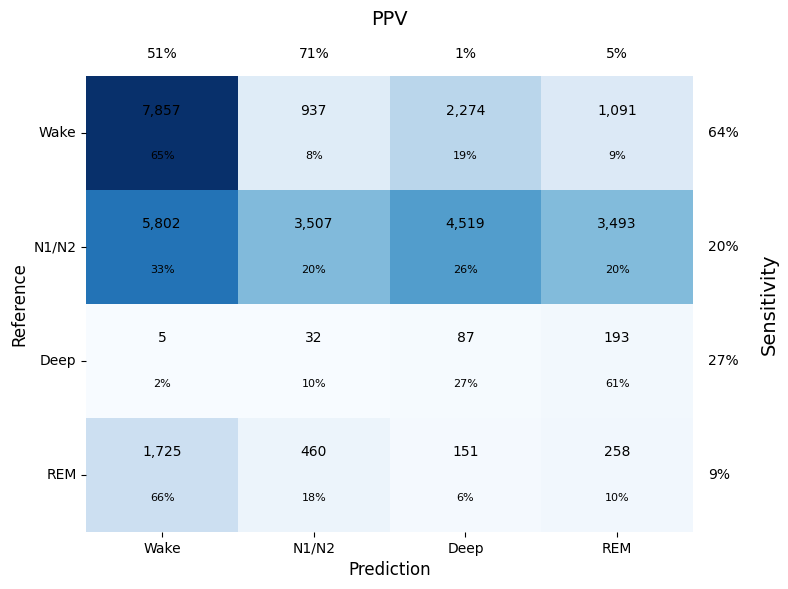

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Figure saved to /home/npr264/DeepLearning/project/cleaned/figures/ActiNetGRU/cms/cm_model0.png
Done with loop 0


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/checkpoints/ActiNetGRU/loss exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | acc_processing  | DeepACTINeT          | 164 K  | train
1 | embeddingLayer  | Linear               | 48     | train
2 | dropout_embed   | Dropout              | 0      | train
3 | dropout_hidden2 | Dropout              | 0      | train
4 | rnn             | GRU                  | 414 K  | train
5 | hidden2         | Linear               | 8.2 K  | train
6 | classifier      | Linear               | 132    | train
7 | tr

Epoch 0: 100%|██████████| 101/101 [00:04<00:00, 23.59it/s, v_num=oigs, train_loss_step=1.440]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 43.74it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:00, 32.54it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 32.74it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 32.81it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 32.93it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 32.70it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 32.71it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 8/14 [00:00<00:00, 32.67it/s]torch

Metric val_loss improved. New best score: 1.431


Epoch 1: 100%|██████████| 101/101 [00:05<00:00, 19.99it/s, v_num=oigs, train_loss_step=1.090, val_loss=1.430, val_acc=0.375, val_cohen_kappa=0.0855, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 34.50it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:00, 35.49it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 35.14it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 34.92it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 34.87it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 34.60it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 34.47it/s]torch.Size([2, 192000, 3]

Metric val_loss improved by 0.103 >= min_delta = 0.0. New best score: 1.328


Epoch 2: 100%|██████████| 101/101 [00:05<00:00, 18.12it/s, v_num=oigs, train_loss_step=1.160, val_loss=1.330, val_acc=0.412, val_cohen_kappa=0.163, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 30.58it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:00, 31.47it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 32.19it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 32.54it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 32.52it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 32.71it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 31.56it/s]torch.Size([2, 192000, 3])

Metric val_loss improved by 0.036 >= min_delta = 0.0. New best score: 1.292


Epoch 3: 100%|██████████| 101/101 [00:07<00:00, 13.90it/s, v_num=oigs, train_loss_step=1.460, val_loss=1.290, val_acc=0.356, val_cohen_kappa=0.156, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 42.14it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:00, 42.98it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 43.63it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 44.06it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 39.46it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 17.13it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 17.38it/s]torch.Size([2, 192000, 3])

Metric val_loss improved by 0.080 >= min_delta = 0.0. New best score: 1.212


Epoch 4: 100%|██████████| 101/101 [00:07<00:00, 12.68it/s, v_num=oigs, train_loss_step=1.190, val_loss=1.210, val_acc=0.348, val_cohen_kappa=0.171, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:01, 12.20it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:01, 11.17it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 13.33it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 13.19it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 13.56it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 13.56it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 14.62it/s]torch.Size([2, 192000, 3])

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.211


Epoch 7: 100%|██████████| 101/101 [00:09<00:00, 10.62it/s, v_num=oigs, train_loss_step=1.240, val_loss=1.210, val_acc=0.345, val_cohen_kappa=0.158, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:01, 11.95it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:01, 10.70it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:01, 10.15it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:01,  9.90it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 10.04it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 10.61it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 11.08it/s]torch.Size([2, 192000, 3])

Metric val_loss improved by 0.073 >= min_delta = 0.0. New best score: 1.137


Epoch 9: 100%|██████████| 101/101 [00:09<00:00, 10.45it/s, v_num=oigs, train_loss_step=1.200, val_loss=1.140, val_acc=0.388, val_cohen_kappa=0.194, train_loss_epoch=1.190]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:01, 10.14it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:01,  9.50it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:01,  9.64it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:01,  9.55it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00,  9.57it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00,  9.62it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00,  9.68it/s]torch.Size([2, 192000, 3])

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.137. Signaling Trainer to stop.


Epoch 12: 100%|██████████| 101/101 [00:12<00:00,  8.28it/s, v_num=oigs, train_loss_step=1.100, val_loss=1.140, val_acc=0.396, val_cohen_kappa=0.200, train_loss_epoch=1.080]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Best model path: /scratch/npr264/BioDeepL/project/checkpoints/ActiNetGRU/loss/best-checkpoint-v12.ckpt
Trained model 1 in 130.30906677246094 seconds
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([1, 192000, 3])


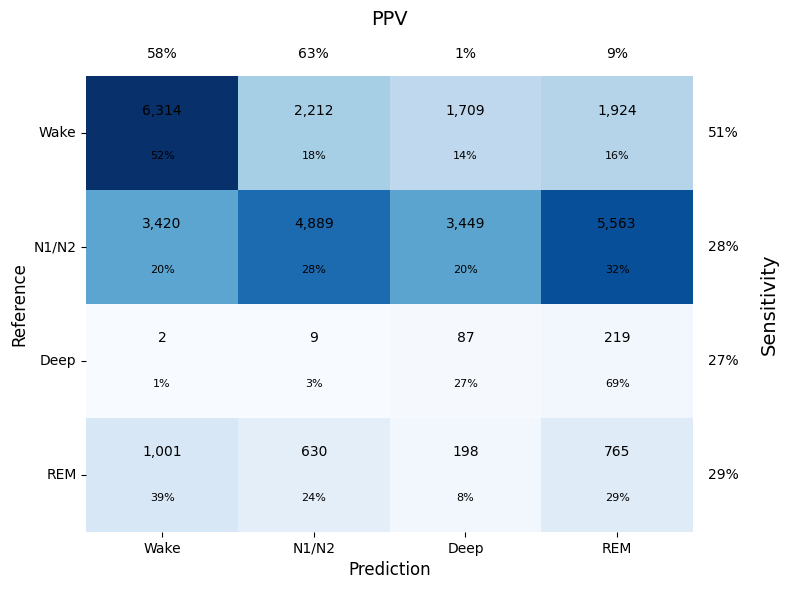

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Figure saved to /home/npr264/DeepLearning/project/cleaned/figures/ActiNetGRU/cms/cm_model1.png
Done with loop 1


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/checkpoints/ActiNetGRU/loss exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | acc_processing  | DeepACTINeT          | 164 K  | train
1 | embeddingLayer  | Linear               | 48     | train
2 | dropout_embed   | Dropout              | 0      | train
3 | dropout_hidden2 | Dropout              | 0      | train
4 | rnn             | GRU                  | 414 K  | train
5 | hidden2         | Linear               | 8.2 K  | train
6 | classifier      | Linear               | 132    | train
7 | tr

Epoch 0: 100%|██████████| 101/101 [00:08<00:00, 11.39it/s, v_num=bf6r, train_loss_step=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:01, 10.16it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:01, 10.39it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:01, 10.06it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 10.21it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 10.05it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 10.13it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 10.25it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 8/14 [00:00<00:00, 10.22it/s]torch

Metric val_loss improved. New best score: 1.334


Epoch 1: 100%|██████████| 101/101 [00:09<00:00, 10.85it/s, v_num=bf6r, train_loss_step=1.230, val_loss=1.330, val_acc=0.283, val_cohen_kappa=0.0814, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:01, 10.24it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:01, 10.22it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 11.00it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 10.36it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 10.55it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 10.43it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 10.52it/s]torch.Size([2, 192000, 3]

Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 1.305


Epoch 2: 100%|██████████| 101/101 [00:09<00:00, 11.21it/s, v_num=bf6r, train_loss_step=1.610, val_loss=1.310, val_acc=0.306, val_cohen_kappa=0.103, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:01,  9.94it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:01,  9.90it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:01,  9.70it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:01,  9.56it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00,  9.58it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00,  9.64it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00,  9.69it/s]torch.Size([2, 192000, 3])

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.300


Epoch 4: 100%|██████████| 101/101 [00:10<00:00,  9.83it/s, v_num=bf6r, train_loss_step=1.140, val_loss=1.300, val_acc=0.354, val_cohen_kappa=0.142, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 30.06it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:00, 19.31it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 20.98it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 19.24it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 18.59it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 18.46it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 17.73it/s]torch.Size([2, 192000, 3])

Metric val_loss improved by 0.054 >= min_delta = 0.0. New best score: 1.246


Epoch 5: 100%|██████████| 101/101 [00:10<00:00,  9.63it/s, v_num=bf6r, train_loss_step=1.110, val_loss=1.250, val_acc=0.357, val_cohen_kappa=0.169, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:01,  9.52it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:01,  9.24it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:01,  9.02it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:01,  9.35it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:01,  8.57it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00,  8.60it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00,  8.34it/s]torch.Size([2, 192000, 3])

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 1.232


Epoch 7: 100%|██████████| 101/101 [00:09<00:00, 10.47it/s, v_num=bf6r, train_loss_step=1.110, val_loss=1.230, val_acc=0.425, val_cohen_kappa=0.190, train_loss_epoch=1.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 18.13it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:00, 13.28it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 11.74it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 11.22it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 10.76it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 10.48it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 10.31it/s]torch.Size([2, 192000, 3])

Metric val_loss improved by 0.042 >= min_delta = 0.0. New best score: 1.190


Epoch 8: 100%|██████████| 101/101 [00:10<00:00,  9.97it/s, v_num=bf6r, train_loss_step=1.280, val_loss=1.190, val_acc=0.393, val_cohen_kappa=0.184, train_loss_epoch=1.190]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 16.71it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:00, 16.35it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 14.36it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 10.64it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 12.29it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 14.02it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 15.77it/s]torch.Size([2, 192000, 3])

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.185


Epoch 10: 100%|██████████| 101/101 [00:09<00:00, 10.32it/s, v_num=bf6r, train_loss_step=1.410, val_loss=1.190, val_acc=0.427, val_cohen_kappa=0.194, train_loss_epoch=1.160]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:01,  9.78it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:01,  9.81it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:01,  9.67it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:01,  9.54it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00,  9.71it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00,  9.73it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00,  9.68it/s]torch.Size([2, 192000, 3]

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 1.165


Epoch 11: 100%|██████████| 101/101 [00:09<00:00, 10.28it/s, v_num=bf6r, train_loss_step=1.030, val_loss=1.170, val_acc=0.361, val_cohen_kappa=0.191, train_loss_epoch=1.130]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 18.39it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:00, 12.81it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 14.25it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 15.69it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 17.96it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 20.05it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 21.17it/s]torch.Size([2, 192000, 3]

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.165. Signaling Trainer to stop.


Epoch 14: 100%|██████████| 101/101 [00:11<00:00,  8.92it/s, v_num=bf6r, train_loss_step=0.886, val_loss=1.260, val_acc=0.598, val_cohen_kappa=0.296, train_loss_epoch=0.993]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Best model path: /scratch/npr264/BioDeepL/project/checkpoints/ActiNetGRU/loss/best-checkpoint-v13.ckpt
Trained model 2 in 180.45435786247253 seconds
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([1, 192000, 3])


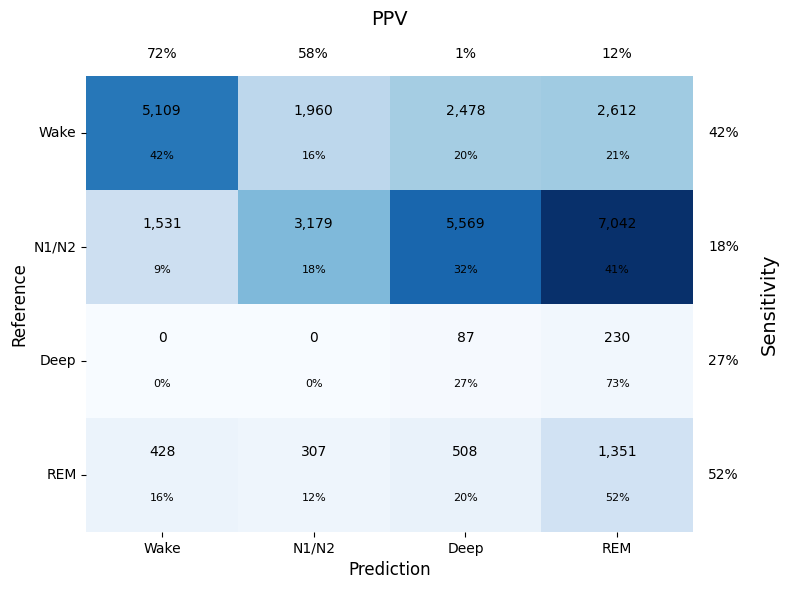

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Figure saved to /home/npr264/DeepLearning/project/cleaned/figures/ActiNetGRU/cms/cm_model2.png
Done with loop 2


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/checkpoints/ActiNetGRU/loss exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | acc_processing  | DeepACTINeT          | 164 K  | train
1 | embeddingLayer  | Linear               | 48     | train
2 | dropout_embed   | Dropout              | 0      | train
3 | dropout_hidden2 | Dropout              | 0      | train
4 | rnn             | GRU                  | 414 K  | train
5 | hidden2         | Linear               | 8.2 K  | train
6 | classifier      | Linear               | 132    | train
7 | tr

Epoch 0: 100%|██████████| 101/101 [00:08<00:00, 12.61it/s, v_num=5y43, train_loss_step=1.630]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:01, 10.60it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:01, 10.32it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:01, 10.06it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 10.30it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 10.17it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 10.38it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 10.36it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 8/14 [00:00<00:00, 10.40it/s]torch

Metric val_loss improved. New best score: 1.344


Epoch 1: 100%|██████████| 101/101 [00:08<00:00, 11.95it/s, v_num=5y43, train_loss_step=1.290, val_loss=1.340, val_acc=0.238, val_cohen_kappa=0.0753, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 30.65it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:01,  9.64it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 11.84it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 14.09it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 11.06it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 12.09it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 12.16it/s]torch.Size([2, 192000, 3]

Metric val_loss improved by 0.033 >= min_delta = 0.0. New best score: 1.311


Epoch 2: 100%|██████████| 101/101 [00:09<00:00, 10.34it/s, v_num=5y43, train_loss_step=1.120, val_loss=1.310, val_acc=0.276, val_cohen_kappa=0.0741, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:01, 10.91it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:01,  9.90it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:01, 10.40it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 12.38it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 11.86it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00,  9.66it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00,  9.85it/s]torch.Size([2, 192000, 3]

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 1.294


Epoch 3: 100%|██████████| 101/101 [00:08<00:00, 12.32it/s, v_num=5y43, train_loss_step=1.310, val_loss=1.290, val_acc=0.340, val_cohen_kappa=0.117, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:01,  9.25it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:01,  8.22it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:01,  8.90it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:01,  9.37it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00,  9.95it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00,  9.52it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00,  9.54it/s]torch.Size([2, 192000, 3])

Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 1.267


Epoch 7: 100%|██████████| 101/101 [00:10<00:00, 10.05it/s, v_num=5y43, train_loss_step=1.250, val_loss=1.270, val_acc=0.357, val_cohen_kappa=0.138, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:01, 12.61it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:01, 10.66it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:01, 10.15it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 10.03it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00,  9.98it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00,  9.85it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00,  9.91it/s]torch.Size([2, 192000, 3])

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 1.256


Epoch 8: 100%|██████████| 101/101 [00:10<00:00,  9.74it/s, v_num=5y43, train_loss_step=1.080, val_loss=1.260, val_acc=0.370, val_cohen_kappa=0.168, train_loss_epoch=1.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:01,  9.17it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:01,  9.01it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:01,  8.95it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:01,  9.13it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00,  9.14it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00,  9.24it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00,  9.35it/s]torch.Size([2, 192000, 3])

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 1.238


Epoch 9: 100%|██████████| 101/101 [00:09<00:00, 10.27it/s, v_num=5y43, train_loss_step=1.400, val_loss=1.240, val_acc=0.329, val_cohen_kappa=0.146, train_loss_epoch=1.200]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:01,  7.93it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:01,  8.99it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:01,  9.35it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:01,  9.56it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00,  9.21it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00,  9.33it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00,  9.34it/s]torch.Size([2, 192000, 3])

Metric val_loss improved by 0.056 >= min_delta = 0.0. New best score: 1.182


Epoch 11: 100%|██████████| 101/101 [00:10<00:00,  9.86it/s, v_num=5y43, train_loss_step=1.160, val_loss=1.180, val_acc=0.359, val_cohen_kappa=0.188, train_loss_epoch=1.170]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:01, 12.53it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:01, 11.82it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 12.17it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 11.96it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 12.06it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 12.64it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 12.36it/s]torch.Size([2, 192000, 3]

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 1.158


Epoch 12: 100%|██████████| 101/101 [00:09<00:00, 10.16it/s, v_num=5y43, train_loss_step=1.110, val_loss=1.160, val_acc=0.432, val_cohen_kappa=0.224, train_loss_epoch=1.160]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 13.17it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:00, 12.91it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 12.90it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 12.41it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 12.12it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 11.97it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 12.86it/s]torch.Size([2, 192000, 3]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.156


Epoch 14: 100%|██████████| 101/101 [00:09<00:00, 10.22it/s, v_num=5y43, train_loss_step=1.060, val_loss=1.160, val_acc=0.355, val_cohen_kappa=0.178, train_loss_epoch=1.100]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 13.90it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:01, 11.96it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 11.81it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 12.08it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 12.14it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 12.11it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 11.96it/s]torch.Size([2, 192000, 3]

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.156. Signaling Trainer to stop.


Epoch 17: 100%|██████████| 101/101 [00:11<00:00,  9.07it/s, v_num=5y43, train_loss_step=1.180, val_loss=1.430, val_acc=0.447, val_cohen_kappa=0.148, train_loss_epoch=0.893]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Best model path: /scratch/npr264/BioDeepL/project/checkpoints/ActiNetGRU/loss/best-checkpoint-v14.ckpt
Trained model 3 in 214.41141605377197 seconds
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([1, 192000, 3])


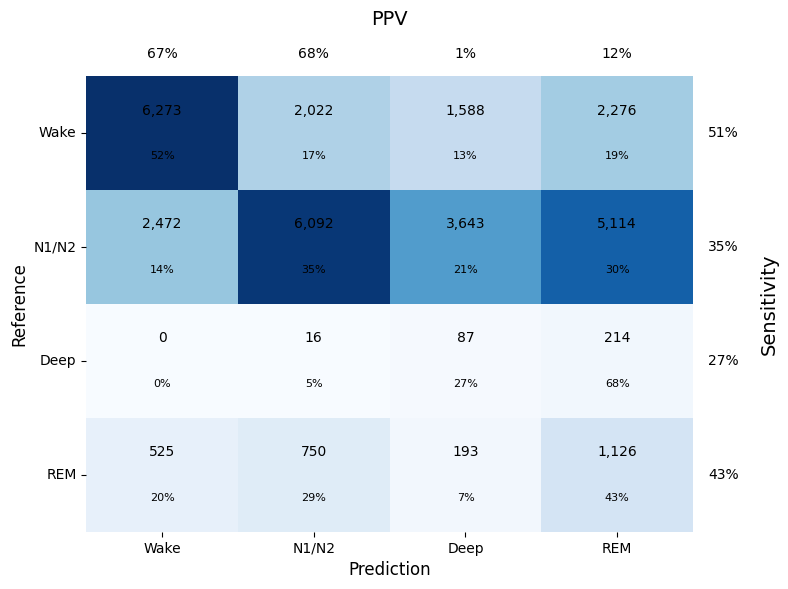

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Figure saved to /home/npr264/DeepLearning/project/cleaned/figures/ActiNetGRU/cms/cm_model3.png
Done with loop 3


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/checkpoints/ActiNetGRU/loss exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | acc_processing  | DeepACTINeT          | 164 K  | train
1 | embeddingLayer  | Linear               | 48     | train
2 | dropout_embed   | Dropout              | 0      | train
3 | dropout_hidden2 | Dropout              | 0      | train
4 | rnn             | GRU                  | 414 K  | train
5 | hidden2         | Linear               | 8.2 K  | train
6 | classifier      | Linear               | 132    | train
7 | tr

Epoch 0: 100%|██████████| 101/101 [00:08<00:00, 11.25it/s, v_num=mtf2, train_loss_step=1.600]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:01,  9.12it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:01,  8.78it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:01,  9.55it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:01,  9.43it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 10.00it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00,  9.97it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 10.01it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 8/14 [00:00<00:00, 10.11it/s]torch

Metric val_loss improved. New best score: 1.361


Epoch 1: 100%|██████████| 101/101 [00:09<00:00, 10.52it/s, v_num=mtf2, train_loss_step=1.250, val_loss=1.360, val_acc=0.245, val_cohen_kappa=0.0547, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 25.32it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:00, 13.68it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 13.68it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 13.17it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 12.51it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 11.00it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 12.04it/s]torch.Size([2, 192000, 3]

Metric val_loss improved by 0.046 >= min_delta = 0.0. New best score: 1.315


Epoch 2: 100%|██████████| 101/101 [00:10<00:00, 10.10it/s, v_num=mtf2, train_loss_step=1.150, val_loss=1.320, val_acc=0.376, val_cohen_kappa=0.132, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:04,  2.88it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:02,  4.60it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:01,  6.41it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:01,  6.70it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:01,  7.81it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00,  8.84it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00,  9.96it/s]torch.Size([2, 192000, 3])

Metric val_loss improved by 0.074 >= min_delta = 0.0. New best score: 1.241


Epoch 3: 100%|██████████| 101/101 [00:10<00:00,  9.97it/s, v_num=mtf2, train_loss_step=1.190, val_loss=1.240, val_acc=0.346, val_cohen_kappa=0.146, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 30.85it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:00, 23.77it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 24.72it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 18.02it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 14.33it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 13.76it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 12.82it/s]torch.Size([2, 192000, 3])

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 1.219


Epoch 5: 100%|██████████| 101/101 [00:09<00:00, 10.41it/s, v_num=mtf2, train_loss_step=1.160, val_loss=1.220, val_acc=0.295, val_cohen_kappa=0.134, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:01, 11.82it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:01,  9.91it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:01, 10.73it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 10.26it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 10.29it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 10.20it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 10.22it/s]torch.Size([2, 192000, 3])

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.216


Epoch 6: 100%|██████████| 101/101 [00:09<00:00, 10.57it/s, v_num=mtf2, train_loss_step=1.120, val_loss=1.220, val_acc=0.318, val_cohen_kappa=0.146, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:01, 10.65it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:01,  9.97it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:01, 10.09it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:01,  9.93it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00,  9.82it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00,  9.86it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 10.03it/s]torch.Size([2, 192000, 3])

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.216. Signaling Trainer to stop.


Epoch 9: 100%|██████████| 101/101 [00:11<00:00,  8.45it/s, v_num=mtf2, train_loss_step=1.250, val_loss=1.220, val_acc=0.372, val_cohen_kappa=0.168, train_loss_epoch=1.160]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Best model path: /scratch/npr264/BioDeepL/project/checkpoints/ActiNetGRU/loss/best-checkpoint-v15.ckpt
Trained model 4 in 121.64050269126892 seconds
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([1, 192000, 3])


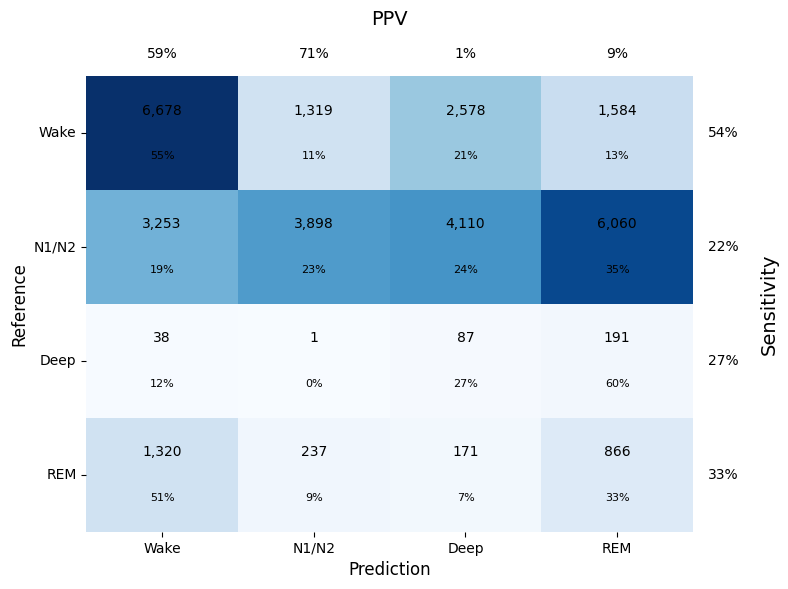

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Figure saved to /home/npr264/DeepLearning/project/cleaned/figures/ActiNetGRU/cms/cm_model4.png
Done with loop 4


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/checkpoints/ActiNetGRU/loss exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | acc_processing  | DeepACTINeT          | 164 K  | train
1 | embeddingLayer  | Linear               | 48     | train
2 | dropout_embed   | Dropout              | 0      | train
3 | dropout_hidden2 | Dropout              | 0      | train
4 | rnn             | GRU                  | 414 K  | train
5 | hidden2         | Linear               | 8.2 K  | train
6 | classifier      | Linear               | 132    | train
7 | tr

Epoch 0: 100%|██████████| 101/101 [00:08<00:00, 11.44it/s, v_num=pi5y, train_loss_step=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 19.56it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:01, 11.36it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 14.36it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 14.12it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 13.45it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 10.01it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 10.98it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 8/14 [00:00<00:00, 11.48it/s]torch

Metric val_loss improved. New best score: 1.391


Epoch 1: 100%|██████████| 101/101 [00:10<00:00, 10.02it/s, v_num=pi5y, train_loss_step=1.280, val_loss=1.390, val_acc=0.321, val_cohen_kappa=0.0966, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 37.95it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:00, 34.69it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 36.36it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 22.90it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 23.71it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 17.14it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 15.83it/s]torch.Size([2, 192000, 3]

Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 1.364


Epoch 2: 100%|██████████| 101/101 [00:10<00:00, 10.01it/s, v_num=pi5y, train_loss_step=1.220, val_loss=1.360, val_acc=0.345, val_cohen_kappa=0.102, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:01, 11.87it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:01, 10.28it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:01,  9.94it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:01,  9.71it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 10.00it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00,  9.80it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00,  9.85it/s]torch.Size([2, 192000, 3])

Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 1.338


Epoch 3: 100%|██████████| 101/101 [00:09<00:00, 10.34it/s, v_num=pi5y, train_loss_step=1.180, val_loss=1.340, val_acc=0.346, val_cohen_kappa=0.121, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:01, 11.11it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:01, 10.01it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:01, 10.15it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:01,  9.93it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00,  9.76it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00,  9.67it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00,  9.71it/s]torch.Size([2, 192000, 3])

Metric val_loss improved by 0.034 >= min_delta = 0.0. New best score: 1.304


Epoch 4: 100%|██████████| 101/101 [00:09<00:00, 10.10it/s, v_num=pi5y, train_loss_step=1.240, val_loss=1.300, val_acc=0.358, val_cohen_kappa=0.123, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:01,  9.92it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:01,  9.98it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:01,  9.75it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:01,  9.72it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 10.42it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 10.18it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 10.21it/s]torch.Size([2, 192000, 3])

Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 1.275


Epoch 5: 100%|██████████| 101/101 [00:09<00:00, 10.61it/s, v_num=pi5y, train_loss_step=1.470, val_loss=1.270, val_acc=0.299, val_cohen_kappa=0.118, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:01, 11.46it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:01, 11.76it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 11.37it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 11.62it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 11.29it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 11.32it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 11.27it/s]torch.Size([2, 192000, 3])

Metric val_loss improved by 0.054 >= min_delta = 0.0. New best score: 1.221


Epoch 7: 100%|██████████| 101/101 [00:09<00:00, 10.33it/s, v_num=pi5y, train_loss_step=1.330, val_loss=1.220, val_acc=0.340, val_cohen_kappa=0.169, train_loss_epoch=1.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 14.14it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:01,  8.90it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 11.03it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 12.85it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 12.24it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 10.28it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 10.75it/s]torch.Size([2, 192000, 3])

Metric val_loss improved by 0.053 >= min_delta = 0.0. New best score: 1.168


Epoch 9: 100%|██████████| 101/101 [00:10<00:00,  9.60it/s, v_num=pi5y, train_loss_step=1.160, val_loss=1.170, val_acc=0.373, val_cohen_kappa=0.172, train_loss_epoch=1.190]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 30.66it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:00, 15.16it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 13.04it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 12.21it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 12.02it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 12.08it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 12.11it/s]torch.Size([2, 192000, 3])

Metric val_loss improved by 0.030 >= min_delta = 0.0. New best score: 1.138


Epoch 10: 100%|██████████| 101/101 [00:09<00:00, 10.13it/s, v_num=pi5y, train_loss_step=1.220, val_loss=1.140, val_acc=0.351, val_cohen_kappa=0.183, train_loss_epoch=1.170]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:01,  9.40it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:01,  9.54it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:01,  9.72it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:01,  9.79it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00,  9.66it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00,  9.99it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00,  9.85it/s]torch.Size([2, 192000, 3]

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 1.123


Epoch 13: 100%|██████████| 101/101 [00:09<00:00, 11.04it/s, v_num=pi5y, train_loss_step=0.934, val_loss=1.120, val_acc=0.344, val_cohen_kappa=0.186, train_loss_epoch=1.080]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 15.47it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:01, 11.97it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 11.93it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 12.58it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 12.86it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 12.72it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 13.62it/s]torch.Size([2, 192000, 3]

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.123. Signaling Trainer to stop.


Epoch 16: 100%|██████████| 101/101 [00:11<00:00,  9.06it/s, v_num=pi5y, train_loss_step=1.180, val_loss=1.510, val_acc=0.371, val_cohen_kappa=0.148, train_loss_epoch=0.939]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Best model path: /scratch/npr264/BioDeepL/project/checkpoints/ActiNetGRU/loss/best-checkpoint-v16.ckpt
Trained model 5 in 204.84631633758545 seconds
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([1, 192000, 3])


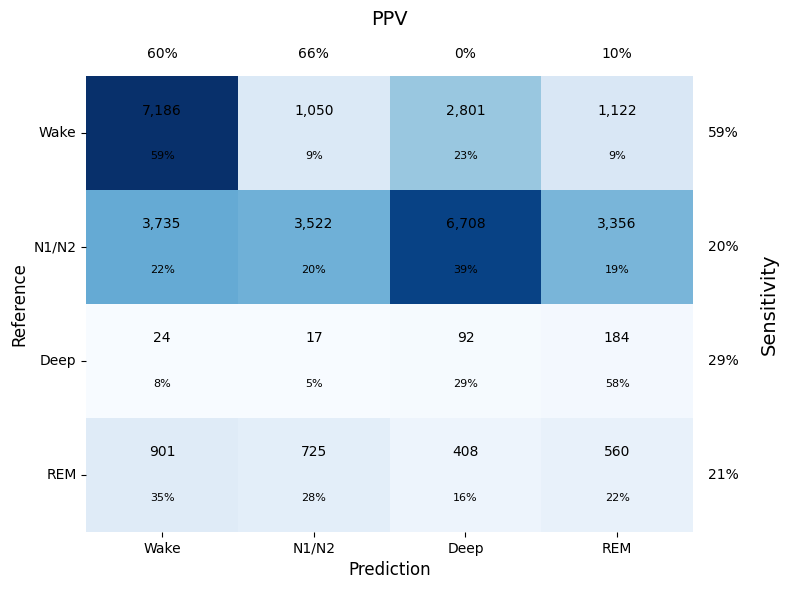

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Figure saved to /home/npr264/DeepLearning/project/cleaned/figures/ActiNetGRU/cms/cm_model5.png
Done with loop 5


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/checkpoints/ActiNetGRU/loss exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | acc_processing  | DeepACTINeT          | 164 K  | train
1 | embeddingLayer  | Linear               | 48     | train
2 | dropout_embed   | Dropout              | 0      | train
3 | dropout_hidden2 | Dropout              | 0      | train
4 | rnn             | GRU                  | 414 K  | train
5 | hidden2         | Linear               | 8.2 K  | train
6 | classifier      | Linear               | 132    | train
7 | tr

Epoch 0: 100%|██████████| 101/101 [00:09<00:00, 11.20it/s, v_num=r7uv, train_loss_step=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:01, 10.81it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:01, 10.04it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:01, 10.15it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 10.11it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00,  9.99it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 10.02it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00,  9.98it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 8/14 [00:00<00:00, 10.01it/s]torch

Metric val_loss improved. New best score: 1.360


Epoch 1: 100%|██████████| 101/101 [00:09<00:00, 10.47it/s, v_num=r7uv, train_loss_step=1.320, val_loss=1.360, val_acc=0.522, val_cohen_kappa=0.182, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 43.38it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:00, 35.60it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 26.11it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 15.00it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 13.51it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 13.45it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 12.78it/s]torch.Size([2, 192000, 3])

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 1.345


Epoch 3: 100%|██████████| 101/101 [00:09<00:00, 10.34it/s, v_num=r7uv, train_loss_step=1.280, val_loss=1.340, val_acc=0.305, val_cohen_kappa=0.0973, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 13.26it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:01, 11.61it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:01,  8.33it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:01,  8.68it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:01,  6.93it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:01,  7.44it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00,  7.89it/s]torch.Size([2, 192000, 3]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.339


Epoch 4: 100%|██████████| 101/101 [00:09<00:00, 10.19it/s, v_num=r7uv, train_loss_step=1.410, val_loss=1.340, val_acc=0.329, val_cohen_kappa=0.112, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:01, 10.81it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:01, 10.77it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:01, 10.27it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 10.06it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 10.13it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00,  9.98it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 10.05it/s]torch.Size([2, 192000, 3])

Metric val_loss improved by 0.048 >= min_delta = 0.0. New best score: 1.291


Epoch 5: 100%|██████████| 101/101 [00:09<00:00, 10.81it/s, v_num=r7uv, train_loss_step=1.130, val_loss=1.290, val_acc=0.497, val_cohen_kappa=0.219, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:01,  9.53it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:01,  9.32it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:01,  9.10it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:01,  9.13it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00,  9.48it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00,  9.40it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00,  9.41it/s]torch.Size([2, 192000, 3])

Metric val_loss improved by 0.077 >= min_delta = 0.0. New best score: 1.214


Epoch 6: 100%|██████████| 101/101 [00:08<00:00, 11.25it/s, v_num=r7uv, train_loss_step=1.510, val_loss=1.210, val_acc=0.328, val_cohen_kappa=0.131, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 24.87it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:00, 21.39it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 20.27it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 19.76it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 21.42it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 22.67it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 18.90it/s]torch.Size([2, 192000, 3])

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 1.200


Epoch 9: 100%|██████████| 101/101 [00:09<00:00, 11.18it/s, v_num=r7uv, train_loss_step=1.080, val_loss=1.200, val_acc=0.361, val_cohen_kappa=0.182, train_loss_epoch=1.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:01,  9.39it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:01,  9.94it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:01,  9.83it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 10.19it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00,  9.97it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 10.00it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00,  9.82it/s]torch.Size([2, 192000, 3])

Metric val_loss improved by 0.031 >= min_delta = 0.0. New best score: 1.169


Epoch 10: 100%|██████████| 101/101 [00:09<00:00, 10.46it/s, v_num=r7uv, train_loss_step=1.050, val_loss=1.170, val_acc=0.367, val_cohen_kappa=0.192, train_loss_epoch=1.200]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:01, 12.19it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:01, 10.73it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 13.04it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 12.74it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 13.38it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 14.07it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 15.04it/s]torch.Size([2, 192000, 3]

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 1.148


Epoch 11: 100%|██████████| 101/101 [00:10<00:00, 10.01it/s, v_num=r7uv, train_loss_step=1.150, val_loss=1.150, val_acc=0.433, val_cohen_kappa=0.231, train_loss_epoch=1.160]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 18.45it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:01, 11.70it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 15.21it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 18.03it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 17.03it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 16.30it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 16.59it/s]torch.Size([2, 192000, 3]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.146


Epoch 15: 100%|██████████| 101/101 [00:07<00:00, 14.23it/s, v_num=r7uv, train_loss_step=0.820, val_loss=1.150, val_acc=0.459, val_cohen_kappa=0.240, train_loss_epoch=1.090]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:01, 12.89it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:00, 13.18it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 13.07it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 12.80it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 13.08it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 12.98it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 13.09it/s]torch.Size([2, 192000, 3]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.145


Epoch 16: 100%|██████████| 101/101 [00:07<00:00, 13.12it/s, v_num=r7uv, train_loss_step=0.852, val_loss=1.140, val_acc=0.383, val_cohen_kappa=0.179, train_loss_epoch=1.080]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 16.77it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:00, 15.58it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 12.55it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 13.95it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 15.41it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 15.49it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 16.49it/s]torch.Size([2, 192000, 3]

Metric val_loss improved by 0.052 >= min_delta = 0.0. New best score: 1.093


Epoch 18: 100%|██████████| 101/101 [00:07<00:00, 13.12it/s, v_num=r7uv, train_loss_step=1.040, val_loss=1.090, val_acc=0.416, val_cohen_kappa=0.231, train_loss_epoch=0.998]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 14.78it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:00, 14.30it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 13.60it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 13.73it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 13.60it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 13.49it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 13.46it/s]torch.Size([2, 192000, 3]

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.093. Signaling Trainer to stop.


Epoch 21: 100%|██████████| 101/101 [00:09<00:00, 11.05it/s, v_num=r7uv, train_loss_step=0.962, val_loss=1.350, val_acc=0.441, val_cohen_kappa=0.146, train_loss_epoch=0.813]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Best model path: /scratch/npr264/BioDeepL/project/checkpoints/ActiNetGRU/loss/best-checkpoint-v17.ckpt
Trained model 6 in 235.7759974002838 seconds
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([1, 192000, 3])


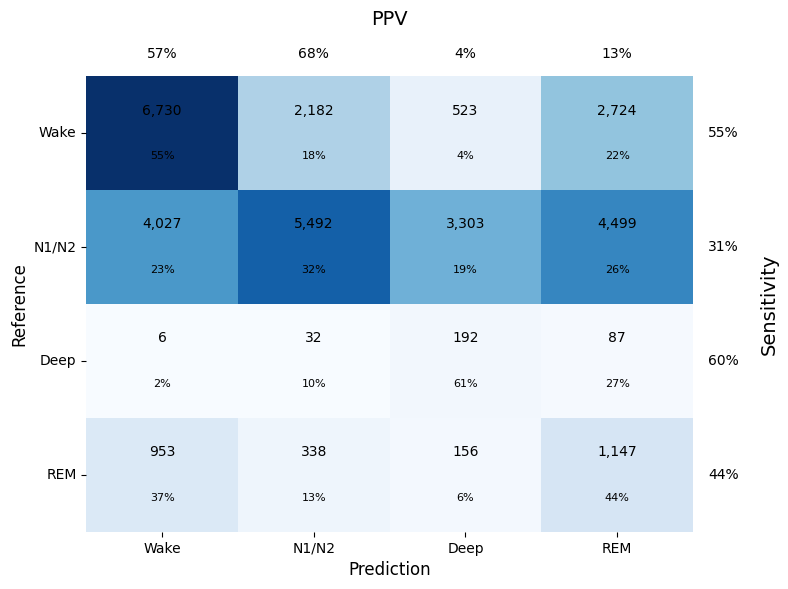

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Figure saved to /home/npr264/DeepLearning/project/cleaned/figures/ActiNetGRU/cms/cm_model6.png
Done with loop 6


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/checkpoints/ActiNetGRU/loss exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | acc_processing  | DeepACTINeT          | 164 K  | train
1 | embeddingLayer  | Linear               | 48     | train
2 | dropout_embed   | Dropout              | 0      | train
3 | dropout_hidden2 | Dropout              | 0      | train
4 | rnn             | GRU                  | 414 K  | train
5 | hidden2         | Linear               | 8.2 K  | train
6 | classifier      | Linear               | 132    | train
7 | tr

Epoch 0: 100%|██████████| 101/101 [00:06<00:00, 14.55it/s, v_num=hric, train_loss_step=1.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 20.14it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:00, 29.53it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 26.41it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 25.03it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 27.66it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 26.99it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 27.15it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 8/14 [00:00<00:00, 27.11it/s]torch

Metric val_loss improved. New best score: 1.456


Epoch 1: 100%|██████████| 101/101 [00:07<00:00, 13.33it/s, v_num=hric, train_loss_step=1.370, val_loss=1.460, val_acc=0.313, val_cohen_kappa=0.0837, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 32.91it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:00, 27.14it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 25.40it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 24.49it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 24.80it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 26.85it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 26.63it/s]torch.Size([2, 192000, 3]

Metric val_loss improved by 0.076 >= min_delta = 0.0. New best score: 1.380


Epoch 2: 100%|██████████| 101/101 [00:06<00:00, 15.33it/s, v_num=hric, train_loss_step=1.610, val_loss=1.380, val_acc=0.250, val_cohen_kappa=0.0656, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 30.32it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:00, 17.32it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 16.41it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 15.36it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 15.26it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 14.69it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 14.63it/s]torch.Size([2, 192000, 3]

Metric val_loss improved by 0.034 >= min_delta = 0.0. New best score: 1.345


Epoch 4: 100%|██████████| 101/101 [00:07<00:00, 13.16it/s, v_num=hric, train_loss_step=1.160, val_loss=1.350, val_acc=0.401, val_cohen_kappa=0.178, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 14.36it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:00, 22.10it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 17.71it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 14.22it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 15.82it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 17.40it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 13.14it/s]torch.Size([2, 192000, 3])

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 1.328


Epoch 5: 100%|██████████| 101/101 [00:06<00:00, 14.75it/s, v_num=hric, train_loss_step=1.090, val_loss=1.330, val_acc=0.414, val_cohen_kappa=0.169, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 13.45it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:00, 13.06it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 13.26it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 12.93it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 12.97it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 13.04it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 13.13it/s]torch.Size([2, 192000, 3])

Metric val_loss improved by 0.036 >= min_delta = 0.0. New best score: 1.291


Epoch 6: 100%|██████████| 101/101 [00:07<00:00, 13.16it/s, v_num=hric, train_loss_step=1.300, val_loss=1.290, val_acc=0.303, val_cohen_kappa=0.130, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 13.64it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:00, 13.20it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 13.15it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 13.06it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 13.18it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 13.16it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 13.27it/s]torch.Size([2, 192000, 3])

Metric val_loss improved by 0.127 >= min_delta = 0.0. New best score: 1.164


Epoch 7: 100%|██████████| 101/101 [00:07<00:00, 13.32it/s, v_num=hric, train_loss_step=1.430, val_loss=1.160, val_acc=0.377, val_cohen_kappa=0.200, train_loss_epoch=1.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 24.48it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:00, 17.66it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 15.67it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 15.13it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 14.94it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 15.21it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 15.65it/s]torch.Size([2, 192000, 3])

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 1.149


Epoch 11: 100%|██████████| 101/101 [00:07<00:00, 13.02it/s, v_num=hric, train_loss_step=1.170, val_loss=1.150, val_acc=0.440, val_cohen_kappa=0.240, train_loss_epoch=1.150]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 13.05it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:00, 12.90it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 12.90it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 12.98it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 12.88it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 13.25it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 13.14it/s]torch.Size([2, 192000, 3]

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 1.131


Epoch 15: 100%|██████████| 101/101 [00:08<00:00, 12.61it/s, v_num=hric, train_loss_step=1.250, val_loss=1.130, val_acc=0.418, val_cohen_kappa=0.209, train_loss_epoch=1.070]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 14.45it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:00, 13.03it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 13.20it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 12.84it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 13.16it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 13.02it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 13.16it/s]torch.Size([2, 192000, 3]

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.131. Signaling Trainer to stop.


Epoch 18: 100%|██████████| 101/101 [00:09<00:00, 10.32it/s, v_num=hric, train_loss_step=0.801, val_loss=1.570, val_acc=0.369, val_cohen_kappa=0.151, train_loss_epoch=0.882]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Best model path: /scratch/npr264/BioDeepL/project/checkpoints/ActiNetGRU/loss/best-checkpoint-v18.ckpt
Trained model 7 in 177.60789227485657 seconds
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([1, 192000, 3])


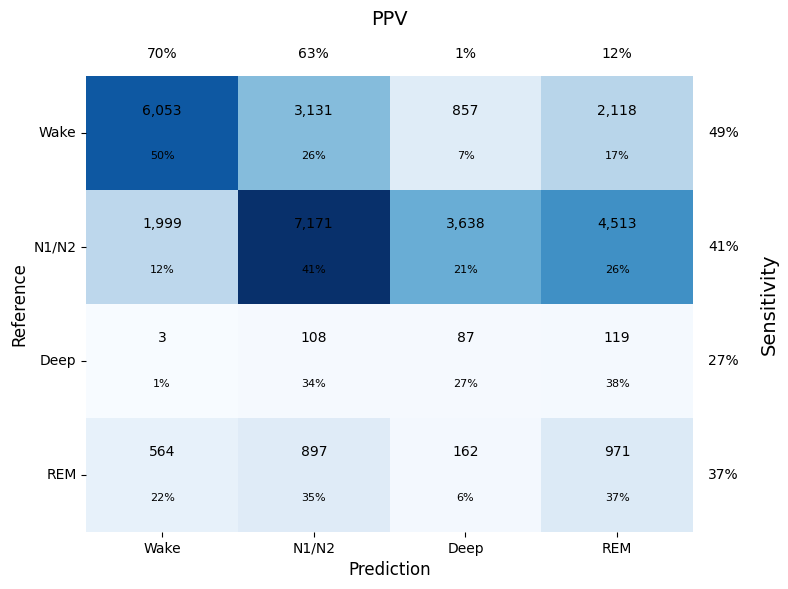

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Figure saved to /home/npr264/DeepLearning/project/cleaned/figures/ActiNetGRU/cms/cm_model7.png
Done with loop 7


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/checkpoints/ActiNetGRU/loss exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | acc_processing  | DeepACTINeT          | 164 K  | train
1 | embeddingLayer  | Linear               | 48     | train
2 | dropout_embed   | Dropout              | 0      | train
3 | dropout_hidden2 | Dropout              | 0      | train
4 | rnn             | GRU                  | 414 K  | train
5 | hidden2         | Linear               | 8.2 K  | train
6 | classifier      | Linear               | 132    | train
7 | tr

Epoch 0: 100%|██████████| 101/101 [00:05<00:00, 17.61it/s, v_num=j9vh, train_loss_step=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 28.92it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:00, 24.02it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 24.26it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 22.66it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 23.43it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 23.25it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 16.59it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 8/14 [00:00<00:00, 16.38it/s]torch

Metric val_loss improved. New best score: 1.331


Epoch 1: 100%|██████████| 101/101 [00:06<00:00, 14.55it/s, v_num=j9vh, train_loss_step=1.310, val_loss=1.330, val_acc=0.299, val_cohen_kappa=0.0806, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 13.83it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:00, 13.53it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 13.99it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 13.45it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 13.49it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 13.27it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 13.30it/s]torch.Size([2, 192000, 3]

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 1.309


Epoch 3: 100%|██████████| 101/101 [00:07<00:00, 13.23it/s, v_num=j9vh, train_loss_step=1.150, val_loss=1.310, val_acc=0.247, val_cohen_kappa=0.0837, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:01, 12.37it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:01, 11.11it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 11.40it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 11.63it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 11.96it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 12.46it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 12.50it/s]torch.Size([2, 192000, 3]

Metric val_loss improved by 0.091 >= min_delta = 0.0. New best score: 1.218


Epoch 4: 100%|██████████| 101/101 [00:07<00:00, 13.23it/s, v_num=j9vh, train_loss_step=1.650, val_loss=1.220, val_acc=0.385, val_cohen_kappa=0.184, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 13.49it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:00, 13.22it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 13.03it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 12.97it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 12.99it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 12.84it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 13.11it/s]torch.Size([2, 192000, 3])

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.218. Signaling Trainer to stop.


Epoch 7: 100%|██████████| 101/101 [00:09<00:00, 10.74it/s, v_num=j9vh, train_loss_step=0.986, val_loss=1.260, val_acc=0.310, val_cohen_kappa=0.142, train_loss_epoch=1.220]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Best model path: /scratch/npr264/BioDeepL/project/checkpoints/ActiNetGRU/loss/best-checkpoint-v19.ckpt
Trained model 8 in 74.46233582496643 seconds
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([2, 192000, 3])
torch.Size([1, 192000, 3])


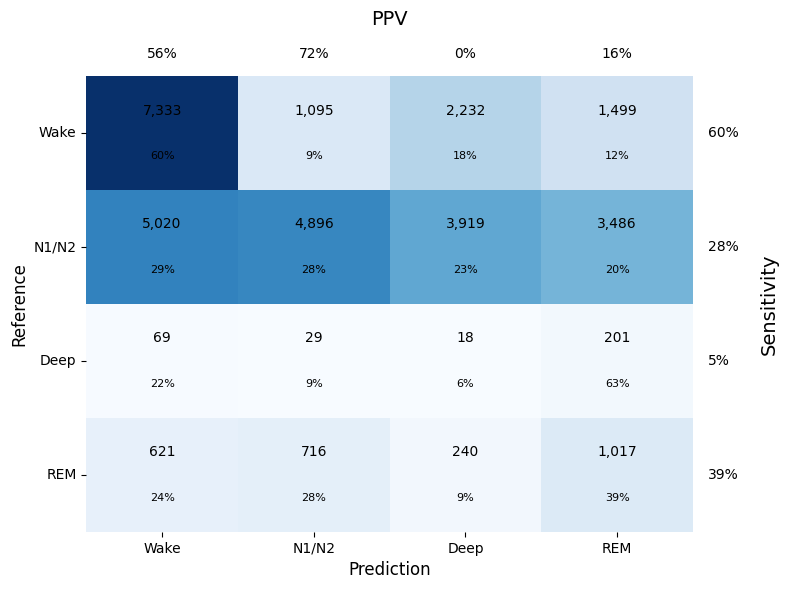

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Figure saved to /home/npr264/DeepLearning/project/cleaned/figures/ActiNetGRU/cms/cm_model8.png
Done with loop 8


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/checkpoints/ActiNetGRU/loss exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | acc_processing  | DeepACTINeT          | 164 K  | train
1 | embeddingLayer  | Linear               | 48     | train
2 | dropout_embed   | Dropout              | 0      | train
3 | dropout_hidden2 | Dropout              | 0      | train
4 | rnn             | GRU                  | 414 K  | train
5 | hidden2         | Linear               | 8.2 K  | train
6 | classifier      | Linear               | 132    | train
7 | tr

Epoch 0: 100%|██████████| 101/101 [00:06<00:00, 14.63it/s, v_num=drtr, train_loss_step=1.530]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 13.76it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:00, 13.54it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 13.82it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 13.13it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 13.35it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 13.28it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 13.48it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  57%|█████▋    | 8/14 [00:00<00:00, 13.58it/s]torch

Metric val_loss improved. New best score: 1.443


Epoch 1: 100%|██████████| 101/101 [00:07<00:00, 13.45it/s, v_num=drtr, train_loss_step=1.330, val_loss=1.440, val_acc=0.440, val_cohen_kappa=0.125, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 21.72it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:00, 16.56it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 15.27it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 14.86it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 14.51it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 14.31it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 14.07it/s]torch.Size([2, 192000, 3])

Metric val_loss improved by 0.120 >= min_delta = 0.0. New best score: 1.323


Epoch 2: 100%|██████████| 101/101 [00:07<00:00, 13.70it/s, v_num=drtr, train_loss_step=1.410, val_loss=1.320, val_acc=0.382, val_cohen_kappa=0.113, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/14 [00:00<?, ?it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 13.28it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:00, 15.08it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  21%|██▏       | 3/14 [00:00<00:00, 15.66it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 14.53it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 15.08it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00, 14.62it/s]torch.Size([2, 192000, 3])

Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00, 14.57it/s]torch.Size([2, 192000, 3])

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.319


Epoch 3:  62%|██████▏   | 63/101 [00:05<00:03, 12.51it/s, v_num=drtr, train_loss_step=1.330, val_loss=1.320, val_acc=0.283, val_cohen_kappa=0.043, train_loss_epoch=1.300]torch.Size([2, 192000, 3])


In [ ]:
accs = []
kappas = []
aurocs = []
cms = []
train_times = []
test_times = []
for i in range(10):
    model, train_time = train_model(
        batch_size = batch_size,
        dropout_embed = dropout_embed,
        acc_preprocess = acc_preprocess,
        RNN_type = RNN_type,
        lr = lr,
        rnn_hidden_size = rnn_hidden_size,
        pre_rnn_size = pre_rnn_size,
        hidden_size2 = hidden_size2,
        dropout_rnn = dropout_rnn,
        dropout_hidden2 = dropout_hidden2,
        modelType = modelType,
        nameAppend = f"model{i}")
    print(f"Trained model {i} in {train_time} seconds")
    acc, kappa, auroc, cm, inference_time_seconds = evaluate_model(model, test_loader, modelType, i)
    accs.append(acc)
    kappas.append(kappa)
    aurocs.append(auroc)
    cms.append(cms)
    train_times.append(train_time)
    test_times.append(inference_time_seconds)
    print(f"Done with loop {i}")

In [19]:
acc_mean, acc_std = np.mean(accs), np.std(accs)
kappa_mean, kappa_std = np.mean(kappas), np.std(kappas)
auroc_mean, auroc_std = np.mean(aurocs), np.std(aurocs)
train_time_mean, train_time_std = np.mean(train_times), np.std(train_times)
test_time_mean, test_time_std = np.mean(test_times), np.std(test_times)

# Print the statistics
print(f"Accuracy: Mean = {acc_mean:.3f}, StdDev = {acc_std:.3f}")
print(f"Kappa: Mean = {kappa_mean:.3f}, StdDev = {kappa_std:.3f}")
print(f"AUROC: Mean = {auroc_mean:.3f}, StdDev = {auroc_std:.3f}")

# Find the index of the best kappa
best_kappa_index = np.argmax(kappas)
print(f"Best Kappa Index: {best_kappa_index}")

Accuracy: Mean = 0.382, StdDev = 0.040
Kappa: Mean = 0.158, StdDev = 0.027
AUROC: Mean = 0.635, StdDev = 0.040
Best Kappa Index: 3
